## 介绍 \ Introduction

这一节介绍的是如何用FLGo实现在聚合阶段做出修改的算法。这里使用的例子是FedMGDA+，该算法由Hu等人于2020年提出（[论文链接](https://arxiv.org/abs/2006.11489)），并发表于 IEEE Transactions on Network Science and Engineering 2022。它受多目标优化中的mgda算法所启发，将该参数更新应用于联邦学习的聚合阶段，从而避免聚合出来的模型更新损害任何一方的利益（全局更新量与任何一个用户的更新量内积为负）。由于关于该论文的讲解知乎上已经有不少帖子，这里仅讲解如何使用FLGo实现该算法。

FedMGDA+在聚合阶段相较于fedavg，它仅在聚合阶段有所不同。fedavg为直接加权(或者不加权)平均所有用户的本地模型，

而FedMGDA+的聚合步骤为：
1. 先用用户的本地模型计算出它们各自的梯度更新$\Delta\theta_i = \theta^t-\theta^{t+1}_i$，并将梯度归一化得到$d_i=\frac{\Delta\theta_i}{\|\Delta\theta_i\|}$；
2. 随后，FedMGDA+在原始聚合权重的邻域范围内，找到一组聚合权重dynamic_lambdas，使得该权重能够最小化所聚合出来的模型更新量的二范数；

$$\mathbf{\lambda}^*=\min_{\mathbf{\lambda}}||\sum_{i\in \mathbb{S}_t}\lambda_i d_i||_2\\s.t. \|\mathbf{\lambda}-\mathbf{\lambda_0}\|_{\infty}\le \epsilon, \mathbf{1}^\top\mathbf{\lambda}=1$$

3. FedMGDA+使用第二步计算出的权重$\mathbf{\lambda}$加权平均所有模型更新量，使用全局步长$\eta$更新模型

$$\theta^{t+1}=\theta^t-\eta\sum \lambda_i d_i$$

下面讲解FLGo中如何实现该算法

## 在FLGo中实现FedMGDA+ 

首先注意到FedMGDA+算法有两个超参数：$\eta$和$\epsilon$，因此在初始化方法initialize中添加算法超参数；对于聚合部分，aggregate函数默认接收参数为models，因此实现aggregate的步骤严格按照上述三步进行。注意到优化权重的部分被留给self.optim_lambda方法来实现，它接收当前梯度集合、原始权重，以及使用超参数self.eta来寻找最优权重（可以暂时略过阅读optim_lambda和quadprog的方法的实现，它们与FLGo的主要流程是无关的）。这里使用cvxopt库（通过pip install cvxopt即可安装）来进行求解步骤2中的最小范数问题。若没有安装cvxopt库，则运行下面命令进行安装：

In [ ]:
!pip install cvxopt

完整的Server类代码实现如下：

In [1]:
from flgo.utils import fmodule
from flgo.algorithm.fedbase import BasicServer
from flgo.algorithm.fedavg import Client
import flgo
import os
import numpy as np
import copy
import cvxopt

class Server(BasicServer):
    def initialize(self, *args, **kwargs):
        self.init_algo_para({'eta':1.0, 'epsilon':0.1})
        
    def aggregate(self, models: list, *args, **kwargs):
        # 1. 计算归一化后的模型梯度\calculate normalized gradients
        grads = [self.model - w for w in models]
        for gi in grads: gi.normalize()
            
        # 2. 计算原始权重λ0邻域的最优权重
        # calculate λ0
        nks = [len(self.clients[cid].train_data) for cid in self.received_clients]
        nt = sum(nks)
        lambda0 = [1.0 * nk / nt for nk in nks]
        # optimize lambdas to minimize ||λ'g||² s.t. λ∈Δ, ||λ - λ0||∞ <= ε
        op_lambda = self.optim_lambda(grads, lambda0)
        op_lambda = [ele[0] for ele in op_lambda]
        
        # 3. 使用最有权重计算全局模型更新量，并更新模型\aggregate grads
        dt = fmodule._model_average(grads, op_lambda)
        return self.model - dt * self.eta
    
    def optim_lambda(self, grads, lambda0):
        # create H_m*m = 2J'J where J=[grad_i]_n*m
        n = len(grads)
        Jt = []
        for gi in grads:
            Jt.append((copy.deepcopy(fmodule._modeldict_to_tensor1D(gi.state_dict())).cpu()).numpy())
        Jt = np.array(Jt)
        # target function
        P = 2 * np.dot(Jt, Jt.T)

        q = np.array([[0] for i in range(n)])
        # equality constraint λ∈Δ
        A = np.ones(n).T
        b = np.array([1])
        # boundary
        lb = np.array([max(0, lambda0[i] - self.epsilon) for i in range(n)])
        ub = np.array([min(1, lambda0[i] + self.epsilon) for i in range(n)])
        G = np.zeros((2*n,n))
        for i in range(n):
            G[i][i]=-1
            G[n+i][i]=1
        h = np.zeros((2*n,1))
        for i in range(n):
            h[i] = -lb[i]
            h[n+i] = ub[i]
        res=self.quadprog(P, q, G, h, A, b)
        return res

    def quadprog(self, P, q, G, h, A, b):
        """
        Input: Numpy arrays, the format follows MATLAB quadprog function: https://www.mathworks.com/help/optim/ug/quadprog.html
        Output: Numpy array of the solution
        """
        P = cvxopt.matrix(P.tolist())
        q = cvxopt.matrix(q.tolist(), tc='d')
        G = cvxopt.matrix(G.tolist())
        h = cvxopt.matrix(h.tolist())
        A = cvxopt.matrix(A.tolist())
        b = cvxopt.matrix(b.tolist(), tc='d')
        sol = cvxopt.solvers.qp(P, q.T, G.T, h.T, A.T, b)
        return np.array(sol['x'])

然后实现算法fedmgda+如下：

In [2]:
class fedmgda:
    Server = Server
    Client = Client

## FedMGDA+性能测试

接下来测试所实现的fedmgda+算法的性能。

In [3]:
import flgo.algorithm.fedavg as fedavg
task = './test_cifar10'
config = {'benchmark':{'name':'flgo.benchmark.cifar10_classification'},'partitioner':{'name': 'DiversityPartitioner','para':{'num_clients':100, 'diversity':0.2}}}
if not os.path.exists(task): flgo.gen_task(config, task_path = task)

In [6]:
option = {'learning_rate':0.01, 'num_steps':5, 'num_rounds':200,'gpu':0}

fedavg_runner = flgo.init(task, fedavg, option=option)
fedmgda_runner_eta1epsilon01 = flgo.init(task, fedmgda, option=option)
fedmgda_runner_eta05epsilon01 = flgo.init(task, fedmgda, option={'learning_rate':0.01, 'num_steps':5, 'num_rounds':200,'gpu':0, 'algo_para':[0.5, 0.1]})
fedmgda_runner_eta01epsilon01 = flgo.init(task, fedmgda, option={'learning_rate':0.01, 'num_steps':5, 'num_rounds':200,'gpu':0, 'algo_para':[0.1, 0.1]})

fedavg_runner.run()
fedmgda_runner_eta1epsilon01.run()
fedmgda_runner_eta05epsilon01.run()
fedmgda_runner_eta01epsilon01.run()

2023-03-11 22:16:10,570 fflow.py init [line:347] INFO Initializing devices: cuda:0 will be used for this running.


Files already downloaded and verified
Files already downloaded and verified


2023-03-11 22:16:11,597 fflow.py init [line:384] INFO Use `<class 'flgo.system_simulator.default_simulator.Simulator'>` as the system simulator
2023-03-11 22:16:11,598 fflow.py init [line:392] INFO Ready to start.
2023-03-11 22:16:11,601 fflow.py init [line:347] INFO Initializing devices: cuda:0 will be used for this running.


Files already downloaded and verified
Files already downloaded and verified


2023-03-11 22:16:12,614 fflow.py init [line:384] INFO Use `<class 'flgo.system_simulator.default_simulator.Simulator'>` as the system simulator
2023-03-11 22:16:12,615 fflow.py init [line:392] INFO Ready to start.
2023-03-11 22:16:12,617 fflow.py init [line:347] INFO Initializing devices: cuda:0 will be used for this running.


Files already downloaded and verified
Files already downloaded and verified


2023-03-11 22:16:13,632 fflow.py init [line:384] INFO Use `<class 'flgo.system_simulator.default_simulator.Simulator'>` as the system simulator
2023-03-11 22:16:13,633 fflow.py init [line:392] INFO Ready to start.
2023-03-11 22:16:13,635 fflow.py init [line:347] INFO Initializing devices: cuda:0 will be used for this running.


Files already downloaded and verified
Files already downloaded and verified


2023-03-11 22:16:14,648 fflow.py init [line:384] INFO Use `<class 'flgo.system_simulator.default_simulator.Simulator'>` as the system simulator
2023-03-11 22:16:14,649 fflow.py init [line:392] INFO Ready to start.
2023-03-11 22:16:14,650 fedbase.py run [line:102] INFO --------------Initial Evaluation--------------
2023-03-11 22:16:14,650 simple_logger.py log_once [line:13] INFO Current_time:0
2023-03-11 22:16:17,383 simple_logger.py log_once [line:27] INFO test_accuracy                 0.1027
2023-03-11 22:16:17,383 simple_logger.py log_once [line:27] INFO test_loss                     2.3032
2023-03-11 22:16:17,383 simple_logger.py log_once [line:27] INFO valid_accuracy                0.1020
2023-03-11 22:16:17,384 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.1020
2023-03-11 22:16:17,384 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1061
2023-03-11 22:16:17,385 simple_logger.py log_once [line:27] INFO valid_loss                   

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  2e-16  4e-16
 1:  1.0000e+00  9.6950e-01  3e-02  2e-16  1e-15
 2:  1.0000e+00  9.9969e-01  3e-04  1e-16  1e-15
 3:  1.0000e+00  1.0000e+00  3e-06  2e-16  1e-15
 4:  1.0000e+00  1.0000e+00  3e-07  1e-16  1e-15
Optimal solution found.


2023-03-11 22:16:21,527 simple_logger.py log_once [line:27] INFO test_accuracy                 0.1071
2023-03-11 22:16:21,527 simple_logger.py log_once [line:27] INFO test_loss                     2.3019
2023-03-11 22:16:21,528 simple_logger.py log_once [line:27] INFO valid_accuracy                0.1058
2023-03-11 22:16:21,528 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.1058
2023-03-11 22:16:21,528 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1531
2023-03-11 22:16:21,529 simple_logger.py log_once [line:27] INFO valid_loss                    2.3032
2023-03-11 22:16:21,529 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.3032
2023-03-11 22:16:21,529 simple_logger.py log_once [line:27] INFO std_valid_loss                0.0402
2023-03-11 22:16:21,530 fedbase.py run [line:117] INFO Eval Time Cost:               2.7227s
2023-03-11 22:16:23,232 fedbase.py run [line:112] INFO --------------Round 2--------------


     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  9e-17  1e-15
 1:  1.0000e+00  9.6950e-01  3e-02  2e-16  1e-15
 2:  1.0000e+00  9.9970e-01  3e-04  9e-17  1e-15
 3:  1.0000e+00  1.0000e+00  3e-06  2e-16  1e-15
 4:  1.0000e+00  1.0000e+00  3e-08  1e-16  2e-15
Optimal solution found.


2023-03-11 22:16:25,965 simple_logger.py log_once [line:27] INFO test_accuracy                 0.1000
2023-03-11 22:16:25,966 simple_logger.py log_once [line:27] INFO test_loss                     2.2983
2023-03-11 22:16:25,966 simple_logger.py log_once [line:27] INFO valid_accuracy                0.0926
2023-03-11 22:16:25,966 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.0926
2023-03-11 22:16:25,966 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1876
2023-03-11 22:16:25,967 simple_logger.py log_once [line:27] INFO valid_loss                    2.3006
2023-03-11 22:16:25,967 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.3006
2023-03-11 22:16:25,967 simple_logger.py log_once [line:27] INFO std_valid_loss                0.0673
2023-03-11 22:16:25,967 fedbase.py run [line:117] INFO Eval Time Cost:               2.7348s
2023-03-11 22:16:27,482 fedbase.py run [line:112] INFO --------------Round 3--------------


     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  3e-17  7e-16
 1:  1.0000e+00  9.6950e-01  3e-02  7e-17  1e-15
 2:  1.0000e+00  9.9969e-01  3e-04  7e-17  8e-16
 3:  1.0000e+00  1.0000e+00  3e-06  2e-16  9e-16
 4:  1.0000e+00  1.0000e+00  2e-07  9e-17  7e-16
Optimal solution found.


2023-03-11 22:16:30,216 simple_logger.py log_once [line:27] INFO test_accuracy                 0.1000
2023-03-11 22:16:30,216 simple_logger.py log_once [line:27] INFO test_loss                     2.2923
2023-03-11 22:16:30,216 simple_logger.py log_once [line:27] INFO valid_accuracy                0.0926
2023-03-11 22:16:30,217 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.0926
2023-03-11 22:16:30,217 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1876
2023-03-11 22:16:30,217 simple_logger.py log_once [line:27] INFO valid_loss                    2.2947
2023-03-11 22:16:30,217 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.2947
2023-03-11 22:16:30,218 simple_logger.py log_once [line:27] INFO std_valid_loss                0.0767
2023-03-11 22:16:30,218 fedbase.py run [line:117] INFO Eval Time Cost:               2.7357s
2023-03-11 22:16:31,718 fedbase.py run [line:112] INFO --------------Round 4--------------


     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  2e-16  9e-16
 1:  1.0000e+00  9.6950e-01  3e-02  2e-16  1e-15
 2:  1.0000e+00  9.9970e-01  3e-04  6e-16  1e-15
 3:  1.0000e+00  1.0000e+00  3e-06  2e-16  8e-16
 4:  1.0000e+00  1.0000e+00  3e-08  9e-17  3e-16
Optimal solution found.


2023-03-11 22:16:34,461 simple_logger.py log_once [line:27] INFO test_accuracy                 0.1106
2023-03-11 22:16:34,462 simple_logger.py log_once [line:27] INFO test_loss                     2.2803
2023-03-11 22:16:34,462 simple_logger.py log_once [line:27] INFO valid_accuracy                0.1082
2023-03-11 22:16:34,463 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.1082
2023-03-11 22:16:34,463 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1563
2023-03-11 22:16:34,463 simple_logger.py log_once [line:27] INFO valid_loss                    2.2826
2023-03-11 22:16:34,463 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.2826
2023-03-11 22:16:34,464 simple_logger.py log_once [line:27] INFO std_valid_loss                0.0769
2023-03-11 22:16:34,464 fedbase.py run [line:117] INFO Eval Time Cost:               2.7461s
2023-03-11 22:16:36,066 fedbase.py run [line:112] INFO --------------Round 5--------------


     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  2e-16  9e-16
 1:  1.0000e+00  9.6950e-01  3e-02  1e-16  1e-15
 2:  1.0000e+00  9.9969e-01  3e-04  9e-17  1e-15
 3:  1.0000e+00  1.0000e+00  3e-06  8e-17  1e-15
 4:  1.0000e+00  1.0000e+00  2e-07  1e-16  1e-15
Optimal solution found.


2023-03-11 22:16:38,796 simple_logger.py log_once [line:27] INFO test_accuracy                 0.1555
2023-03-11 22:16:38,797 simple_logger.py log_once [line:27] INFO test_loss                     2.2621
2023-03-11 22:16:38,797 simple_logger.py log_once [line:27] INFO valid_accuracy                0.1466
2023-03-11 22:16:38,797 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.1466
2023-03-11 22:16:38,798 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1845
2023-03-11 22:16:38,798 simple_logger.py log_once [line:27] INFO valid_loss                    2.2635
2023-03-11 22:16:38,798 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.2635
2023-03-11 22:16:38,798 simple_logger.py log_once [line:27] INFO std_valid_loss                0.0872
2023-03-11 22:16:38,799 fedbase.py run [line:117] INFO Eval Time Cost:               2.7323s
2023-03-11 22:16:40,289 fedbase.py run [line:112] INFO --------------Round 6--------------


     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  2e-16  4e-16
 1:  1.0000e+00  9.6950e-01  3e-02  2e-16  1e-15
 2:  1.0000e+00  9.9969e-01  3e-04  1e-16  1e-15
 3:  1.0000e+00  1.0000e+00  3e-06  2e-16  1e-15
 4:  1.0000e+00  1.0000e+00  3e-07  1e-16  1e-15
Optimal solution found.


2023-03-11 22:16:43,066 simple_logger.py log_once [line:27] INFO test_accuracy                 0.1630
2023-03-11 22:16:43,067 simple_logger.py log_once [line:27] INFO test_loss                     2.2501
2023-03-11 22:16:43,067 simple_logger.py log_once [line:27] INFO valid_accuracy                0.1526
2023-03-11 22:16:43,067 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.1526
2023-03-11 22:16:43,068 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1614
2023-03-11 22:16:43,068 simple_logger.py log_once [line:27] INFO valid_loss                    2.2517
2023-03-11 22:16:43,068 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.2517
2023-03-11 22:16:43,068 simple_logger.py log_once [line:27] INFO std_valid_loss                0.0828
2023-03-11 22:16:43,069 fedbase.py run [line:117] INFO Eval Time Cost:               2.7792s
2023-03-11 22:16:44,574 fedbase.py run [line:112] INFO --------------Round 7--------------


     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  2e-17  2e-15
 1:  1.0000e+00  9.6950e-01  3e-02  8e-17  1e-15
 2:  1.0000e+00  9.9969e-01  3e-04  1e-16  1e-15
 3:  1.0000e+00  1.0000e+00  3e-06  7e-17  7e-16
 4:  1.0000e+00  1.0000e+00  3e-08  1e-16  1e-15
Optimal solution found.


2023-03-11 22:16:47,321 simple_logger.py log_once [line:27] INFO test_accuracy                 0.1965
2023-03-11 22:16:47,321 simple_logger.py log_once [line:27] INFO test_loss                     2.2320
2023-03-11 22:16:47,322 simple_logger.py log_once [line:27] INFO valid_accuracy                0.1942
2023-03-11 22:16:47,322 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.1942
2023-03-11 22:16:47,322 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1570
2023-03-11 22:16:47,323 simple_logger.py log_once [line:27] INFO valid_loss                    2.2332
2023-03-11 22:16:47,323 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.2332
2023-03-11 22:16:47,323 simple_logger.py log_once [line:27] INFO std_valid_loss                0.0906
2023-03-11 22:16:47,324 fedbase.py run [line:117] INFO Eval Time Cost:               2.7492s
2023-03-11 22:16:48,760 fedbase.py run [line:112] INFO --------------Round 8--------------


     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  1e-16  9e-16
 1:  1.0000e+00  9.6950e-01  3e-02  2e-16  1e-15
 2:  1.0000e+00  9.9970e-01  3e-04  2e-16  1e-15
 3:  1.0000e+00  1.0000e+00  3e-06  2e-16  1e-15
 4:  1.0000e+00  1.0000e+00  2e-07  3e-16  1e-15
Optimal solution found.


2023-03-11 22:16:51,515 simple_logger.py log_once [line:27] INFO test_accuracy                 0.1950
2023-03-11 22:16:51,515 simple_logger.py log_once [line:27] INFO test_loss                     2.2148
2023-03-11 22:16:51,516 simple_logger.py log_once [line:27] INFO valid_accuracy                0.1944
2023-03-11 22:16:51,516 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.1944
2023-03-11 22:16:51,516 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1786
2023-03-11 22:16:51,517 simple_logger.py log_once [line:27] INFO valid_loss                    2.2150
2023-03-11 22:16:51,517 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.2150
2023-03-11 22:16:51,517 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1147
2023-03-11 22:16:51,518 fedbase.py run [line:117] INFO Eval Time Cost:               2.7572s
2023-03-11 22:16:53,110 fedbase.py run [line:112] INFO --------------Round 9--------------


     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  2e-16  9e-16
 1:  1.0000e+00  9.6950e-01  3e-02  2e-16  1e-15
 2:  1.0000e+00  9.9970e-01  3e-04  6e-16  1e-15
 3:  1.0000e+00  1.0000e+00  3e-06  2e-16  8e-16
 4:  1.0000e+00  1.0000e+00  3e-08  9e-17  3e-16
Optimal solution found.


2023-03-11 22:16:55,866 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2317
2023-03-11 22:16:55,867 simple_logger.py log_once [line:27] INFO test_loss                     2.1913
2023-03-11 22:16:55,867 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2336
2023-03-11 22:16:55,868 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2336
2023-03-11 22:16:55,868 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1659
2023-03-11 22:16:55,868 simple_logger.py log_once [line:27] INFO valid_loss                    2.1895
2023-03-11 22:16:55,869 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.1895
2023-03-11 22:16:55,869 simple_logger.py log_once [line:27] INFO std_valid_loss                0.0854
2023-03-11 22:16:55,869 fedbase.py run [line:117] INFO Eval Time Cost:               2.7588s
2023-03-11 22:16:57,385 fedbase.py run [line:112] INFO --------------Round 10--------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  2e-16  9e-16
 1:  1.0000e+00  9.6950e-01  3e-02  2e-16  1e-15
 2:  1.0000e+00  9.9970e-01  3e-04  6e-16  1e-15
 3:  1.0000e+00  1.0000e+00  3e-06  2e-16  8e-16
 4:  1.0000e+00  1.0000e+00  3e-08  9e-17  3e-16
Optimal solution found.


2023-03-11 22:17:00,199 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2071
2023-03-11 22:17:00,199 simple_logger.py log_once [line:27] INFO test_loss                     2.1756
2023-03-11 22:17:00,200 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2118
2023-03-11 22:17:00,200 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2118
2023-03-11 22:17:00,200 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2048
2023-03-11 22:17:00,201 simple_logger.py log_once [line:27] INFO valid_loss                    2.1734
2023-03-11 22:17:00,201 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.1734
2023-03-11 22:17:00,201 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1196
2023-03-11 22:17:00,202 fedbase.py run [line:117] INFO Eval Time Cost:               2.8164s
2023-03-11 22:17:01,721 fedbase.py run [line:112] INFO --------------Round 11--------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  3e-16  9e-16
 1:  1.0000e+00  9.6950e-01  3e-02  2e-16  1e-15
 2:  1.0000e+00  9.9969e-01  3e-04  7e-17  9e-16
 3:  1.0000e+00  1.0000e+00  3e-06  9e-17  7e-16
 4:  1.0000e+00  1.0000e+00  1e-07  2e-16  9e-16
Optimal solution found.


2023-03-11 22:17:04,477 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2003
2023-03-11 22:17:04,478 simple_logger.py log_once [line:27] INFO test_loss                     2.1645
2023-03-11 22:17:04,478 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2102
2023-03-11 22:17:04,478 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2102
2023-03-11 22:17:04,479 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1867
2023-03-11 22:17:04,479 simple_logger.py log_once [line:27] INFO valid_loss                    2.1627
2023-03-11 22:17:04,479 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.1627
2023-03-11 22:17:04,480 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1471
2023-03-11 22:17:04,480 fedbase.py run [line:117] INFO Eval Time Cost:               2.7589s
2023-03-11 22:17:06,063 fedbase.py run [line:112] INFO --------------Round 12--------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  2e-16  9e-16
 1:  1.0000e+00  9.6950e-01  3e-02  2e-16  1e-15
 2:  1.0000e+00  9.9970e-01  3e-04  6e-16  1e-15
 3:  1.0000e+00  1.0000e+00  3e-06  2e-16  8e-16
 4:  1.0000e+00  1.0000e+00  3e-08  9e-17  3e-16
Optimal solution found.


2023-03-11 22:17:08,825 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2176
2023-03-11 22:17:08,825 simple_logger.py log_once [line:27] INFO test_loss                     2.1458
2023-03-11 22:17:08,826 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2302
2023-03-11 22:17:08,826 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2302
2023-03-11 22:17:08,826 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1648
2023-03-11 22:17:08,827 simple_logger.py log_once [line:27] INFO valid_loss                    2.1433
2023-03-11 22:17:08,827 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.1433
2023-03-11 22:17:08,827 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1611
2023-03-11 22:17:08,828 fedbase.py run [line:117] INFO Eval Time Cost:               2.7643s
2023-03-11 22:17:10,203 fedbase.py run [line:112] INFO --------------Round 13--------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  2e-16  7e-16
 1:  1.0000e+00  9.6950e-01  3e-02  3e-16  1e-15
 2:  1.0000e+00  9.9970e-01  3e-04  3e-16  1e-15
 3:  1.0000e+00  1.0000e+00  3e-06  8e-17  8e-16
 4:  1.0000e+00  1.0000e+00  3e-08  1e-16  2e-16
Optimal solution found.


2023-03-11 22:17:12,964 simple_logger.py log_once [line:27] INFO test_accuracy                 0.1844
2023-03-11 22:17:12,965 simple_logger.py log_once [line:27] INFO test_loss                     2.1430
2023-03-11 22:17:12,965 simple_logger.py log_once [line:27] INFO valid_accuracy                0.1834
2023-03-11 22:17:12,965 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.1834
2023-03-11 22:17:12,966 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1961
2023-03-11 22:17:12,966 simple_logger.py log_once [line:27] INFO valid_loss                    2.1412
2023-03-11 22:17:12,966 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.1412
2023-03-11 22:17:12,966 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1890
2023-03-11 22:17:12,967 fedbase.py run [line:117] INFO Eval Time Cost:               2.7630s
2023-03-11 22:17:14,581 fedbase.py run [line:112] INFO --------------Round 14--------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  2e-17  2e-15
 1:  1.0000e+00  9.6950e-01  3e-02  8e-17  1e-15
 2:  1.0000e+00  9.9969e-01  3e-04  1e-16  1e-15
 3:  1.0000e+00  1.0000e+00  3e-06  7e-17  7e-16
 4:  1.0000e+00  1.0000e+00  3e-08  1e-16  1e-15
Optimal solution found.


2023-03-11 22:17:17,325 simple_logger.py log_once [line:27] INFO test_accuracy                 0.1818
2023-03-11 22:17:17,325 simple_logger.py log_once [line:27] INFO test_loss                     2.1269
2023-03-11 22:17:17,326 simple_logger.py log_once [line:27] INFO valid_accuracy                0.1840
2023-03-11 22:17:17,326 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.1840
2023-03-11 22:17:17,326 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2064
2023-03-11 22:17:17,326 simple_logger.py log_once [line:27] INFO valid_loss                    2.1252
2023-03-11 22:17:17,327 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.1252
2023-03-11 22:17:17,327 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1649
2023-03-11 22:17:17,327 fedbase.py run [line:117] INFO Eval Time Cost:               2.7458s
2023-03-11 22:17:18,868 fedbase.py run [line:112] INFO --------------Round 15--------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  2e-16  9e-16
 1:  1.0000e+00  9.6950e-01  3e-02  1e-16  1e-15
 2:  1.0000e+00  9.9969e-01  3e-04  9e-17  1e-15
 3:  1.0000e+00  1.0000e+00  3e-06  8e-17  1e-15
 4:  1.0000e+00  1.0000e+00  2e-07  1e-16  1e-15
Optimal solution found.


2023-03-11 22:17:21,549 simple_logger.py log_once [line:27] INFO test_accuracy                 0.1724
2023-03-11 22:17:21,550 simple_logger.py log_once [line:27] INFO test_loss                     2.1182
2023-03-11 22:17:21,550 simple_logger.py log_once [line:27] INFO valid_accuracy                0.1766
2023-03-11 22:17:21,550 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.1766
2023-03-11 22:17:21,551 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2050
2023-03-11 22:17:21,551 simple_logger.py log_once [line:27] INFO valid_loss                    2.1148
2023-03-11 22:17:21,551 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.1148
2023-03-11 22:17:21,551 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1672
2023-03-11 22:17:21,552 fedbase.py run [line:117] INFO Eval Time Cost:               2.6832s
2023-03-11 22:17:23,097 fedbase.py run [line:112] INFO --------------Round 16--------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  3e-16  1e-15
 1:  1.0000e+00  9.6950e-01  3e-02  2e-16  2e-15
 2:  1.0000e+00  9.9969e-01  3e-04  1e-16  1e-15
 3:  1.0000e+00  1.0000e+00  3e-06  1e-16  1e-15
 4:  1.0000e+00  1.0000e+00  2e-07  1e-16  7e-16
Optimal solution found.


2023-03-11 22:17:25,774 simple_logger.py log_once [line:27] INFO test_accuracy                 0.1990
2023-03-11 22:17:25,775 simple_logger.py log_once [line:27] INFO test_loss                     2.1048
2023-03-11 22:17:25,775 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2086
2023-03-11 22:17:25,775 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2086
2023-03-11 22:17:25,775 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1847
2023-03-11 22:17:25,776 simple_logger.py log_once [line:27] INFO valid_loss                    2.1015
2023-03-11 22:17:25,776 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.1015
2023-03-11 22:17:25,776 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1820
2023-03-11 22:17:25,776 fedbase.py run [line:117] INFO Eval Time Cost:               2.6787s
2023-03-11 22:17:27,250 fedbase.py run [line:112] INFO --------------Round 17--------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  9e-17  9e-16
 1:  1.0000e+00  9.6950e-01  3e-02  8e-17  1e-15
 2:  1.0000e+00  9.9969e-01  3e-04  1e-16  9e-16
 3:  1.0000e+00  1.0000e+00  3e-06  2e-16  5e-16
 4:  1.0000e+00  1.0000e+00  3e-08  4e-16  7e-16
Optimal solution found.


2023-03-11 22:17:29,964 simple_logger.py log_once [line:27] INFO test_accuracy                 0.1500
2023-03-11 22:17:29,965 simple_logger.py log_once [line:27] INFO test_loss                     2.1306
2023-03-11 22:17:29,965 simple_logger.py log_once [line:27] INFO valid_accuracy                0.1560
2023-03-11 22:17:29,966 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.1560
2023-03-11 22:17:29,966 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2176
2023-03-11 22:17:29,966 simple_logger.py log_once [line:27] INFO valid_loss                    2.1269
2023-03-11 22:17:29,966 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.1269
2023-03-11 22:17:29,967 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2704
2023-03-11 22:17:29,967 fedbase.py run [line:117] INFO Eval Time Cost:               2.7167s
2023-03-11 22:17:31,567 fedbase.py run [line:112] INFO --------------Round 18--------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  9e-17  1e-15
 1:  1.0000e+00  9.6950e-01  3e-02  2e-16  1e-15
 2:  1.0000e+00  9.9970e-01  3e-04  9e-17  1e-15
 3:  1.0000e+00  1.0000e+00  3e-06  2e-16  1e-15
 4:  1.0000e+00  1.0000e+00  3e-08  1e-16  2e-15
Optimal solution found.


2023-03-11 22:17:34,338 simple_logger.py log_once [line:27] INFO test_accuracy                 0.1691
2023-03-11 22:17:34,339 simple_logger.py log_once [line:27] INFO test_loss                     2.0989
2023-03-11 22:17:34,339 simple_logger.py log_once [line:27] INFO valid_accuracy                0.1718
2023-03-11 22:17:34,339 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.1718
2023-03-11 22:17:34,340 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2182
2023-03-11 22:17:34,340 simple_logger.py log_once [line:27] INFO valid_loss                    2.0958
2023-03-11 22:17:34,340 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.0958
2023-03-11 22:17:34,340 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2169
2023-03-11 22:17:34,341 fedbase.py run [line:117] INFO Eval Time Cost:               2.7737s
2023-03-11 22:17:36,015 fedbase.py run [line:112] INFO --------------Round 19--------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  2e-16  4e-16
 1:  1.0000e+00  9.6950e-01  3e-02  2e-16  1e-15
 2:  1.0000e+00  9.9969e-01  3e-04  1e-16  1e-15
 3:  1.0000e+00  1.0000e+00  3e-06  2e-16  1e-15
 4:  1.0000e+00  1.0000e+00  3e-07  1e-16  1e-15
Optimal solution found.


2023-03-11 22:17:38,780 simple_logger.py log_once [line:27] INFO test_accuracy                 0.1885
2023-03-11 22:17:38,781 simple_logger.py log_once [line:27] INFO test_loss                     2.0832
2023-03-11 22:17:38,781 simple_logger.py log_once [line:27] INFO valid_accuracy                0.1854
2023-03-11 22:17:38,781 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.1854
2023-03-11 22:17:38,781 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1977
2023-03-11 22:17:38,782 simple_logger.py log_once [line:27] INFO valid_loss                    2.0791
2023-03-11 22:17:38,782 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.0791
2023-03-11 22:17:38,782 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2277
2023-03-11 22:17:38,782 fedbase.py run [line:117] INFO Eval Time Cost:               2.7665s
2023-03-11 22:17:40,409 fedbase.py run [line:112] INFO --------------Round 20--------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  9e-17  1e-15
 1:  1.0000e+00  9.6950e-01  3e-02  2e-16  1e-15
 2:  1.0000e+00  9.9970e-01  3e-04  9e-17  1e-15
 3:  1.0000e+00  1.0000e+00  3e-06  2e-16  1e-15
 4:  1.0000e+00  1.0000e+00  3e-08  1e-16  2e-15
Optimal solution found.


2023-03-11 22:17:43,202 simple_logger.py log_once [line:27] INFO test_accuracy                 0.1879
2023-03-11 22:17:43,203 simple_logger.py log_once [line:27] INFO test_loss                     2.0827
2023-03-11 22:17:43,203 simple_logger.py log_once [line:27] INFO valid_accuracy                0.1904
2023-03-11 22:17:43,203 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.1904
2023-03-11 22:17:43,204 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2023
2023-03-11 22:17:43,204 simple_logger.py log_once [line:27] INFO valid_loss                    2.0768
2023-03-11 22:17:43,204 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.0768
2023-03-11 22:17:43,204 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2472
2023-03-11 22:17:43,205 fedbase.py run [line:117] INFO Eval Time Cost:               2.7946s
2023-03-11 22:17:44,795 fedbase.py run [line:112] INFO --------------Round 21--------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  4e-17  1e-15
 1:  1.0000e+00  9.6950e-01  3e-02  1e-16  1e-15
 2:  1.0000e+00  9.9969e-01  3e-04  8e-17  5e-16
 3:  1.0000e+00  1.0000e+00  3e-06  1e-16  4e-16
 4:  1.0000e+00  1.0000e+00  2e-07  1e-16  6e-16
Optimal solution found.


2023-03-11 22:17:47,556 simple_logger.py log_once [line:27] INFO test_accuracy                 0.1832
2023-03-11 22:17:47,557 simple_logger.py log_once [line:27] INFO test_loss                     2.1044
2023-03-11 22:17:47,557 simple_logger.py log_once [line:27] INFO valid_accuracy                0.1848
2023-03-11 22:17:47,558 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.1848
2023-03-11 22:17:47,558 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2047
2023-03-11 22:17:47,558 simple_logger.py log_once [line:27] INFO valid_loss                    2.0987
2023-03-11 22:17:47,559 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.0987
2023-03-11 22:17:47,560 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2976
2023-03-11 22:17:47,560 fedbase.py run [line:117] INFO Eval Time Cost:               2.7638s
2023-03-11 22:17:49,133 fedbase.py run [line:112] INFO --------------Round 22--------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  9e-17  1e-15
 1:  1.0000e+00  9.6950e-01  3e-02  2e-16  1e-15
 2:  1.0000e+00  9.9970e-01  3e-04  9e-17  1e-15
 3:  1.0000e+00  1.0000e+00  3e-06  2e-16  1e-15
 4:  1.0000e+00  1.0000e+00  3e-08  1e-16  2e-15
Optimal solution found.


2023-03-11 22:17:51,853 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2263
2023-03-11 22:17:51,854 simple_logger.py log_once [line:27] INFO test_loss                     2.0604
2023-03-11 22:17:51,854 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2212
2023-03-11 22:17:51,854 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2212
2023-03-11 22:17:51,854 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1877
2023-03-11 22:17:51,855 simple_logger.py log_once [line:27] INFO valid_loss                    2.0546
2023-03-11 22:17:51,855 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.0546
2023-03-11 22:17:51,855 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2522
2023-03-11 22:17:51,855 fedbase.py run [line:117] INFO Eval Time Cost:               2.7216s
2023-03-11 22:17:53,372 fedbase.py run [line:112] INFO --------------Round 23--------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  3e-17  1e-15
 1:  1.0000e+00  9.6950e-01  3e-02  1e-16  9e-16
 2:  1.0000e+00  9.9969e-01  3e-04  3e-16  5e-16
 3:  1.0000e+00  1.0000e+00  3e-06  8e-17  9e-16
 4:  1.0000e+00  1.0000e+00  1e-07  1e-16  5e-16
Optimal solution found.


2023-03-11 22:17:56,221 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2634
2023-03-11 22:17:56,221 simple_logger.py log_once [line:27] INFO test_loss                     2.0429
2023-03-11 22:17:56,222 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2550
2023-03-11 22:17:56,222 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2550
2023-03-11 22:17:56,222 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1568
2023-03-11 22:17:56,222 simple_logger.py log_once [line:27] INFO valid_loss                    2.0381
2023-03-11 22:17:56,223 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.0381
2023-03-11 22:17:56,223 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2083
2023-03-11 22:17:56,223 fedbase.py run [line:117] INFO Eval Time Cost:               2.8507s
2023-03-11 22:17:57,827 fedbase.py run [line:112] INFO --------------Round 24--------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  3e-16  9e-16
 1:  1.0000e+00  9.6950e-01  3e-02  2e-16  1e-15
 2:  1.0000e+00  9.9969e-01  3e-04  7e-17  9e-16
 3:  1.0000e+00  1.0000e+00  3e-06  9e-17  7e-16
 4:  1.0000e+00  1.0000e+00  1e-07  2e-16  9e-16
Optimal solution found.


2023-03-11 22:18:00,609 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2666
2023-03-11 22:18:00,610 simple_logger.py log_once [line:27] INFO test_loss                     2.0348
2023-03-11 22:18:00,610 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2660
2023-03-11 22:18:00,610 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2660
2023-03-11 22:18:00,611 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1466
2023-03-11 22:18:00,611 simple_logger.py log_once [line:27] INFO valid_loss                    2.0309
2023-03-11 22:18:00,611 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.0309
2023-03-11 22:18:00,611 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2072
2023-03-11 22:18:00,612 fedbase.py run [line:117] INFO Eval Time Cost:               2.7840s
2023-03-11 22:18:02,212 fedbase.py run [line:112] INFO --------------Round 25--------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  3e-16  1e-15
 1:  1.0000e+00  9.6950e-01  3e-02  2e-16  2e-15
 2:  1.0000e+00  9.9969e-01  3e-04  1e-16  1e-15
 3:  1.0000e+00  1.0000e+00  3e-06  1e-16  1e-15
 4:  1.0000e+00  1.0000e+00  2e-07  1e-16  7e-16
Optimal solution found.


2023-03-11 22:18:04,929 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2380
2023-03-11 22:18:04,930 simple_logger.py log_once [line:27] INFO test_loss                     2.0066
2023-03-11 22:18:04,930 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2310
2023-03-11 22:18:04,931 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2310
2023-03-11 22:18:04,931 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1844
2023-03-11 22:18:04,931 simple_logger.py log_once [line:27] INFO valid_loss                    2.0021
2023-03-11 22:18:04,932 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.0021
2023-03-11 22:18:04,932 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1938
2023-03-11 22:18:04,932 fedbase.py run [line:117] INFO Eval Time Cost:               2.7197s
2023-03-11 22:18:06,427 fedbase.py run [line:112] INFO --------------Round 26--------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  2e-16  9e-16
 1:  1.0000e+00  9.6950e-01  3e-02  2e-16  1e-15
 2:  1.0000e+00  9.9970e-01  3e-04  6e-16  1e-15
 3:  1.0000e+00  1.0000e+00  3e-06  2e-16  8e-16
 4:  1.0000e+00  1.0000e+00  3e-08  9e-17  3e-16
Optimal solution found.


2023-03-11 22:18:09,135 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2736
2023-03-11 22:18:09,136 simple_logger.py log_once [line:27] INFO test_loss                     1.9706
2023-03-11 22:18:09,136 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2752
2023-03-11 22:18:09,136 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2752
2023-03-11 22:18:09,137 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1508
2023-03-11 22:18:09,137 simple_logger.py log_once [line:27] INFO valid_loss                    1.9662
2023-03-11 22:18:09,138 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.9662
2023-03-11 22:18:09,138 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1444
2023-03-11 22:18:09,138 fedbase.py run [line:117] INFO Eval Time Cost:               2.7105s
2023-03-11 22:18:10,412 fedbase.py run [line:112] INFO --------------Round 27--------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  3e-17  7e-16
 1:  1.0000e+00  9.6950e-01  3e-02  7e-17  1e-15
 2:  1.0000e+00  9.9969e-01  3e-04  7e-17  8e-16
 3:  1.0000e+00  1.0000e+00  3e-06  2e-16  9e-16
 4:  1.0000e+00  1.0000e+00  2e-07  9e-17  7e-16
Optimal solution found.


2023-03-11 22:18:13,175 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2800
2023-03-11 22:18:13,175 simple_logger.py log_once [line:27] INFO test_loss                     1.9618
2023-03-11 22:18:13,175 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2736
2023-03-11 22:18:13,176 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2736
2023-03-11 22:18:13,176 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1522
2023-03-11 22:18:13,176 simple_logger.py log_once [line:27] INFO valid_loss                    1.9577
2023-03-11 22:18:13,177 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.9577
2023-03-11 22:18:13,177 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1832
2023-03-11 22:18:13,177 fedbase.py run [line:117] INFO Eval Time Cost:               2.7644s
2023-03-11 22:18:14,658 fedbase.py run [line:112] INFO --------------Round 28--------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  3e-17  1e-15
 1:  1.0000e+00  9.6950e-01  3e-02  1e-16  9e-16
 2:  1.0000e+00  9.9969e-01  3e-04  3e-16  5e-16
 3:  1.0000e+00  1.0000e+00  3e-06  8e-17  9e-16
 4:  1.0000e+00  1.0000e+00  1e-07  1e-16  5e-16
Optimal solution found.


2023-03-11 22:18:17,360 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2857
2023-03-11 22:18:17,361 simple_logger.py log_once [line:27] INFO test_loss                     1.9619
2023-03-11 22:18:17,361 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2714
2023-03-11 22:18:17,361 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2714
2023-03-11 22:18:17,361 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1530
2023-03-11 22:18:17,362 simple_logger.py log_once [line:27] INFO valid_loss                    1.9597
2023-03-11 22:18:17,362 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.9597
2023-03-11 22:18:17,362 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2249
2023-03-11 22:18:17,362 fedbase.py run [line:117] INFO Eval Time Cost:               2.7037s
2023-03-11 22:18:18,773 fedbase.py run [line:112] INFO --------------Round 29--------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  2e-16  7e-16
 1:  1.0000e+00  9.6950e-01  3e-02  3e-16  1e-15
 2:  1.0000e+00  9.9970e-01  3e-04  3e-16  1e-15
 3:  1.0000e+00  1.0000e+00  3e-06  8e-17  8e-16
 4:  1.0000e+00  1.0000e+00  3e-08  1e-16  2e-16
Optimal solution found.


2023-03-11 22:18:21,480 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2943
2023-03-11 22:18:21,481 simple_logger.py log_once [line:27] INFO test_loss                     1.9416
2023-03-11 22:18:21,481 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2938
2023-03-11 22:18:21,481 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2938
2023-03-11 22:18:21,482 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1650
2023-03-11 22:18:21,482 simple_logger.py log_once [line:27] INFO valid_loss                    1.9375
2023-03-11 22:18:21,482 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.9375
2023-03-11 22:18:21,482 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2302
2023-03-11 22:18:21,483 fedbase.py run [line:117] INFO Eval Time Cost:               2.7090s
2023-03-11 22:18:22,979 fedbase.py run [line:112] INFO --------------Round 30--------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  9e-17  1e-15
 1:  1.0000e+00  9.6950e-01  3e-02  2e-16  1e-15
 2:  1.0000e+00  9.9970e-01  3e-04  9e-17  1e-15
 3:  1.0000e+00  1.0000e+00  3e-06  2e-16  1e-15
 4:  1.0000e+00  1.0000e+00  3e-08  1e-16  2e-15
Optimal solution found.


2023-03-11 22:18:25,679 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3081
2023-03-11 22:18:25,679 simple_logger.py log_once [line:27] INFO test_loss                     1.9304
2023-03-11 22:18:25,680 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3100
2023-03-11 22:18:25,680 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3100
2023-03-11 22:18:25,680 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1729
2023-03-11 22:18:25,680 simple_logger.py log_once [line:27] INFO valid_loss                    1.9248
2023-03-11 22:18:25,681 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.9248
2023-03-11 22:18:25,681 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2343
2023-03-11 22:18:25,681 fedbase.py run [line:117] INFO Eval Time Cost:               2.7018s
2023-03-11 22:18:27,267 fedbase.py run [line:112] INFO --------------Round 31--------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  2e-17  2e-15
 1:  1.0000e+00  9.6950e-01  3e-02  8e-17  1e-15
 2:  1.0000e+00  9.9969e-01  3e-04  1e-16  1e-15
 3:  1.0000e+00  1.0000e+00  3e-06  7e-17  7e-16
 4:  1.0000e+00  1.0000e+00  3e-08  1e-16  1e-15
Optimal solution found.


2023-03-11 22:18:30,021 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3027
2023-03-11 22:18:30,021 simple_logger.py log_once [line:27] INFO test_loss                     1.9229
2023-03-11 22:18:30,022 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2986
2023-03-11 22:18:30,022 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2986
2023-03-11 22:18:30,022 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1469
2023-03-11 22:18:30,022 simple_logger.py log_once [line:27] INFO valid_loss                    1.9211
2023-03-11 22:18:30,023 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.9211
2023-03-11 22:18:30,023 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1862
2023-03-11 22:18:30,023 fedbase.py run [line:117] INFO Eval Time Cost:               2.7558s
2023-03-11 22:18:31,701 fedbase.py run [line:112] INFO --------------Round 32--------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  9e-17  9e-16
 1:  1.0000e+00  9.6950e-01  3e-02  8e-17  1e-15
 2:  1.0000e+00  9.9969e-01  3e-04  1e-16  9e-16
 3:  1.0000e+00  1.0000e+00  3e-06  2e-16  5e-16
 4:  1.0000e+00  1.0000e+00  3e-08  4e-16  7e-16
Optimal solution found.


2023-03-11 22:18:34,414 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2781
2023-03-11 22:18:34,415 simple_logger.py log_once [line:27] INFO test_loss                     1.9310
2023-03-11 22:18:34,415 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2814
2023-03-11 22:18:34,415 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2814
2023-03-11 22:18:34,416 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1852
2023-03-11 22:18:34,416 simple_logger.py log_once [line:27] INFO valid_loss                    1.9295
2023-03-11 22:18:34,416 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.9295
2023-03-11 22:18:34,416 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2557
2023-03-11 22:18:34,417 fedbase.py run [line:117] INFO Eval Time Cost:               2.7146s
2023-03-11 22:18:36,036 fedbase.py run [line:112] INFO --------------Round 33--------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  3e-16  9e-16
 1:  1.0000e+00  9.6950e-01  3e-02  2e-16  1e-15
 2:  1.0000e+00  9.9969e-01  3e-04  7e-17  9e-16
 3:  1.0000e+00  1.0000e+00  3e-06  9e-17  7e-16
 4:  1.0000e+00  1.0000e+00  1e-07  2e-16  9e-16
Optimal solution found.


2023-03-11 22:18:38,745 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2901
2023-03-11 22:18:38,745 simple_logger.py log_once [line:27] INFO test_loss                     1.9358
2023-03-11 22:18:38,745 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2952
2023-03-11 22:18:38,746 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2952
2023-03-11 22:18:38,746 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1741
2023-03-11 22:18:38,746 simple_logger.py log_once [line:27] INFO valid_loss                    1.9315
2023-03-11 22:18:38,746 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.9315
2023-03-11 22:18:38,747 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3063
2023-03-11 22:18:38,747 fedbase.py run [line:117] INFO Eval Time Cost:               2.7102s
2023-03-11 22:18:40,304 fedbase.py run [line:112] INFO --------------Round 34--------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  3e-16  9e-16
 1:  1.0000e+00  9.6950e-01  3e-02  2e-16  1e-15
 2:  1.0000e+00  9.9969e-01  3e-04  7e-17  9e-16
 3:  1.0000e+00  1.0000e+00  3e-06  9e-17  7e-16
 4:  1.0000e+00  1.0000e+00  1e-07  2e-16  9e-16
Optimal solution found.


2023-03-11 22:18:43,070 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3036
2023-03-11 22:18:43,070 simple_logger.py log_once [line:27] INFO test_loss                     1.9169
2023-03-11 22:18:43,071 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2986
2023-03-11 22:18:43,071 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2986
2023-03-11 22:18:43,071 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1710
2023-03-11 22:18:43,071 simple_logger.py log_once [line:27] INFO valid_loss                    1.9116
2023-03-11 22:18:43,072 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.9116
2023-03-11 22:18:43,072 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2668
2023-03-11 22:18:43,072 fedbase.py run [line:117] INFO Eval Time Cost:               2.7680s
2023-03-11 22:18:44,637 fedbase.py run [line:112] INFO --------------Round 35--------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  3e-17  8e-16
 1:  1.0000e+00  9.6950e-01  3e-02  1e-16  1e-15
 2:  1.0000e+00  9.9970e-01  3e-04  8e-17  1e-15
 3:  1.0000e+00  1.0000e+00  3e-06  2e-16  1e-15
 4:  1.0000e+00  1.0000e+00  2e-07  1e-16  2e-15
Optimal solution found.


2023-03-11 22:18:47,428 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2944
2023-03-11 22:18:47,429 simple_logger.py log_once [line:27] INFO test_loss                     1.9181
2023-03-11 22:18:47,429 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2924
2023-03-11 22:18:47,429 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2924
2023-03-11 22:18:47,430 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1752
2023-03-11 22:18:47,430 simple_logger.py log_once [line:27] INFO valid_loss                    1.9126
2023-03-11 22:18:47,430 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.9126
2023-03-11 22:18:47,431 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2664
2023-03-11 22:18:47,431 fedbase.py run [line:117] INFO Eval Time Cost:               2.7938s
2023-03-11 22:18:49,043 fedbase.py run [line:112] INFO --------------Round 36--------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  3e-17  1e-15
 1:  1.0000e+00  9.6950e-01  3e-02  1e-16  9e-16
 2:  1.0000e+00  9.9969e-01  3e-04  3e-16  5e-16
 3:  1.0000e+00  1.0000e+00  3e-06  8e-17  9e-16
 4:  1.0000e+00  1.0000e+00  1e-07  1e-16  5e-16
Optimal solution found.


2023-03-11 22:18:51,756 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3086
2023-03-11 22:18:51,756 simple_logger.py log_once [line:27] INFO test_loss                     1.8905
2023-03-11 22:18:51,757 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3076
2023-03-11 22:18:51,757 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3076
2023-03-11 22:18:51,757 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1822
2023-03-11 22:18:51,758 simple_logger.py log_once [line:27] INFO valid_loss                    1.8843
2023-03-11 22:18:51,758 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.8843
2023-03-11 22:18:51,759 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2628
2023-03-11 22:18:51,759 fedbase.py run [line:117] INFO Eval Time Cost:               2.7149s
2023-03-11 22:18:53,181 fedbase.py run [line:112] INFO --------------Round 37--------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  2e-17  2e-15
 1:  1.0000e+00  9.6950e-01  3e-02  8e-17  1e-15
 2:  1.0000e+00  9.9969e-01  3e-04  1e-16  1e-15
 3:  1.0000e+00  1.0000e+00  3e-06  7e-17  7e-16
 4:  1.0000e+00  1.0000e+00  3e-08  1e-16  1e-15
Optimal solution found.


2023-03-11 22:18:55,861 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3027
2023-03-11 22:18:55,861 simple_logger.py log_once [line:27] INFO test_loss                     1.8950
2023-03-11 22:18:55,861 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3034
2023-03-11 22:18:55,862 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3034
2023-03-11 22:18:55,862 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1723
2023-03-11 22:18:55,862 simple_logger.py log_once [line:27] INFO valid_loss                    1.8886
2023-03-11 22:18:55,863 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.8886
2023-03-11 22:18:55,863 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2791
2023-03-11 22:18:55,863 fedbase.py run [line:117] INFO Eval Time Cost:               2.6812s
2023-03-11 22:18:57,437 fedbase.py run [line:112] INFO --------------Round 38--------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  3e-16  9e-16
 1:  1.0000e+00  9.6950e-01  3e-02  2e-16  1e-15
 2:  1.0000e+00  9.9969e-01  3e-04  7e-17  9e-16
 3:  1.0000e+00  1.0000e+00  3e-06  9e-17  7e-16
 4:  1.0000e+00  1.0000e+00  1e-07  2e-16  9e-16
Optimal solution found.


2023-03-11 22:19:00,146 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2931
2023-03-11 22:19:00,147 simple_logger.py log_once [line:27] INFO test_loss                     1.9137
2023-03-11 22:19:00,147 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2908
2023-03-11 22:19:00,147 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2908
2023-03-11 22:19:00,148 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1781
2023-03-11 22:19:00,148 simple_logger.py log_once [line:27] INFO valid_loss                    1.9078
2023-03-11 22:19:00,148 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.9078
2023-03-11 22:19:00,148 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2918
2023-03-11 22:19:00,149 fedbase.py run [line:117] INFO Eval Time Cost:               2.7116s
2023-03-11 22:19:01,559 fedbase.py run [line:112] INFO --------------Round 39--------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  3e-16  5e-16
 1:  1.0000e+00  9.6950e-01  3e-02  3e-16  1e-15
 2:  1.0000e+00  9.9969e-01  3e-04  1e-16  7e-16
 3:  1.0000e+00  1.0000e+00  3e-06  1e-16  7e-16
 4:  1.0000e+00  1.0000e+00  3e-07  1e-16  6e-16
Optimal solution found.


2023-03-11 22:19:04,266 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3019
2023-03-11 22:19:04,267 simple_logger.py log_once [line:27] INFO test_loss                     1.8893
2023-03-11 22:19:04,267 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3038
2023-03-11 22:19:04,267 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3038
2023-03-11 22:19:04,268 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1578
2023-03-11 22:19:04,268 simple_logger.py log_once [line:27] INFO valid_loss                    1.8842
2023-03-11 22:19:04,268 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.8842
2023-03-11 22:19:04,269 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2491
2023-03-11 22:19:04,269 fedbase.py run [line:117] INFO Eval Time Cost:               2.7090s
2023-03-11 22:19:05,750 fedbase.py run [line:112] INFO --------------Round 40--------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  2e-16  9e-16
 1:  1.0000e+00  9.6950e-01  3e-02  2e-16  1e-15
 2:  1.0000e+00  9.9970e-01  3e-04  6e-16  1e-15
 3:  1.0000e+00  1.0000e+00  3e-06  2e-16  8e-16
 4:  1.0000e+00  1.0000e+00  3e-08  9e-17  3e-16
Optimal solution found.


2023-03-11 22:19:08,528 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2756
2023-03-11 22:19:08,529 simple_logger.py log_once [line:27] INFO test_loss                     1.8998
2023-03-11 22:19:08,529 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2800
2023-03-11 22:19:08,529 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2800
2023-03-11 22:19:08,530 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1670
2023-03-11 22:19:08,530 simple_logger.py log_once [line:27] INFO valid_loss                    1.8929
2023-03-11 22:19:08,530 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.8929
2023-03-11 22:19:08,531 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2664
2023-03-11 22:19:08,531 fedbase.py run [line:117] INFO Eval Time Cost:               2.7805s
2023-03-11 22:19:10,100 fedbase.py run [line:112] INFO --------------Round 41--------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  2e-16  9e-16
 1:  1.0000e+00  9.6950e-01  3e-02  2e-16  1e-15
 2:  1.0000e+00  9.9970e-01  3e-04  6e-16  1e-15
 3:  1.0000e+00  1.0000e+00  3e-06  2e-16  8e-16
 4:  1.0000e+00  1.0000e+00  3e-08  9e-17  3e-16
Optimal solution found.


2023-03-11 22:19:12,818 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3298
2023-03-11 22:19:12,819 simple_logger.py log_once [line:27] INFO test_loss                     1.8483
2023-03-11 22:19:12,819 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3238
2023-03-11 22:19:12,819 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3238
2023-03-11 22:19:12,820 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1306
2023-03-11 22:19:12,820 simple_logger.py log_once [line:27] INFO valid_loss                    1.8429
2023-03-11 22:19:12,820 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.8429
2023-03-11 22:19:12,821 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2030
2023-03-11 22:19:12,821 fedbase.py run [line:117] INFO Eval Time Cost:               2.7203s
2023-03-11 22:19:14,461 fedbase.py run [line:112] INFO --------------Round 42--------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  2e-16  6e-16
 1:  1.0000e+00  9.6950e-01  3e-02  3e-16  9e-16
 2:  1.0000e+00  9.9969e-01  3e-04  2e-16  8e-16
 3:  1.0000e+00  1.0000e+00  3e-06  2e-16  6e-16
 4:  1.0000e+00  1.0000e+00  2e-07  8e-17  1e-15
Optimal solution found.


2023-03-11 22:19:17,189 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3066
2023-03-11 22:19:17,189 simple_logger.py log_once [line:27] INFO test_loss                     1.8469
2023-03-11 22:19:17,190 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3112
2023-03-11 22:19:17,190 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3112
2023-03-11 22:19:17,191 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1657
2023-03-11 22:19:17,191 simple_logger.py log_once [line:27] INFO valid_loss                    1.8452
2023-03-11 22:19:17,191 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.8452
2023-03-11 22:19:17,192 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1892
2023-03-11 22:19:17,192 fedbase.py run [line:117] INFO Eval Time Cost:               2.7307s
2023-03-11 22:19:18,833 fedbase.py run [line:112] INFO --------------Round 43--------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  3e-17  5e-16
 1:  1.0000e+00  9.6950e-01  3e-02  8e-17  1e-15
 2:  1.0000e+00  9.9969e-01  3e-04  2e-16  8e-16
 3:  1.0000e+00  1.0000e+00  3e-06  1e-16  5e-16
 4:  1.0000e+00  1.0000e+00  3e-08  1e-16  9e-16
Optimal solution found.


2023-03-11 22:19:21,565 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3356
2023-03-11 22:19:21,565 simple_logger.py log_once [line:27] INFO test_loss                     1.8296
2023-03-11 22:19:21,566 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3366
2023-03-11 22:19:21,566 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3366
2023-03-11 22:19:21,566 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1220
2023-03-11 22:19:21,567 simple_logger.py log_once [line:27] INFO valid_loss                    1.8254
2023-03-11 22:19:21,567 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.8254
2023-03-11 22:19:21,567 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1619
2023-03-11 22:19:21,568 fedbase.py run [line:117] INFO Eval Time Cost:               2.7344s
2023-03-11 22:19:23,189 fedbase.py run [line:112] INFO --------------Round 44--------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  2e-16  8e-16
 1:  1.0000e+00  9.6950e-01  3e-02  5e-16  2e-15
 2:  1.0000e+00  9.9969e-01  3e-04  3e-16  7e-16
 3:  1.0000e+00  1.0000e+00  3e-06  8e-17  6e-16
 4:  1.0000e+00  1.0000e+00  3e-07  1e-16  6e-16
Optimal solution found.


2023-03-11 22:19:25,929 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3350
2023-03-11 22:19:25,929 simple_logger.py log_once [line:27] INFO test_loss                     1.8120
2023-03-11 22:19:25,930 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3404
2023-03-11 22:19:25,930 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3404
2023-03-11 22:19:25,930 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1636
2023-03-11 22:19:25,931 simple_logger.py log_once [line:27] INFO valid_loss                    1.8062
2023-03-11 22:19:25,931 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.8062
2023-03-11 22:19:25,931 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1894
2023-03-11 22:19:25,932 fedbase.py run [line:117] INFO Eval Time Cost:               2.7425s
2023-03-11 22:19:27,376 fedbase.py run [line:112] INFO --------------Round 45--------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  9e-17  9e-16
 1:  1.0000e+00  9.6950e-01  3e-02  8e-17  1e-15
 2:  1.0000e+00  9.9969e-01  3e-04  1e-16  9e-16
 3:  1.0000e+00  1.0000e+00  3e-06  2e-16  5e-16
 4:  1.0000e+00  1.0000e+00  3e-08  4e-16  7e-16
Optimal solution found.


2023-03-11 22:19:30,091 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2938
2023-03-11 22:19:30,091 simple_logger.py log_once [line:27] INFO test_loss                     1.8482
2023-03-11 22:19:30,091 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2964
2023-03-11 22:19:30,092 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2964
2023-03-11 22:19:30,092 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2180
2023-03-11 22:19:30,092 simple_logger.py log_once [line:27] INFO valid_loss                    1.8407
2023-03-11 22:19:30,092 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.8407
2023-03-11 22:19:30,092 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3069
2023-03-11 22:19:30,093 fedbase.py run [line:117] INFO Eval Time Cost:               2.7165s
2023-03-11 22:19:31,736 fedbase.py run [line:112] INFO --------------Round 46--------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  3e-17  8e-16
 1:  1.0000e+00  9.6950e-01  3e-02  1e-16  1e-15
 2:  1.0000e+00  9.9970e-01  3e-04  8e-17  1e-15
 3:  1.0000e+00  1.0000e+00  3e-06  2e-16  1e-15
 4:  1.0000e+00  1.0000e+00  2e-07  1e-16  2e-15
Optimal solution found.


2023-03-11 22:19:34,418 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3058
2023-03-11 22:19:34,418 simple_logger.py log_once [line:27] INFO test_loss                     1.8664
2023-03-11 22:19:34,419 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3164
2023-03-11 22:19:34,419 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3164
2023-03-11 22:19:34,419 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1900
2023-03-11 22:19:34,420 simple_logger.py log_once [line:27] INFO valid_loss                    1.8591
2023-03-11 22:19:34,420 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.8591
2023-03-11 22:19:34,420 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3432
2023-03-11 22:19:34,421 fedbase.py run [line:117] INFO Eval Time Cost:               2.6844s
2023-03-11 22:19:35,898 fedbase.py run [line:112] INFO --------------Round 47--------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  3e-16  1e-15
 1:  1.0000e+00  9.6950e-01  3e-02  2e-16  8e-16
 2:  1.0000e+00  9.9969e-01  3e-04  1e-16  9e-16
 3:  1.0000e+00  1.0000e+00  3e-06  1e-16  9e-16
 4:  1.0000e+00  1.0000e+00  2e-07  2e-16  2e-16
Optimal solution found.


2023-03-11 22:19:38,603 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3237
2023-03-11 22:19:38,604 simple_logger.py log_once [line:27] INFO test_loss                     1.8188
2023-03-11 22:19:38,604 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3334
2023-03-11 22:19:38,604 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3334
2023-03-11 22:19:38,605 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1862
2023-03-11 22:19:38,605 simple_logger.py log_once [line:27] INFO valid_loss                    1.8117
2023-03-11 22:19:38,605 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.8117
2023-03-11 22:19:38,605 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2885
2023-03-11 22:19:38,606 fedbase.py run [line:117] INFO Eval Time Cost:               2.7072s
2023-03-11 22:19:40,154 fedbase.py run [line:112] INFO --------------Round 48--------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  2e-16  7e-16
 1:  1.0000e+00  9.6950e-01  3e-02  3e-16  1e-15
 2:  1.0000e+00  9.9970e-01  3e-04  3e-16  1e-15
 3:  1.0000e+00  1.0000e+00  3e-06  8e-17  8e-16
 4:  1.0000e+00  1.0000e+00  3e-08  1e-16  2e-16
Optimal solution found.


2023-03-11 22:19:42,875 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3116
2023-03-11 22:19:42,876 simple_logger.py log_once [line:27] INFO test_loss                     1.8498
2023-03-11 22:19:42,876 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3174
2023-03-11 22:19:42,876 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3174
2023-03-11 22:19:42,877 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1795
2023-03-11 22:19:42,877 simple_logger.py log_once [line:27] INFO valid_loss                    1.8451
2023-03-11 22:19:42,877 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.8451
2023-03-11 22:19:42,878 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2889
2023-03-11 22:19:42,878 fedbase.py run [line:117] INFO Eval Time Cost:               2.7232s
2023-03-11 22:19:44,219 fedbase.py run [line:112] INFO --------------Round 49--------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  2e-16  4e-16
 1:  1.0000e+00  9.6950e-01  3e-02  2e-16  1e-15
 2:  1.0000e+00  9.9969e-01  3e-04  1e-16  1e-15
 3:  1.0000e+00  1.0000e+00  3e-06  2e-16  1e-15
 4:  1.0000e+00  1.0000e+00  3e-07  1e-16  1e-15
Optimal solution found.


2023-03-11 22:19:47,067 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3204
2023-03-11 22:19:47,067 simple_logger.py log_once [line:27] INFO test_loss                     1.8485
2023-03-11 22:19:47,067 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3290
2023-03-11 22:19:47,068 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3290
2023-03-11 22:19:47,068 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1690
2023-03-11 22:19:47,068 simple_logger.py log_once [line:27] INFO valid_loss                    1.8452
2023-03-11 22:19:47,068 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.8452
2023-03-11 22:19:47,069 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2572
2023-03-11 22:19:47,069 fedbase.py run [line:117] INFO Eval Time Cost:               2.8496s
2023-03-11 22:19:48,434 fedbase.py run [line:112] INFO --------------Round 50--------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  2e-16  2e-15
 1:  1.0000e+00  9.6950e-01  3e-02  2e-16  8e-16
 2:  1.0000e+00  9.9969e-01  3e-04  2e-16  8e-16
 3:  1.0000e+00  1.0000e+00  3e-06  1e-16  6e-16
 4:  1.0000e+00  1.0000e+00  1e-07  1e-16  1e-15
Optimal solution found.


2023-03-11 22:19:51,148 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3056
2023-03-11 22:19:51,149 simple_logger.py log_once [line:27] INFO test_loss                     1.8547
2023-03-11 22:19:51,149 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3104
2023-03-11 22:19:51,149 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3104
2023-03-11 22:19:51,149 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1810
2023-03-11 22:19:51,150 simple_logger.py log_once [line:27] INFO valid_loss                    1.8529
2023-03-11 22:19:51,150 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.8529
2023-03-11 22:19:51,150 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2614
2023-03-11 22:19:51,150 fedbase.py run [line:117] INFO Eval Time Cost:               2.7157s
2023-03-11 22:19:52,572 fedbase.py run [line:112] INFO --------------Round 51--------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  9e-17  1e-15
 1:  1.0000e+00  9.6950e-01  3e-02  2e-16  1e-15
 2:  1.0000e+00  9.9970e-01  3e-04  9e-17  1e-15
 3:  1.0000e+00  1.0000e+00  3e-06  2e-16  1e-15
 4:  1.0000e+00  1.0000e+00  3e-08  1e-16  2e-15
Optimal solution found.


2023-03-11 22:19:55,262 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2833
2023-03-11 22:19:55,262 simple_logger.py log_once [line:27] INFO test_loss                     1.9261
2023-03-11 22:19:55,262 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2872
2023-03-11 22:19:55,263 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2872
2023-03-11 22:19:55,263 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1981
2023-03-11 22:19:55,263 simple_logger.py log_once [line:27] INFO valid_loss                    1.9245
2023-03-11 22:19:55,264 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.9245
2023-03-11 22:19:55,264 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3571
2023-03-11 22:19:55,264 fedbase.py run [line:117] INFO Eval Time Cost:               2.6913s
2023-03-11 22:19:56,616 fedbase.py run [line:112] INFO --------------Round 52--------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  2e-16  4e-16
 1:  1.0000e+00  9.6950e-01  3e-02  2e-16  1e-15
 2:  1.0000e+00  9.9969e-01  3e-04  1e-16  1e-15
 3:  1.0000e+00  1.0000e+00  3e-06  2e-16  1e-15
 4:  1.0000e+00  1.0000e+00  3e-07  1e-16  1e-15
Optimal solution found.


2023-03-11 22:19:59,327 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3244
2023-03-11 22:19:59,328 simple_logger.py log_once [line:27] INFO test_loss                     1.8112
2023-03-11 22:19:59,328 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3316
2023-03-11 22:19:59,328 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3316
2023-03-11 22:19:59,328 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1898
2023-03-11 22:19:59,329 simple_logger.py log_once [line:27] INFO valid_loss                    1.8072
2023-03-11 22:19:59,329 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.8072
2023-03-11 22:19:59,329 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2836
2023-03-11 22:19:59,329 fedbase.py run [line:117] INFO Eval Time Cost:               2.7129s
2023-03-11 22:20:00,900 fedbase.py run [line:112] INFO --------------Round 53--------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  3e-16  1e-15
 1:  1.0000e+00  9.6950e-01  3e-02  2e-16  2e-15
 2:  1.0000e+00  9.9969e-01  3e-04  1e-16  1e-15
 3:  1.0000e+00  1.0000e+00  3e-06  1e-16  1e-15
 4:  1.0000e+00  1.0000e+00  2e-07  1e-16  7e-16
Optimal solution found.


2023-03-11 22:20:03,589 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3354
2023-03-11 22:20:03,589 simple_logger.py log_once [line:27] INFO test_loss                     1.8036
2023-03-11 22:20:03,590 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3392
2023-03-11 22:20:03,590 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3392
2023-03-11 22:20:03,590 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1720
2023-03-11 22:20:03,590 simple_logger.py log_once [line:27] INFO valid_loss                    1.8010
2023-03-11 22:20:03,591 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.8010
2023-03-11 22:20:03,591 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2879
2023-03-11 22:20:03,591 fedbase.py run [line:117] INFO Eval Time Cost:               2.6910s
2023-03-11 22:20:05,055 fedbase.py run [line:112] INFO --------------Round 54--------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  2e-17  9e-16
 1:  1.0000e+00  9.6950e-01  3e-02  2e-16  1e-15
 2:  1.0000e+00  9.9969e-01  3e-04  3e-16  8e-16
 3:  1.0000e+00  1.0000e+00  3e-06  8e-17  6e-16
 4:  1.0000e+00  1.0000e+00  3e-07  2e-16  7e-16
Optimal solution found.


2023-03-11 22:20:07,777 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3648
2023-03-11 22:20:07,778 simple_logger.py log_once [line:27] INFO test_loss                     1.7318
2023-03-11 22:20:07,778 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3738
2023-03-11 22:20:07,779 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3738
2023-03-11 22:20:07,779 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1543
2023-03-11 22:20:07,779 simple_logger.py log_once [line:27] INFO valid_loss                    1.7261
2023-03-11 22:20:07,779 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.7261
2023-03-11 22:20:07,780 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2075
2023-03-11 22:20:07,780 fedbase.py run [line:117] INFO Eval Time Cost:               2.7243s
2023-03-11 22:20:09,220 fedbase.py run [line:112] INFO --------------Round 55--------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  2e-17  2e-15
 1:  1.0000e+00  9.6950e-01  3e-02  8e-17  1e-15
 2:  1.0000e+00  9.9969e-01  3e-04  1e-16  1e-15
 3:  1.0000e+00  1.0000e+00  3e-06  7e-17  7e-16
 4:  1.0000e+00  1.0000e+00  3e-08  1e-16  1e-15
Optimal solution found.


2023-03-11 22:20:11,954 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3506
2023-03-11 22:20:11,954 simple_logger.py log_once [line:27] INFO test_loss                     1.7594
2023-03-11 22:20:11,954 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3528
2023-03-11 22:20:11,955 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3528
2023-03-11 22:20:11,955 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1685
2023-03-11 22:20:11,955 simple_logger.py log_once [line:27] INFO valid_loss                    1.7539
2023-03-11 22:20:11,956 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.7539
2023-03-11 22:20:11,956 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2450
2023-03-11 22:20:11,956 fedbase.py run [line:117] INFO Eval Time Cost:               2.7361s
2023-03-11 22:20:13,607 fedbase.py run [line:112] INFO --------------Round 56--------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  9e-17  1e-15
 1:  1.0000e+00  9.6950e-01  3e-02  2e-16  1e-15
 2:  1.0000e+00  9.9970e-01  3e-04  9e-17  1e-15
 3:  1.0000e+00  1.0000e+00  3e-06  2e-16  1e-15
 4:  1.0000e+00  1.0000e+00  3e-08  1e-16  2e-15
Optimal solution found.


2023-03-11 22:20:16,409 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3351
2023-03-11 22:20:16,410 simple_logger.py log_once [line:27] INFO test_loss                     1.7867
2023-03-11 22:20:16,410 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3404
2023-03-11 22:20:16,411 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3404
2023-03-11 22:20:16,411 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1987
2023-03-11 22:20:16,411 simple_logger.py log_once [line:27] INFO valid_loss                    1.7803
2023-03-11 22:20:16,412 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.7803
2023-03-11 22:20:16,412 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3443
2023-03-11 22:20:16,412 fedbase.py run [line:117] INFO Eval Time Cost:               2.8047s
2023-03-11 22:20:17,776 fedbase.py run [line:112] INFO --------------Round 57--------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  2e-16  7e-16
 1:  1.0000e+00  9.6950e-01  3e-02  3e-16  1e-15
 2:  1.0000e+00  9.9970e-01  3e-04  3e-16  1e-15
 3:  1.0000e+00  1.0000e+00  3e-06  8e-17  8e-16
 4:  1.0000e+00  1.0000e+00  3e-08  1e-16  2e-16
Optimal solution found.


2023-03-11 22:20:20,478 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3440
2023-03-11 22:20:20,479 simple_logger.py log_once [line:27] INFO test_loss                     1.7640
2023-03-11 22:20:20,479 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3522
2023-03-11 22:20:20,479 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3522
2023-03-11 22:20:20,480 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1908
2023-03-11 22:20:20,480 simple_logger.py log_once [line:27] INFO valid_loss                    1.7570
2023-03-11 22:20:20,480 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.7570
2023-03-11 22:20:20,480 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2905
2023-03-11 22:20:20,481 fedbase.py run [line:117] INFO Eval Time Cost:               2.7045s
2023-03-11 22:20:21,972 fedbase.py run [line:112] INFO --------------Round 58--------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  3e-17  8e-16
 1:  1.0000e+00  9.6950e-01  3e-02  1e-16  1e-15
 2:  1.0000e+00  9.9970e-01  3e-04  8e-17  1e-15
 3:  1.0000e+00  1.0000e+00  3e-06  2e-16  1e-15
 4:  1.0000e+00  1.0000e+00  2e-07  1e-16  2e-15
Optimal solution found.


2023-03-11 22:20:24,725 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3197
2023-03-11 22:20:24,725 simple_logger.py log_once [line:27] INFO test_loss                     1.8075
2023-03-11 22:20:24,726 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3222
2023-03-11 22:20:24,726 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3222
2023-03-11 22:20:24,726 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2067
2023-03-11 22:20:24,727 simple_logger.py log_once [line:27] INFO valid_loss                    1.8018
2023-03-11 22:20:24,727 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.8018
2023-03-11 22:20:24,728 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3647
2023-03-11 22:20:24,728 fedbase.py run [line:117] INFO Eval Time Cost:               2.7553s
2023-03-11 22:20:26,293 fedbase.py run [line:112] INFO --------------Round 59--------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  3e-17  8e-16
 1:  1.0000e+00  9.6950e-01  3e-02  1e-16  1e-15
 2:  1.0000e+00  9.9970e-01  3e-04  8e-17  1e-15
 3:  1.0000e+00  1.0000e+00  3e-06  2e-16  1e-15
 4:  1.0000e+00  1.0000e+00  2e-07  1e-16  2e-15
Optimal solution found.


2023-03-11 22:20:28,992 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2915
2023-03-11 22:20:28,992 simple_logger.py log_once [line:27] INFO test_loss                     1.8652
2023-03-11 22:20:28,992 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2956
2023-03-11 22:20:28,993 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2956
2023-03-11 22:20:28,993 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2319
2023-03-11 22:20:28,993 simple_logger.py log_once [line:27] INFO valid_loss                    1.8586
2023-03-11 22:20:28,994 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.8586
2023-03-11 22:20:28,994 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4281
2023-03-11 22:20:28,994 fedbase.py run [line:117] INFO Eval Time Cost:               2.7006s
2023-03-11 22:20:30,559 fedbase.py run [line:112] INFO --------------Round 60--------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  2e-16  9e-16
 1:  1.0000e+00  9.6950e-01  3e-02  2e-16  1e-15
 2:  1.0000e+00  9.9970e-01  3e-04  6e-16  1e-15
 3:  1.0000e+00  1.0000e+00  3e-06  2e-16  8e-16
 4:  1.0000e+00  1.0000e+00  3e-08  9e-17  3e-16
Optimal solution found.


2023-03-11 22:20:33,256 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3421
2023-03-11 22:20:33,256 simple_logger.py log_once [line:27] INFO test_loss                     1.7486
2023-03-11 22:20:33,256 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3504
2023-03-11 22:20:33,257 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3504
2023-03-11 22:20:33,257 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2061
2023-03-11 22:20:33,257 simple_logger.py log_once [line:27] INFO valid_loss                    1.7395
2023-03-11 22:20:33,258 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.7395
2023-03-11 22:20:33,258 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3274
2023-03-11 22:20:33,258 fedbase.py run [line:117] INFO Eval Time Cost:               2.6986s
2023-03-11 22:20:34,825 fedbase.py run [line:112] INFO --------------Round 61--------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  2e-16  7e-16
 1:  1.0000e+00  9.6950e-01  3e-02  3e-16  1e-15
 2:  1.0000e+00  9.9970e-01  3e-04  3e-16  1e-15
 3:  1.0000e+00  1.0000e+00  3e-06  8e-17  8e-16
 4:  1.0000e+00  1.0000e+00  3e-08  1e-16  2e-16
Optimal solution found.


2023-03-11 22:20:37,528 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3301
2023-03-11 22:20:37,529 simple_logger.py log_once [line:27] INFO test_loss                     1.7696
2023-03-11 22:20:37,529 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3432
2023-03-11 22:20:37,530 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3432
2023-03-11 22:20:37,530 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2050
2023-03-11 22:20:37,530 simple_logger.py log_once [line:27] INFO valid_loss                    1.7619
2023-03-11 22:20:37,531 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.7619
2023-03-11 22:20:37,532 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3188
2023-03-11 22:20:37,532 fedbase.py run [line:117] INFO Eval Time Cost:               2.7064s
2023-03-11 22:20:39,169 fedbase.py run [line:112] INFO --------------Round 62--------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  2e-16  9e-16
 1:  1.0000e+00  9.6950e-01  3e-02  1e-16  1e-15
 2:  1.0000e+00  9.9969e-01  3e-04  9e-17  1e-15
 3:  1.0000e+00  1.0000e+00  3e-06  8e-17  1e-15
 4:  1.0000e+00  1.0000e+00  2e-07  1e-16  1e-15
Optimal solution found.


2023-03-11 22:20:41,962 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3376
2023-03-11 22:20:41,963 simple_logger.py log_once [line:27] INFO test_loss                     1.7819
2023-03-11 22:20:41,963 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3492
2023-03-11 22:20:41,964 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3492
2023-03-11 22:20:41,964 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1878
2023-03-11 22:20:41,965 simple_logger.py log_once [line:27] INFO valid_loss                    1.7787
2023-03-11 22:20:41,965 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.7787
2023-03-11 22:20:41,966 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3027
2023-03-11 22:20:41,966 fedbase.py run [line:117] INFO Eval Time Cost:               2.7962s
2023-03-11 22:20:43,516 fedbase.py run [line:112] INFO --------------Round 63--------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  2e-17  2e-15
 1:  1.0000e+00  9.6950e-01  3e-02  8e-17  1e-15
 2:  1.0000e+00  9.9969e-01  3e-04  1e-16  1e-15
 3:  1.0000e+00  1.0000e+00  3e-06  7e-17  7e-16
 4:  1.0000e+00  1.0000e+00  3e-08  1e-16  1e-15
Optimal solution found.


2023-03-11 22:20:46,228 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3492
2023-03-11 22:20:46,229 simple_logger.py log_once [line:27] INFO test_loss                     1.7585
2023-03-11 22:20:46,229 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3510
2023-03-11 22:20:46,229 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3510
2023-03-11 22:20:46,230 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1784
2023-03-11 22:20:46,230 simple_logger.py log_once [line:27] INFO valid_loss                    1.7518
2023-03-11 22:20:46,231 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.7518
2023-03-11 22:20:46,231 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2794
2023-03-11 22:20:46,232 fedbase.py run [line:117] INFO Eval Time Cost:               2.7152s
2023-03-11 22:20:47,799 fedbase.py run [line:112] INFO --------------Round 64--------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  2e-16  9e-16
 1:  1.0000e+00  9.6950e-01  3e-02  2e-16  1e-15
 2:  1.0000e+00  9.9970e-01  3e-04  6e-16  1e-15
 3:  1.0000e+00  1.0000e+00  3e-06  2e-16  8e-16
 4:  1.0000e+00  1.0000e+00  3e-08  9e-17  3e-16
Optimal solution found.


2023-03-11 22:20:50,568 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3487
2023-03-11 22:20:50,569 simple_logger.py log_once [line:27] INFO test_loss                     1.7570
2023-03-11 22:20:50,569 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3592
2023-03-11 22:20:50,569 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3592
2023-03-11 22:20:50,570 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1882
2023-03-11 22:20:50,570 simple_logger.py log_once [line:27] INFO valid_loss                    1.7496
2023-03-11 22:20:50,570 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.7496
2023-03-11 22:20:50,571 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3287
2023-03-11 22:20:50,571 fedbase.py run [line:117] INFO Eval Time Cost:               2.7711s
2023-03-11 22:20:52,096 fedbase.py run [line:112] INFO --------------Round 65--------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  2e-17  2e-15
 1:  1.0000e+00  9.6950e-01  3e-02  8e-17  1e-15
 2:  1.0000e+00  9.9969e-01  3e-04  1e-16  1e-15
 3:  1.0000e+00  1.0000e+00  3e-06  7e-17  7e-16
 4:  1.0000e+00  1.0000e+00  3e-08  1e-16  1e-15
Optimal solution found.


2023-03-11 22:20:54,859 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3708
2023-03-11 22:20:54,860 simple_logger.py log_once [line:27] INFO test_loss                     1.6904
2023-03-11 22:20:54,860 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3810
2023-03-11 22:20:54,861 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3810
2023-03-11 22:20:54,861 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1807
2023-03-11 22:20:54,861 simple_logger.py log_once [line:27] INFO valid_loss                    1.6834
2023-03-11 22:20:54,862 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.6834
2023-03-11 22:20:54,862 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2788
2023-03-11 22:20:54,862 fedbase.py run [line:117] INFO Eval Time Cost:               2.7661s
2023-03-11 22:20:56,172 fedbase.py run [line:112] INFO --------------Round 66--------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  4e-16  8e-16
 1:  1.0000e+00  9.6950e-01  3e-02  1e-16  2e-15
 2:  1.0000e+00  9.9969e-01  3e-04  8e-17  8e-16
 3:  1.0000e+00  1.0000e+00  3e-06  1e-16  7e-16
 4:  1.0000e+00  1.0000e+00  2e-07  1e-16  7e-16
Optimal solution found.


2023-03-11 22:20:58,888 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3339
2023-03-11 22:20:58,888 simple_logger.py log_once [line:27] INFO test_loss                     1.7306
2023-03-11 22:20:58,889 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3436
2023-03-11 22:20:58,889 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3436
2023-03-11 22:20:58,890 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2232
2023-03-11 22:20:58,890 simple_logger.py log_once [line:27] INFO valid_loss                    1.7226
2023-03-11 22:20:58,890 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.7226
2023-03-11 22:20:58,891 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3532
2023-03-11 22:20:58,891 fedbase.py run [line:117] INFO Eval Time Cost:               2.7189s
2023-03-11 22:21:00,443 fedbase.py run [line:112] INFO --------------Round 67--------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  2e-16  1e-15
 1:  1.0000e+00  9.6950e-01  3e-02  1e-16  8e-16
 2:  1.0000e+00  9.9969e-01  3e-04  2e-16  1e-15
 3:  1.0000e+00  1.0000e+00  3e-06  1e-16  1e-15
 4:  1.0000e+00  1.0000e+00  1e-07  1e-16  1e-15
Optimal solution found.


2023-03-11 22:21:03,198 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3831
2023-03-11 22:21:03,198 simple_logger.py log_once [line:27] INFO test_loss                     1.6724
2023-03-11 22:21:03,198 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3934
2023-03-11 22:21:03,199 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3934
2023-03-11 22:21:03,199 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1676
2023-03-11 22:21:03,199 simple_logger.py log_once [line:27] INFO valid_loss                    1.6670
2023-03-11 22:21:03,199 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.6670
2023-03-11 22:21:03,200 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2326
2023-03-11 22:21:03,200 fedbase.py run [line:117] INFO Eval Time Cost:               2.7567s
2023-03-11 22:21:04,720 fedbase.py run [line:112] INFO --------------Round 68--------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  2e-16  7e-16
 1:  1.0000e+00  9.6950e-01  3e-02  3e-16  1e-15
 2:  1.0000e+00  9.9970e-01  3e-04  3e-16  1e-15
 3:  1.0000e+00  1.0000e+00  3e-06  8e-17  8e-16
 4:  1.0000e+00  1.0000e+00  3e-08  1e-16  2e-16
Optimal solution found.


2023-03-11 22:21:07,445 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3375
2023-03-11 22:21:07,446 simple_logger.py log_once [line:27] INFO test_loss                     1.7396
2023-03-11 22:21:07,446 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3480
2023-03-11 22:21:07,446 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3480
2023-03-11 22:21:07,447 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1986
2023-03-11 22:21:07,447 simple_logger.py log_once [line:27] INFO valid_loss                    1.7373
2023-03-11 22:21:07,447 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.7373
2023-03-11 22:21:07,448 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3534
2023-03-11 22:21:07,448 fedbase.py run [line:117] INFO Eval Time Cost:               2.7271s
2023-03-11 22:21:08,902 fedbase.py run [line:112] INFO --------------Round 69--------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  2e-16  2e-15
 1:  1.0000e+00  9.6950e-01  3e-02  2e-16  8e-16
 2:  1.0000e+00  9.9969e-01  3e-04  2e-16  8e-16
 3:  1.0000e+00  1.0000e+00  3e-06  1e-16  6e-16
 4:  1.0000e+00  1.0000e+00  1e-07  1e-16  1e-15
Optimal solution found.


2023-03-11 22:21:11,602 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2867
2023-03-11 22:21:11,603 simple_logger.py log_once [line:27] INFO test_loss                     1.8388
2023-03-11 22:21:11,603 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2962
2023-03-11 22:21:11,603 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2962
2023-03-11 22:21:11,604 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2348
2023-03-11 22:21:11,604 simple_logger.py log_once [line:27] INFO valid_loss                    1.8398
2023-03-11 22:21:11,604 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.8398
2023-03-11 22:21:11,604 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4508
2023-03-11 22:21:11,605 fedbase.py run [line:117] INFO Eval Time Cost:               2.7017s
2023-03-11 22:21:13,151 fedbase.py run [line:112] INFO --------------Round 70--------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  3e-16  1e-15
 1:  1.0000e+00  9.6950e-01  3e-02  2e-16  2e-15
 2:  1.0000e+00  9.9969e-01  3e-04  1e-16  1e-15
 3:  1.0000e+00  1.0000e+00  3e-06  1e-16  1e-15
 4:  1.0000e+00  1.0000e+00  2e-07  1e-16  7e-16
Optimal solution found.


2023-03-11 22:21:15,882 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2805
2023-03-11 22:21:15,883 simple_logger.py log_once [line:27] INFO test_loss                     1.8784
2023-03-11 22:21:15,883 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2874
2023-03-11 22:21:15,883 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2874
2023-03-11 22:21:15,883 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2463
2023-03-11 22:21:15,884 simple_logger.py log_once [line:27] INFO valid_loss                    1.8773
2023-03-11 22:21:15,884 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.8773
2023-03-11 22:21:15,884 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4859
2023-03-11 22:21:15,885 fedbase.py run [line:117] INFO Eval Time Cost:               2.7331s
2023-03-11 22:21:17,567 fedbase.py run [line:112] INFO --------------Round 71--------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  2e-17  2e-15
 1:  1.0000e+00  9.6950e-01  3e-02  8e-17  1e-15
 2:  1.0000e+00  9.9969e-01  3e-04  1e-16  1e-15
 3:  1.0000e+00  1.0000e+00  3e-06  7e-17  7e-16
 4:  1.0000e+00  1.0000e+00  3e-08  1e-16  1e-15
Optimal solution found.


2023-03-11 22:21:20,371 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3458
2023-03-11 22:21:20,371 simple_logger.py log_once [line:27] INFO test_loss                     1.7242
2023-03-11 22:21:20,372 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3596
2023-03-11 22:21:20,372 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3596
2023-03-11 22:21:20,372 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2004
2023-03-11 22:21:20,373 simple_logger.py log_once [line:27] INFO valid_loss                    1.7197
2023-03-11 22:21:20,373 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.7197
2023-03-11 22:21:20,373 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3489
2023-03-11 22:21:20,373 fedbase.py run [line:117] INFO Eval Time Cost:               2.8061s
2023-03-11 22:21:21,896 fedbase.py run [line:112] INFO --------------Round 72--------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  2e-16  8e-16
 1:  1.0000e+00  9.6950e-01  3e-02  5e-16  2e-15
 2:  1.0000e+00  9.9969e-01  3e-04  3e-16  7e-16
 3:  1.0000e+00  1.0000e+00  3e-06  8e-17  6e-16
 4:  1.0000e+00  1.0000e+00  3e-07  1e-16  6e-16
Optimal solution found.


2023-03-11 22:21:24,600 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3816
2023-03-11 22:21:24,601 simple_logger.py log_once [line:27] INFO test_loss                     1.6737
2023-03-11 22:21:24,601 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3970
2023-03-11 22:21:24,601 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3970
2023-03-11 22:21:24,602 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1367
2023-03-11 22:21:24,602 simple_logger.py log_once [line:27] INFO valid_loss                    1.6695
2023-03-11 22:21:24,602 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.6695
2023-03-11 22:21:24,603 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2577
2023-03-11 22:21:24,603 fedbase.py run [line:117] INFO Eval Time Cost:               2.7065s
2023-03-11 22:21:26,164 fedbase.py run [line:112] INFO --------------Round 73--------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  2e-17  2e-15
 1:  1.0000e+00  9.6950e-01  3e-02  8e-17  1e-15
 2:  1.0000e+00  9.9969e-01  3e-04  1e-16  1e-15
 3:  1.0000e+00  1.0000e+00  3e-06  7e-17  7e-16
 4:  1.0000e+00  1.0000e+00  3e-08  1e-16  1e-15
Optimal solution found.


2023-03-11 22:21:28,887 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3859
2023-03-11 22:21:28,888 simple_logger.py log_once [line:27] INFO test_loss                     1.6698
2023-03-11 22:21:28,888 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3988
2023-03-11 22:21:28,888 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3988
2023-03-11 22:21:28,889 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1622
2023-03-11 22:21:28,889 simple_logger.py log_once [line:27] INFO valid_loss                    1.6624
2023-03-11 22:21:28,889 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.6624
2023-03-11 22:21:28,890 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2535
2023-03-11 22:21:28,890 fedbase.py run [line:117] INFO Eval Time Cost:               2.7250s
2023-03-11 22:21:30,392 fedbase.py run [line:112] INFO --------------Round 74--------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  9e-17  9e-16
 1:  1.0000e+00  9.6950e-01  3e-02  8e-17  1e-15
 2:  1.0000e+00  9.9969e-01  3e-04  1e-16  9e-16
 3:  1.0000e+00  1.0000e+00  3e-06  2e-16  5e-16
 4:  1.0000e+00  1.0000e+00  3e-08  4e-16  7e-16
Optimal solution found.


2023-03-11 22:21:33,149 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3678
2023-03-11 22:21:33,149 simple_logger.py log_once [line:27] INFO test_loss                     1.7219
2023-03-11 22:21:33,150 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3798
2023-03-11 22:21:33,150 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3798
2023-03-11 22:21:33,150 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1419
2023-03-11 22:21:33,151 simple_logger.py log_once [line:27] INFO valid_loss                    1.7140
2023-03-11 22:21:33,151 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.7140
2023-03-11 22:21:33,151 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2447
2023-03-11 22:21:33,151 fedbase.py run [line:117] INFO Eval Time Cost:               2.7585s
2023-03-11 22:21:34,657 fedbase.py run [line:112] INFO --------------Round 75--------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  3e-17  5e-16
 1:  1.0000e+00  9.6950e-01  3e-02  8e-17  1e-15
 2:  1.0000e+00  9.9969e-01  3e-04  2e-16  8e-16
 3:  1.0000e+00  1.0000e+00  3e-06  1e-16  5e-16
 4:  1.0000e+00  1.0000e+00  3e-08  1e-16  9e-16
Optimal solution found.


2023-03-11 22:21:37,436 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3932
2023-03-11 22:21:37,436 simple_logger.py log_once [line:27] INFO test_loss                     1.6576
2023-03-11 22:21:37,436 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3954
2023-03-11 22:21:37,437 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3954
2023-03-11 22:21:37,437 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1282
2023-03-11 22:21:37,437 simple_logger.py log_once [line:27] INFO valid_loss                    1.6506
2023-03-11 22:21:37,437 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.6506
2023-03-11 22:21:37,438 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1890
2023-03-11 22:21:37,438 fedbase.py run [line:117] INFO Eval Time Cost:               2.7805s
2023-03-11 22:21:38,957 fedbase.py run [line:112] INFO --------------Round 76--------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  2e-16  9e-16
 1:  1.0000e+00  9.6950e-01  3e-02  2e-16  1e-15
 2:  1.0000e+00  9.9970e-01  3e-04  6e-16  1e-15
 3:  1.0000e+00  1.0000e+00  3e-06  2e-16  8e-16
 4:  1.0000e+00  1.0000e+00  3e-08  9e-17  3e-16
Optimal solution found.


2023-03-11 22:21:41,699 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4208
2023-03-11 22:21:41,700 simple_logger.py log_once [line:27] INFO test_loss                     1.6018
2023-03-11 22:21:41,700 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4250
2023-03-11 22:21:41,700 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4250
2023-03-11 22:21:41,700 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1199
2023-03-11 22:21:41,701 simple_logger.py log_once [line:27] INFO valid_loss                    1.5973
2023-03-11 22:21:41,701 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.5973
2023-03-11 22:21:41,701 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1764
2023-03-11 22:21:41,702 fedbase.py run [line:117] INFO Eval Time Cost:               2.7441s
2023-03-11 22:21:43,272 fedbase.py run [line:112] INFO --------------Round 77--------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  2e-16  9e-16
 1:  1.0000e+00  9.6950e-01  3e-02  2e-16  1e-15
 2:  1.0000e+00  9.9969e-01  3e-04  1e-16  9e-16
 3:  1.0000e+00  1.0000e+00  3e-06  9e-17  8e-16
 4:  1.0000e+00  1.0000e+00  3e-07  2e-16  5e-16
Optimal solution found.


2023-03-11 22:21:46,027 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4106
2023-03-11 22:21:46,028 simple_logger.py log_once [line:27] INFO test_loss                     1.6038
2023-03-11 22:21:46,028 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4152
2023-03-11 22:21:46,028 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4152
2023-03-11 22:21:46,029 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1429
2023-03-11 22:21:46,029 simple_logger.py log_once [line:27] INFO valid_loss                    1.5943
2023-03-11 22:21:46,029 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.5943
2023-03-11 22:21:46,030 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2126
2023-03-11 22:21:46,030 fedbase.py run [line:117] INFO Eval Time Cost:               2.7578s
2023-03-11 22:21:47,626 fedbase.py run [line:112] INFO --------------Round 78--------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  3e-16  1e-15
 1:  1.0000e+00  9.6950e-01  3e-02  2e-16  8e-16
 2:  1.0000e+00  9.9969e-01  3e-04  1e-16  9e-16
 3:  1.0000e+00  1.0000e+00  3e-06  1e-16  9e-16
 4:  1.0000e+00  1.0000e+00  2e-07  2e-16  2e-16
Optimal solution found.


2023-03-11 22:21:50,340 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4140
2023-03-11 22:21:50,340 simple_logger.py log_once [line:27] INFO test_loss                     1.6052
2023-03-11 22:21:50,341 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4176
2023-03-11 22:21:50,341 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4176
2023-03-11 22:21:50,341 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1568
2023-03-11 22:21:50,341 simple_logger.py log_once [line:27] INFO valid_loss                    1.5964
2023-03-11 22:21:50,342 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.5964
2023-03-11 22:21:50,342 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2506
2023-03-11 22:21:50,343 fedbase.py run [line:117] INFO Eval Time Cost:               2.7164s
2023-03-11 22:21:51,838 fedbase.py run [line:112] INFO --------------Round 79--------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  2e-17  2e-15
 1:  1.0000e+00  9.6950e-01  3e-02  8e-17  1e-15
 2:  1.0000e+00  9.9969e-01  3e-04  1e-16  1e-15
 3:  1.0000e+00  1.0000e+00  3e-06  7e-17  7e-16
 4:  1.0000e+00  1.0000e+00  3e-08  1e-16  1e-15
Optimal solution found.


2023-03-11 22:21:54,633 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4229
2023-03-11 22:21:54,634 simple_logger.py log_once [line:27] INFO test_loss                     1.5919
2023-03-11 22:21:54,634 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4330
2023-03-11 22:21:54,634 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4330
2023-03-11 22:21:54,635 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1186
2023-03-11 22:21:54,635 simple_logger.py log_once [line:27] INFO valid_loss                    1.5862
2023-03-11 22:21:54,635 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.5862
2023-03-11 22:21:54,635 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1727
2023-03-11 22:21:54,636 fedbase.py run [line:117] INFO Eval Time Cost:               2.7977s
2023-03-11 22:21:56,207 fedbase.py run [line:112] INFO --------------Round 80--------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  3e-16  1e-15
 1:  1.0000e+00  9.6950e-01  3e-02  1e-16  1e-15
 2:  1.0000e+00  9.9969e-01  3e-04  2e-16  1e-15
 3:  1.0000e+00  1.0000e+00  3e-06  1e-16  9e-16
 4:  1.0000e+00  1.0000e+00  3e-07  1e-16  1e-15
Optimal solution found.


2023-03-11 22:21:58,971 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4211
2023-03-11 22:21:58,972 simple_logger.py log_once [line:27] INFO test_loss                     1.6002
2023-03-11 22:21:58,972 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4218
2023-03-11 22:21:58,972 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4218
2023-03-11 22:21:58,973 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1249
2023-03-11 22:21:58,973 simple_logger.py log_once [line:27] INFO valid_loss                    1.5927
2023-03-11 22:21:58,974 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.5927
2023-03-11 22:21:58,974 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2038
2023-03-11 22:21:58,974 fedbase.py run [line:117] INFO Eval Time Cost:               2.7665s
2023-03-11 22:22:00,429 fedbase.py run [line:112] INFO --------------Round 81--------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  2e-16  9e-16
 1:  1.0000e+00  9.6950e-01  3e-02  2e-16  1e-15
 2:  1.0000e+00  9.9970e-01  3e-04  6e-16  1e-15
 3:  1.0000e+00  1.0000e+00  3e-06  2e-16  8e-16
 4:  1.0000e+00  1.0000e+00  3e-08  9e-17  3e-16
Optimal solution found.


2023-03-11 22:22:03,194 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4109
2023-03-11 22:22:03,194 simple_logger.py log_once [line:27] INFO test_loss                     1.6136
2023-03-11 22:22:03,195 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4156
2023-03-11 22:22:03,195 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4156
2023-03-11 22:22:03,195 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1529
2023-03-11 22:22:03,195 simple_logger.py log_once [line:27] INFO valid_loss                    1.6049
2023-03-11 22:22:03,196 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.6049
2023-03-11 22:22:03,196 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2325
2023-03-11 22:22:03,196 fedbase.py run [line:117] INFO Eval Time Cost:               2.7665s
2023-03-11 22:22:04,794 fedbase.py run [line:112] INFO --------------Round 82--------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  4e-17  2e-15
 1:  1.0000e+00  9.6950e-01  3e-02  1e-16  2e-15
 2:  1.0000e+00  9.9969e-01  3e-04  2e-16  1e-15
 3:  1.0000e+00  1.0000e+00  3e-06  1e-16  8e-16
 4:  1.0000e+00  1.0000e+00  3e-08  3e-16  9e-16
Optimal solution found.


2023-03-11 22:22:07,489 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4099
2023-03-11 22:22:07,490 simple_logger.py log_once [line:27] INFO test_loss                     1.6204
2023-03-11 22:22:07,490 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4104
2023-03-11 22:22:07,490 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4104
2023-03-11 22:22:07,491 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1349
2023-03-11 22:22:07,491 simple_logger.py log_once [line:27] INFO valid_loss                    1.6148
2023-03-11 22:22:07,491 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.6148
2023-03-11 22:22:07,492 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2368
2023-03-11 22:22:07,492 fedbase.py run [line:117] INFO Eval Time Cost:               2.6976s
2023-03-11 22:22:09,126 fedbase.py run [line:112] INFO --------------Round 83--------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  2e-16  9e-16
 1:  1.0000e+00  9.6950e-01  3e-02  2e-16  1e-15
 2:  1.0000e+00  9.9970e-01  3e-04  6e-16  1e-15
 3:  1.0000e+00  1.0000e+00  3e-06  2e-16  8e-16
 4:  1.0000e+00  1.0000e+00  3e-08  9e-17  3e-16
Optimal solution found.


2023-03-11 22:22:11,886 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3945
2023-03-11 22:22:11,886 simple_logger.py log_once [line:27] INFO test_loss                     1.6476
2023-03-11 22:22:11,887 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4038
2023-03-11 22:22:11,887 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4038
2023-03-11 22:22:11,887 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1535
2023-03-11 22:22:11,887 simple_logger.py log_once [line:27] INFO valid_loss                    1.6394
2023-03-11 22:22:11,888 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.6394
2023-03-11 22:22:11,888 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2960
2023-03-11 22:22:11,888 fedbase.py run [line:117] INFO Eval Time Cost:               2.7621s
2023-03-11 22:22:13,448 fedbase.py run [line:112] INFO --------------Round 84--------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  9e-17  9e-16
 1:  1.0000e+00  9.6950e-01  3e-02  8e-17  1e-15
 2:  1.0000e+00  9.9969e-01  3e-04  1e-16  9e-16
 3:  1.0000e+00  1.0000e+00  3e-06  2e-16  5e-16
 4:  1.0000e+00  1.0000e+00  3e-08  4e-16  7e-16
Optimal solution found.


2023-03-11 22:22:16,204 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3689
2023-03-11 22:22:16,205 simple_logger.py log_once [line:27] INFO test_loss                     1.7310
2023-03-11 22:22:16,205 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3616
2023-03-11 22:22:16,206 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3616
2023-03-11 22:22:16,206 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1467
2023-03-11 22:22:16,206 simple_logger.py log_once [line:27] INFO valid_loss                    1.7248
2023-03-11 22:22:16,207 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.7248
2023-03-11 22:22:16,207 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3143
2023-03-11 22:22:16,207 fedbase.py run [line:117] INFO Eval Time Cost:               2.7589s
2023-03-11 22:22:17,862 fedbase.py run [line:112] INFO --------------Round 85--------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  2e-16  7e-16
 1:  1.0000e+00  9.6950e-01  3e-02  3e-16  1e-15
 2:  1.0000e+00  9.9970e-01  3e-04  3e-16  1e-15
 3:  1.0000e+00  1.0000e+00  3e-06  8e-17  8e-16
 4:  1.0000e+00  1.0000e+00  3e-08  1e-16  2e-16
Optimal solution found.


2023-03-11 22:22:20,572 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3964
2023-03-11 22:22:20,572 simple_logger.py log_once [line:27] INFO test_loss                     1.6292
2023-03-11 22:22:20,572 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3982
2023-03-11 22:22:20,573 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3982
2023-03-11 22:22:20,573 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1361
2023-03-11 22:22:20,573 simple_logger.py log_once [line:27] INFO valid_loss                    1.6193
2023-03-11 22:22:20,573 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.6193
2023-03-11 22:22:20,574 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2519
2023-03-11 22:22:20,574 fedbase.py run [line:117] INFO Eval Time Cost:               2.7112s
2023-03-11 22:22:22,209 fedbase.py run [line:112] INFO --------------Round 86--------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  9e-17  1e-15
 1:  1.0000e+00  9.6950e-01  3e-02  2e-16  1e-15
 2:  1.0000e+00  9.9970e-01  3e-04  9e-17  1e-15
 3:  1.0000e+00  1.0000e+00  3e-06  2e-16  1e-15
 4:  1.0000e+00  1.0000e+00  3e-08  1e-16  2e-15
Optimal solution found.


2023-03-11 22:22:24,916 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3986
2023-03-11 22:22:24,917 simple_logger.py log_once [line:27] INFO test_loss                     1.6108
2023-03-11 22:22:24,917 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4056
2023-03-11 22:22:24,917 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4056
2023-03-11 22:22:24,917 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1505
2023-03-11 22:22:24,918 simple_logger.py log_once [line:27] INFO valid_loss                    1.6019
2023-03-11 22:22:24,919 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.6019
2023-03-11 22:22:24,919 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2706
2023-03-11 22:22:24,919 fedbase.py run [line:117] INFO Eval Time Cost:               2.7098s
2023-03-11 22:22:26,480 fedbase.py run [line:112] INFO --------------Round 87--------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  4e-16  9e-16
 1:  1.0000e+00  9.6950e-01  3e-02  3e-16  1e-15
 2:  1.0000e+00  9.9969e-01  3e-04  9e-17  9e-16
 3:  1.0000e+00  1.0000e+00  3e-06  2e-16  1e-15
 4:  1.0000e+00  1.0000e+00  4e-07  9e-17  6e-16
Optimal solution found.


2023-03-11 22:22:29,191 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3961
2023-03-11 22:22:29,192 simple_logger.py log_once [line:27] INFO test_loss                     1.6281
2023-03-11 22:22:29,192 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3916
2023-03-11 22:22:29,192 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3916
2023-03-11 22:22:29,193 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1446
2023-03-11 22:22:29,193 simple_logger.py log_once [line:27] INFO valid_loss                    1.6213
2023-03-11 22:22:29,193 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.6213
2023-03-11 22:22:29,194 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2713
2023-03-11 22:22:29,194 fedbase.py run [line:117] INFO Eval Time Cost:               2.7134s
2023-03-11 22:22:30,737 fedbase.py run [line:112] INFO --------------Round 88--------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  9e-17  1e-15
 1:  1.0000e+00  9.6950e-01  3e-02  2e-16  1e-15
 2:  1.0000e+00  9.9970e-01  3e-04  9e-17  1e-15
 3:  1.0000e+00  1.0000e+00  3e-06  2e-16  1e-15
 4:  1.0000e+00  1.0000e+00  3e-08  1e-16  2e-15
Optimal solution found.


2023-03-11 22:22:33,497 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4149
2023-03-11 22:22:33,497 simple_logger.py log_once [line:27] INFO test_loss                     1.5789
2023-03-11 22:22:33,498 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4170
2023-03-11 22:22:33,498 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4170
2023-03-11 22:22:33,499 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1346
2023-03-11 22:22:33,499 simple_logger.py log_once [line:27] INFO valid_loss                    1.5713
2023-03-11 22:22:33,499 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.5713
2023-03-11 22:22:33,500 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2316
2023-03-11 22:22:33,500 fedbase.py run [line:117] INFO Eval Time Cost:               2.7628s
2023-03-11 22:22:35,074 fedbase.py run [line:112] INFO --------------Round 89--------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  9e-17  9e-16
 1:  1.0000e+00  9.6950e-01  3e-02  8e-17  1e-15
 2:  1.0000e+00  9.9969e-01  3e-04  1e-16  9e-16
 3:  1.0000e+00  1.0000e+00  3e-06  2e-16  5e-16
 4:  1.0000e+00  1.0000e+00  3e-08  4e-16  7e-16
Optimal solution found.


2023-03-11 22:22:37,766 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3870
2023-03-11 22:22:37,766 simple_logger.py log_once [line:27] INFO test_loss                     1.6164
2023-03-11 22:22:37,767 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3782
2023-03-11 22:22:37,767 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3782
2023-03-11 22:22:37,768 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1593
2023-03-11 22:22:37,768 simple_logger.py log_once [line:27] INFO valid_loss                    1.6115
2023-03-11 22:22:37,768 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.6115
2023-03-11 22:22:37,769 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2557
2023-03-11 22:22:37,769 fedbase.py run [line:117] INFO Eval Time Cost:               2.6942s
2023-03-11 22:22:39,391 fedbase.py run [line:112] INFO --------------Round 90--------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  3e-16  1e-15
 1:  1.0000e+00  9.6950e-01  3e-02  2e-16  2e-15
 2:  1.0000e+00  9.9969e-01  3e-04  1e-16  1e-15
 3:  1.0000e+00  1.0000e+00  3e-06  1e-16  1e-15
 4:  1.0000e+00  1.0000e+00  2e-07  1e-16  7e-16
Optimal solution found.


2023-03-11 22:22:42,081 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3732
2023-03-11 22:22:42,082 simple_logger.py log_once [line:27] INFO test_loss                     1.6654
2023-03-11 22:22:42,082 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3702
2023-03-11 22:22:42,083 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3702
2023-03-11 22:22:42,083 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1733
2023-03-11 22:22:42,084 simple_logger.py log_once [line:27] INFO valid_loss                    1.6563
2023-03-11 22:22:42,084 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.6563
2023-03-11 22:22:42,085 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3619
2023-03-11 22:22:42,085 fedbase.py run [line:117] INFO Eval Time Cost:               2.6933s
2023-03-11 22:22:43,640 fedbase.py run [line:112] INFO --------------Round 91--------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  9e-17  1e-15
 1:  1.0000e+00  9.6950e-01  3e-02  2e-16  1e-15
 2:  1.0000e+00  9.9970e-01  3e-04  9e-17  1e-15
 3:  1.0000e+00  1.0000e+00  3e-06  2e-16  1e-15
 4:  1.0000e+00  1.0000e+00  3e-08  1e-16  2e-15
Optimal solution found.


2023-03-11 22:22:46,343 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3942
2023-03-11 22:22:46,343 simple_logger.py log_once [line:27] INFO test_loss                     1.6251
2023-03-11 22:22:46,344 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4030
2023-03-11 22:22:46,344 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4030
2023-03-11 22:22:46,344 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1539
2023-03-11 22:22:46,345 simple_logger.py log_once [line:27] INFO valid_loss                    1.6148
2023-03-11 22:22:46,345 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.6148
2023-03-11 22:22:46,345 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2992
2023-03-11 22:22:46,346 fedbase.py run [line:117] INFO Eval Time Cost:               2.7051s
2023-03-11 22:22:47,763 fedbase.py run [line:112] INFO --------------Round 92--------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  2e-16  9e-16
 1:  1.0000e+00  9.6950e-01  3e-02  2e-16  1e-15
 2:  1.0000e+00  9.9970e-01  3e-04  6e-16  1e-15
 3:  1.0000e+00  1.0000e+00  3e-06  2e-16  8e-16
 4:  1.0000e+00  1.0000e+00  3e-08  9e-17  3e-16
Optimal solution found.


2023-03-11 22:22:50,506 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3753
2023-03-11 22:22:50,507 simple_logger.py log_once [line:27] INFO test_loss                     1.6410
2023-03-11 22:22:50,507 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3884
2023-03-11 22:22:50,508 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3884
2023-03-11 22:22:50,508 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1789
2023-03-11 22:22:50,508 simple_logger.py log_once [line:27] INFO valid_loss                    1.6333
2023-03-11 22:22:50,509 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.6333
2023-03-11 22:22:50,509 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3174
2023-03-11 22:22:50,509 fedbase.py run [line:117] INFO Eval Time Cost:               2.7461s
2023-03-11 22:22:52,044 fedbase.py run [line:112] INFO --------------Round 93--------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  3e-17  1e-15
 1:  1.0000e+00  9.6950e-01  3e-02  9e-17  1e-15
 2:  1.0000e+00  9.9969e-01  3e-04  1e-16  8e-16
 3:  1.0000e+00  1.0000e+00  3e-06  1e-16  1e-15
 4:  1.0000e+00  1.0000e+00  3e-08  2e-16  8e-16
Optimal solution found.


2023-03-11 22:22:54,810 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4042
2023-03-11 22:22:54,811 simple_logger.py log_once [line:27] INFO test_loss                     1.6127
2023-03-11 22:22:54,811 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4068
2023-03-11 22:22:54,811 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4068
2023-03-11 22:22:54,812 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1386
2023-03-11 22:22:54,812 simple_logger.py log_once [line:27] INFO valid_loss                    1.6067
2023-03-11 22:22:54,812 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.6067
2023-03-11 22:22:54,813 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2386
2023-03-11 22:22:54,813 fedbase.py run [line:117] INFO Eval Time Cost:               2.7688s
2023-03-11 22:22:56,198 fedbase.py run [line:112] INFO --------------Round 94--------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  2e-16  9e-16
 1:  1.0000e+00  9.6950e-01  3e-02  2e-16  1e-15
 2:  1.0000e+00  9.9969e-01  3e-04  1e-16  9e-16
 3:  1.0000e+00  1.0000e+00  3e-06  9e-17  8e-16
 4:  1.0000e+00  1.0000e+00  3e-07  2e-16  5e-16
Optimal solution found.


2023-03-11 22:22:58,901 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3964
2023-03-11 22:22:58,901 simple_logger.py log_once [line:27] INFO test_loss                     1.6291
2023-03-11 22:22:58,901 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3992
2023-03-11 22:22:58,901 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3992
2023-03-11 22:22:58,902 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1383
2023-03-11 22:22:58,902 simple_logger.py log_once [line:27] INFO valid_loss                    1.6227
2023-03-11 22:22:58,902 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.6227
2023-03-11 22:22:58,903 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2522
2023-03-11 22:22:58,903 fedbase.py run [line:117] INFO Eval Time Cost:               2.7047s
2023-03-11 22:23:00,466 fedbase.py run [line:112] INFO --------------Round 95--------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  2e-16  2e-15
 1:  1.0000e+00  9.6950e-01  3e-02  2e-16  8e-16
 2:  1.0000e+00  9.9969e-01  3e-04  2e-16  8e-16
 3:  1.0000e+00  1.0000e+00  3e-06  1e-16  6e-16
 4:  1.0000e+00  1.0000e+00  1e-07  1e-16  1e-15
Optimal solution found.


2023-03-11 22:23:03,175 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4069
2023-03-11 22:23:03,176 simple_logger.py log_once [line:27] INFO test_loss                     1.6014
2023-03-11 22:23:03,176 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4182
2023-03-11 22:23:03,177 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4182
2023-03-11 22:23:03,177 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1191
2023-03-11 22:23:03,177 simple_logger.py log_once [line:27] INFO valid_loss                    1.5945
2023-03-11 22:23:03,178 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.5945
2023-03-11 22:23:03,178 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2325
2023-03-11 22:23:03,178 fedbase.py run [line:117] INFO Eval Time Cost:               2.7115s
2023-03-11 22:23:04,813 fedbase.py run [line:112] INFO --------------Round 96--------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  2e-16  2e-15
 1:  1.0000e+00  9.6950e-01  3e-02  2e-16  8e-16
 2:  1.0000e+00  9.9969e-01  3e-04  2e-16  8e-16
 3:  1.0000e+00  1.0000e+00  3e-06  1e-16  6e-16
 4:  1.0000e+00  1.0000e+00  1e-07  1e-16  1e-15
Optimal solution found.


2023-03-11 22:23:07,577 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3862
2023-03-11 22:23:07,578 simple_logger.py log_once [line:27] INFO test_loss                     1.6766
2023-03-11 22:23:07,578 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3932
2023-03-11 22:23:07,578 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3932
2023-03-11 22:23:07,579 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1138
2023-03-11 22:23:07,579 simple_logger.py log_once [line:27] INFO valid_loss                    1.6732
2023-03-11 22:23:07,579 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.6732
2023-03-11 22:23:07,580 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2523
2023-03-11 22:23:07,580 fedbase.py run [line:117] INFO Eval Time Cost:               2.7661s
2023-03-11 22:23:09,282 fedbase.py run [line:112] INFO --------------Round 97--------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  2e-16  6e-16
 1:  1.0000e+00  9.6950e-01  3e-02  3e-16  9e-16
 2:  1.0000e+00  9.9969e-01  3e-04  2e-16  8e-16
 3:  1.0000e+00  1.0000e+00  3e-06  2e-16  6e-16
 4:  1.0000e+00  1.0000e+00  2e-07  8e-17  1e-15
Optimal solution found.


2023-03-11 22:23:12,041 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4160
2023-03-11 22:23:12,041 simple_logger.py log_once [line:27] INFO test_loss                     1.5970
2023-03-11 22:23:12,041 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4222
2023-03-11 22:23:12,042 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4222
2023-03-11 22:23:12,042 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1047
2023-03-11 22:23:12,043 simple_logger.py log_once [line:27] INFO valid_loss                    1.5923
2023-03-11 22:23:12,043 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.5923
2023-03-11 22:23:12,043 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1987
2023-03-11 22:23:12,044 fedbase.py run [line:117] INFO Eval Time Cost:               2.7609s
2023-03-11 22:23:13,563 fedbase.py run [line:112] INFO --------------Round 98--------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  2e-16  9e-16
 1:  1.0000e+00  9.6950e-01  3e-02  2e-16  1e-15
 2:  1.0000e+00  9.9969e-01  3e-04  1e-16  9e-16
 3:  1.0000e+00  1.0000e+00  3e-06  9e-17  8e-16
 4:  1.0000e+00  1.0000e+00  3e-07  2e-16  5e-16
Optimal solution found.


2023-03-11 22:23:16,330 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4115
2023-03-11 22:23:16,330 simple_logger.py log_once [line:27] INFO test_loss                     1.5828
2023-03-11 22:23:16,331 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4218
2023-03-11 22:23:16,331 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4218
2023-03-11 22:23:16,331 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1346
2023-03-11 22:23:16,332 simple_logger.py log_once [line:27] INFO valid_loss                    1.5745
2023-03-11 22:23:16,332 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.5745
2023-03-11 22:23:16,332 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2092
2023-03-11 22:23:16,332 fedbase.py run [line:117] INFO Eval Time Cost:               2.7690s
2023-03-11 22:23:17,706 fedbase.py run [line:112] INFO --------------Round 99--------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  2e-16  4e-16
 1:  1.0000e+00  9.6950e-01  3e-02  2e-16  1e-15
 2:  1.0000e+00  9.9969e-01  3e-04  1e-16  1e-15
 3:  1.0000e+00  1.0000e+00  3e-06  2e-16  1e-15
 4:  1.0000e+00  1.0000e+00  3e-07  1e-16  1e-15
Optimal solution found.


2023-03-11 22:23:20,413 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4148
2023-03-11 22:23:20,414 simple_logger.py log_once [line:27] INFO test_loss                     1.6082
2023-03-11 22:23:20,414 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4188
2023-03-11 22:23:20,414 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4188
2023-03-11 22:23:20,414 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.0962
2023-03-11 22:23:20,415 simple_logger.py log_once [line:27] INFO valid_loss                    1.6030
2023-03-11 22:23:20,415 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.6030
2023-03-11 22:23:20,415 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1855
2023-03-11 22:23:20,416 fedbase.py run [line:117] INFO Eval Time Cost:               2.7092s
2023-03-11 22:23:21,797 fedbase.py run [line:112] INFO --------------Round 100-------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  1e-16  9e-16
 1:  1.0000e+00  9.6950e-01  3e-02  2e-16  1e-15
 2:  1.0000e+00  9.9970e-01  3e-04  2e-16  1e-15
 3:  1.0000e+00  1.0000e+00  3e-06  2e-16  1e-15
 4:  1.0000e+00  1.0000e+00  2e-07  3e-16  1e-15
Optimal solution found.


2023-03-11 22:23:24,571 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4255
2023-03-11 22:23:24,571 simple_logger.py log_once [line:27] INFO test_loss                     1.5593
2023-03-11 22:23:24,572 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4376
2023-03-11 22:23:24,572 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4376
2023-03-11 22:23:24,572 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1247
2023-03-11 22:23:24,573 simple_logger.py log_once [line:27] INFO valid_loss                    1.5514
2023-03-11 22:23:24,573 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.5514
2023-03-11 22:23:24,574 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1978
2023-03-11 22:23:24,574 fedbase.py run [line:117] INFO Eval Time Cost:               2.7762s
2023-03-11 22:23:26,020 fedbase.py run [line:112] INFO --------------Round 101-------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  3e-17  5e-16
 1:  1.0000e+00  9.6950e-01  3e-02  8e-17  1e-15
 2:  1.0000e+00  9.9969e-01  3e-04  2e-16  8e-16
 3:  1.0000e+00  1.0000e+00  3e-06  1e-16  5e-16
 4:  1.0000e+00  1.0000e+00  3e-08  1e-16  9e-16
Optimal solution found.


2023-03-11 22:23:28,831 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4018
2023-03-11 22:23:28,832 simple_logger.py log_once [line:27] INFO test_loss                     1.6170
2023-03-11 22:23:28,832 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4038
2023-03-11 22:23:28,832 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4038
2023-03-11 22:23:28,832 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1232
2023-03-11 22:23:28,833 simple_logger.py log_once [line:27] INFO valid_loss                    1.6103
2023-03-11 22:23:28,833 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.6103
2023-03-11 22:23:28,833 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2161
2023-03-11 22:23:28,833 fedbase.py run [line:117] INFO Eval Time Cost:               2.8126s
2023-03-11 22:23:30,283 fedbase.py run [line:112] INFO --------------Round 102-------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  3e-16  1e-15
 1:  1.0000e+00  9.6950e-01  3e-02  2e-16  8e-16
 2:  1.0000e+00  9.9969e-01  3e-04  1e-16  9e-16
 3:  1.0000e+00  1.0000e+00  3e-06  1e-16  9e-16
 4:  1.0000e+00  1.0000e+00  2e-07  2e-16  2e-16
Optimal solution found.


2023-03-11 22:23:33,041 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4263
2023-03-11 22:23:33,042 simple_logger.py log_once [line:27] INFO test_loss                     1.5586
2023-03-11 22:23:33,042 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4370
2023-03-11 22:23:33,042 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4370
2023-03-11 22:23:33,043 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1156
2023-03-11 22:23:33,043 simple_logger.py log_once [line:27] INFO valid_loss                    1.5532
2023-03-11 22:23:33,043 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.5532
2023-03-11 22:23:33,043 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1938
2023-03-11 22:23:33,044 fedbase.py run [line:117] INFO Eval Time Cost:               2.7603s
2023-03-11 22:23:34,544 fedbase.py run [line:112] INFO --------------Round 103-------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  3e-17  1e-15
 1:  1.0000e+00  9.6950e-01  3e-02  1e-16  9e-16
 2:  1.0000e+00  9.9969e-01  3e-04  3e-16  5e-16
 3:  1.0000e+00  1.0000e+00  3e-06  8e-17  9e-16
 4:  1.0000e+00  1.0000e+00  1e-07  1e-16  5e-16
Optimal solution found.


2023-03-11 22:23:37,312 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4022
2023-03-11 22:23:37,313 simple_logger.py log_once [line:27] INFO test_loss                     1.5954
2023-03-11 22:23:37,313 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4120
2023-03-11 22:23:37,313 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4120
2023-03-11 22:23:37,314 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1478
2023-03-11 22:23:37,314 simple_logger.py log_once [line:27] INFO valid_loss                    1.5911
2023-03-11 22:23:37,314 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.5911
2023-03-11 22:23:37,315 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2264
2023-03-11 22:23:37,315 fedbase.py run [line:117] INFO Eval Time Cost:               2.7706s
2023-03-11 22:23:38,974 fedbase.py run [line:112] INFO --------------Round 104-------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  3e-16  1e-15
 1:  1.0000e+00  9.6950e-01  3e-02  2e-16  8e-16
 2:  1.0000e+00  9.9969e-01  3e-04  1e-16  9e-16
 3:  1.0000e+00  1.0000e+00  3e-06  1e-16  9e-16
 4:  1.0000e+00  1.0000e+00  2e-07  2e-16  2e-16
Optimal solution found.


2023-03-11 22:23:41,676 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3761
2023-03-11 22:23:41,676 simple_logger.py log_once [line:27] INFO test_loss                     1.6696
2023-03-11 22:23:41,677 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3794
2023-03-11 22:23:41,677 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3794
2023-03-11 22:23:41,678 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1491
2023-03-11 22:23:41,678 simple_logger.py log_once [line:27] INFO valid_loss                    1.6661
2023-03-11 22:23:41,678 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.6661
2023-03-11 22:23:41,678 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2611
2023-03-11 22:23:41,679 fedbase.py run [line:117] INFO Eval Time Cost:               2.7045s
2023-03-11 22:23:43,105 fedbase.py run [line:112] INFO --------------Round 105-------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  2e-16  2e-15
 1:  1.0000e+00  9.6950e-01  3e-02  7e-17  2e-15
 2:  1.0000e+00  9.9969e-01  3e-04  9e-17  1e-15
 3:  1.0000e+00  1.0000e+00  3e-06  2e-16  9e-16
 4:  1.0000e+00  1.0000e+00  2e-07  1e-16  1e-15
Optimal solution found.


2023-03-11 22:23:45,863 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3925
2023-03-11 22:23:45,864 simple_logger.py log_once [line:27] INFO test_loss                     1.6174
2023-03-11 22:23:45,864 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3940
2023-03-11 22:23:45,865 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3940
2023-03-11 22:23:45,865 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1678
2023-03-11 22:23:45,865 simple_logger.py log_once [line:27] INFO valid_loss                    1.6113
2023-03-11 22:23:45,866 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.6113
2023-03-11 22:23:45,866 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2674
2023-03-11 22:23:45,866 fedbase.py run [line:117] INFO Eval Time Cost:               2.7611s
2023-03-11 22:23:47,452 fedbase.py run [line:112] INFO --------------Round 106-------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  2e-16  1e-15
 1:  1.0000e+00  9.6950e-01  3e-02  1e-16  1e-15
 2:  1.0000e+00  9.9970e-01  3e-04  2e-16  7e-16
 3:  1.0000e+00  1.0000e+00  3e-06  2e-16  1e-15
 4:  1.0000e+00  1.0000e+00  3e-07  3e-16  2e-15
Optimal solution found.


2023-03-11 22:23:50,211 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4256
2023-03-11 22:23:50,211 simple_logger.py log_once [line:27] INFO test_loss                     1.5675
2023-03-11 22:23:50,212 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4292
2023-03-11 22:23:50,212 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4292
2023-03-11 22:23:50,212 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1363
2023-03-11 22:23:50,213 simple_logger.py log_once [line:27] INFO valid_loss                    1.5603
2023-03-11 22:23:50,213 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.5603
2023-03-11 22:23:50,213 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2446
2023-03-11 22:23:50,214 fedbase.py run [line:117] INFO Eval Time Cost:               2.7607s
2023-03-11 22:23:51,804 fedbase.py run [line:112] INFO --------------Round 107-------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  1e-16  6e-16
 1:  1.0000e+00  9.6950e-01  3e-02  4e-16  8e-16
 2:  1.0000e+00  9.9969e-01  3e-04  7e-17  7e-16
 3:  1.0000e+00  1.0000e+00  3e-06  8e-17  1e-15
 4:  1.0000e+00  1.0000e+00  1e-07  1e-16  5e-16
Optimal solution found.


2023-03-11 22:23:54,569 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4435
2023-03-11 22:23:54,570 simple_logger.py log_once [line:27] INFO test_loss                     1.5176
2023-03-11 22:23:54,570 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4466
2023-03-11 22:23:54,570 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4466
2023-03-11 22:23:54,570 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1078
2023-03-11 22:23:54,571 simple_logger.py log_once [line:27] INFO valid_loss                    1.5097
2023-03-11 22:23:54,571 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.5097
2023-03-11 22:23:54,571 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1791
2023-03-11 22:23:54,571 fedbase.py run [line:117] INFO Eval Time Cost:               2.7668s
2023-03-11 22:23:55,874 fedbase.py run [line:112] INFO --------------Round 108-------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  2e-17  2e-15
 1:  1.0000e+00  9.6950e-01  3e-02  8e-17  1e-15
 2:  1.0000e+00  9.9969e-01  3e-04  1e-16  1e-15
 3:  1.0000e+00  1.0000e+00  3e-06  7e-17  7e-16
 4:  1.0000e+00  1.0000e+00  3e-08  1e-16  1e-15
Optimal solution found.


2023-03-11 22:23:58,576 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4199
2023-03-11 22:23:58,577 simple_logger.py log_once [line:27] INFO test_loss                     1.5550
2023-03-11 22:23:58,577 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4198
2023-03-11 22:23:58,577 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4198
2023-03-11 22:23:58,578 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1483
2023-03-11 22:23:58,578 simple_logger.py log_once [line:27] INFO valid_loss                    1.5465
2023-03-11 22:23:58,578 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.5465
2023-03-11 22:23:58,578 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2614
2023-03-11 22:23:58,579 fedbase.py run [line:117] INFO Eval Time Cost:               2.7037s
2023-03-11 22:24:00,069 fedbase.py run [line:112] INFO --------------Round 109-------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  2e-16  4e-16
 1:  1.0000e+00  9.6950e-01  3e-02  2e-16  1e-15
 2:  1.0000e+00  9.9969e-01  3e-04  1e-16  1e-15
 3:  1.0000e+00  1.0000e+00  3e-06  2e-16  1e-15
 4:  1.0000e+00  1.0000e+00  3e-07  1e-16  1e-15
Optimal solution found.


2023-03-11 22:24:02,780 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3798
2023-03-11 22:24:02,780 simple_logger.py log_once [line:27] INFO test_loss                     1.6442
2023-03-11 22:24:02,780 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3782
2023-03-11 22:24:02,781 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3782
2023-03-11 22:24:02,781 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1833
2023-03-11 22:24:02,781 simple_logger.py log_once [line:27] INFO valid_loss                    1.6377
2023-03-11 22:24:02,781 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.6377
2023-03-11 22:24:02,782 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3575
2023-03-11 22:24:02,782 fedbase.py run [line:117] INFO Eval Time Cost:               2.7129s
2023-03-11 22:24:04,250 fedbase.py run [line:112] INFO --------------Round 110-------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  2e-17  2e-15
 1:  1.0000e+00  9.6950e-01  3e-02  8e-17  1e-15
 2:  1.0000e+00  9.9969e-01  3e-04  1e-16  1e-15
 3:  1.0000e+00  1.0000e+00  3e-06  7e-17  7e-16
 4:  1.0000e+00  1.0000e+00  3e-08  1e-16  1e-15
Optimal solution found.


2023-03-11 22:24:07,078 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4082
2023-03-11 22:24:07,079 simple_logger.py log_once [line:27] INFO test_loss                     1.5487
2023-03-11 22:24:07,079 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4204
2023-03-11 22:24:07,079 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4204
2023-03-11 22:24:07,079 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1766
2023-03-11 22:24:07,080 simple_logger.py log_once [line:27] INFO valid_loss                    1.5439
2023-03-11 22:24:07,080 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.5439
2023-03-11 22:24:07,080 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2915
2023-03-11 22:24:07,081 fedbase.py run [line:117] INFO Eval Time Cost:               2.8295s
2023-03-11 22:24:08,697 fedbase.py run [line:112] INFO --------------Round 111-------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  2e-16  2e-15
 1:  1.0000e+00  9.6950e-01  3e-02  2e-16  8e-16
 2:  1.0000e+00  9.9969e-01  3e-04  2e-16  8e-16
 3:  1.0000e+00  1.0000e+00  3e-06  1e-16  6e-16
 4:  1.0000e+00  1.0000e+00  1e-07  1e-16  1e-15
Optimal solution found.


2023-03-11 22:24:11,399 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3929
2023-03-11 22:24:11,399 simple_logger.py log_once [line:27] INFO test_loss                     1.5616
2023-03-11 22:24:11,400 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4044
2023-03-11 22:24:11,400 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4044
2023-03-11 22:24:11,400 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1891
2023-03-11 22:24:11,400 simple_logger.py log_once [line:27] INFO valid_loss                    1.5580
2023-03-11 22:24:11,401 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.5580
2023-03-11 22:24:11,401 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2895
2023-03-11 22:24:11,401 fedbase.py run [line:117] INFO Eval Time Cost:               2.7039s
2023-03-11 22:24:12,954 fedbase.py run [line:112] INFO --------------Round 112-------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  2e-16  9e-16
 1:  1.0000e+00  9.6950e-01  3e-02  2e-16  1e-15
 2:  1.0000e+00  9.9970e-01  3e-04  6e-16  1e-15
 3:  1.0000e+00  1.0000e+00  3e-06  2e-16  8e-16
 4:  1.0000e+00  1.0000e+00  3e-08  9e-17  3e-16
Optimal solution found.


2023-03-11 22:24:15,715 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4005
2023-03-11 22:24:15,716 simple_logger.py log_once [line:27] INFO test_loss                     1.6003
2023-03-11 22:24:15,716 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3984
2023-03-11 22:24:15,717 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3984
2023-03-11 22:24:15,717 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1540
2023-03-11 22:24:15,718 simple_logger.py log_once [line:27] INFO valid_loss                    1.5966
2023-03-11 22:24:15,718 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.5966
2023-03-11 22:24:15,718 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2686
2023-03-11 22:24:15,719 fedbase.py run [line:117] INFO Eval Time Cost:               2.7638s
2023-03-11 22:24:17,208 fedbase.py run [line:112] INFO --------------Round 113-------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  2e-16  9e-16
 1:  1.0000e+00  9.6950e-01  3e-02  2e-16  1e-15
 2:  1.0000e+00  9.9970e-01  3e-04  6e-16  1e-15
 3:  1.0000e+00  1.0000e+00  3e-06  2e-16  8e-16
 4:  1.0000e+00  1.0000e+00  3e-08  9e-17  3e-16
Optimal solution found.


2023-03-11 22:24:19,953 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4038
2023-03-11 22:24:19,954 simple_logger.py log_once [line:27] INFO test_loss                     1.6038
2023-03-11 22:24:19,954 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4090
2023-03-11 22:24:19,955 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4090
2023-03-11 22:24:19,955 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1338
2023-03-11 22:24:19,956 simple_logger.py log_once [line:27] INFO valid_loss                    1.5976
2023-03-11 22:24:19,956 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.5976
2023-03-11 22:24:19,957 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2812
2023-03-11 22:24:19,957 fedbase.py run [line:117] INFO Eval Time Cost:               2.7479s
2023-03-11 22:24:21,505 fedbase.py run [line:112] INFO --------------Round 114-------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  2e-17  2e-15
 1:  1.0000e+00  9.6950e-01  3e-02  8e-17  1e-15
 2:  1.0000e+00  9.9969e-01  3e-04  1e-16  1e-15
 3:  1.0000e+00  1.0000e+00  3e-06  7e-17  7e-16
 4:  1.0000e+00  1.0000e+00  3e-08  1e-16  1e-15
Optimal solution found.


2023-03-11 22:24:24,327 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4104
2023-03-11 22:24:24,328 simple_logger.py log_once [line:27] INFO test_loss                     1.5887
2023-03-11 22:24:24,328 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4222
2023-03-11 22:24:24,328 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4222
2023-03-11 22:24:24,329 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1508
2023-03-11 22:24:24,329 simple_logger.py log_once [line:27] INFO valid_loss                    1.5844
2023-03-11 22:24:24,329 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.5844
2023-03-11 22:24:24,329 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3287
2023-03-11 22:24:24,329 fedbase.py run [line:117] INFO Eval Time Cost:               2.8243s
2023-03-11 22:24:25,932 fedbase.py run [line:112] INFO --------------Round 115-------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  4e-16  1e-15
 1:  1.0000e+00  9.6950e-01  3e-02  9e-17  1e-15
 2:  1.0000e+00  9.9970e-01  3e-04  9e-17  1e-15
 3:  1.0000e+00  1.0000e+00  3e-06  3e-16  2e-15
 4:  1.0000e+00  1.0000e+00  3e-08  2e-16  2e-15
Optimal solution found.


2023-03-11 22:24:28,664 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4212
2023-03-11 22:24:28,664 simple_logger.py log_once [line:27] INFO test_loss                     1.5464
2023-03-11 22:24:28,665 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4306
2023-03-11 22:24:28,665 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4306
2023-03-11 22:24:28,665 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1486
2023-03-11 22:24:28,666 simple_logger.py log_once [line:27] INFO valid_loss                    1.5430
2023-03-11 22:24:28,666 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.5430
2023-03-11 22:24:28,667 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2996
2023-03-11 22:24:28,667 fedbase.py run [line:117] INFO Eval Time Cost:               2.7344s
2023-03-11 22:24:30,286 fedbase.py run [line:112] INFO --------------Round 116-------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  9e-17  1e-15
 1:  1.0000e+00  9.6950e-01  3e-02  2e-16  1e-15
 2:  1.0000e+00  9.9970e-01  3e-04  9e-17  1e-15
 3:  1.0000e+00  1.0000e+00  3e-06  2e-16  1e-15
 4:  1.0000e+00  1.0000e+00  3e-08  1e-16  2e-15
Optimal solution found.


2023-03-11 22:24:33,018 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3986
2023-03-11 22:24:33,019 simple_logger.py log_once [line:27] INFO test_loss                     1.6079
2023-03-11 22:24:33,019 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4026
2023-03-11 22:24:33,020 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4026
2023-03-11 22:24:33,020 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1661
2023-03-11 22:24:33,021 simple_logger.py log_once [line:27] INFO valid_loss                    1.6064
2023-03-11 22:24:33,021 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.6064
2023-03-11 22:24:33,021 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3412
2023-03-11 22:24:33,022 fedbase.py run [line:117] INFO Eval Time Cost:               2.7349s
2023-03-11 22:24:34,493 fedbase.py run [line:112] INFO --------------Round 117-------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  2e-16  9e-16
 1:  1.0000e+00  9.6950e-01  3e-02  2e-16  1e-15
 2:  1.0000e+00  9.9970e-01  3e-04  6e-16  1e-15
 3:  1.0000e+00  1.0000e+00  3e-06  2e-16  8e-16
 4:  1.0000e+00  1.0000e+00  3e-08  9e-17  3e-16
Optimal solution found.


2023-03-11 22:24:37,211 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3933
2023-03-11 22:24:37,212 simple_logger.py log_once [line:27] INFO test_loss                     1.6310
2023-03-11 22:24:37,212 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3956
2023-03-11 22:24:37,213 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3956
2023-03-11 22:24:37,213 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1564
2023-03-11 22:24:37,213 simple_logger.py log_once [line:27] INFO valid_loss                    1.6256
2023-03-11 22:24:37,214 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.6256
2023-03-11 22:24:37,214 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3317
2023-03-11 22:24:37,214 fedbase.py run [line:117] INFO Eval Time Cost:               2.7203s
2023-03-11 22:24:38,644 fedbase.py run [line:112] INFO --------------Round 118-------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  3e-16  5e-16
 1:  1.0000e+00  9.6950e-01  3e-02  3e-16  1e-15
 2:  1.0000e+00  9.9969e-01  3e-04  1e-16  7e-16
 3:  1.0000e+00  1.0000e+00  3e-06  1e-16  7e-16
 4:  1.0000e+00  1.0000e+00  3e-07  1e-16  6e-16
Optimal solution found.


2023-03-11 22:24:41,487 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4367
2023-03-11 22:24:41,487 simple_logger.py log_once [line:27] INFO test_loss                     1.5211
2023-03-11 22:24:41,488 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4428
2023-03-11 22:24:41,488 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4428
2023-03-11 22:24:41,489 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1492
2023-03-11 22:24:41,489 simple_logger.py log_once [line:27] INFO valid_loss                    1.5139
2023-03-11 22:24:41,489 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.5139
2023-03-11 22:24:41,490 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2628
2023-03-11 22:24:41,490 fedbase.py run [line:117] INFO Eval Time Cost:               2.8457s
2023-03-11 22:24:42,934 fedbase.py run [line:112] INFO --------------Round 119-------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  4e-17  2e-15
 1:  1.0000e+00  9.6950e-01  3e-02  1e-16  2e-15
 2:  1.0000e+00  9.9969e-01  3e-04  2e-16  1e-15
 3:  1.0000e+00  1.0000e+00  3e-06  1e-16  8e-16
 4:  1.0000e+00  1.0000e+00  3e-08  3e-16  9e-16
Optimal solution found.


2023-03-11 22:24:45,681 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4383
2023-03-11 22:24:45,681 simple_logger.py log_once [line:27] INFO test_loss                     1.5468
2023-03-11 22:24:45,682 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4374
2023-03-11 22:24:45,682 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4374
2023-03-11 22:24:45,682 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1227
2023-03-11 22:24:45,683 simple_logger.py log_once [line:27] INFO valid_loss                    1.5430
2023-03-11 22:24:45,683 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.5430
2023-03-11 22:24:45,683 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2164
2023-03-11 22:24:45,685 fedbase.py run [line:117] INFO Eval Time Cost:               2.7498s
2023-03-11 22:24:47,260 fedbase.py run [line:112] INFO --------------Round 120-------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  2e-16  7e-16
 1:  1.0000e+00  9.6950e-01  3e-02  3e-16  1e-15
 2:  1.0000e+00  9.9970e-01  3e-04  3e-16  1e-15
 3:  1.0000e+00  1.0000e+00  3e-06  8e-17  8e-16
 4:  1.0000e+00  1.0000e+00  3e-08  1e-16  2e-16
Optimal solution found.


2023-03-11 22:24:49,994 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4520
2023-03-11 22:24:49,994 simple_logger.py log_once [line:27] INFO test_loss                     1.5017
2023-03-11 22:24:49,995 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4568
2023-03-11 22:24:49,995 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4568
2023-03-11 22:24:49,995 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1372
2023-03-11 22:24:49,995 simple_logger.py log_once [line:27] INFO valid_loss                    1.4944
2023-03-11 22:24:49,996 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.4944
2023-03-11 22:24:49,996 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2062
2023-03-11 22:24:49,996 fedbase.py run [line:117] INFO Eval Time Cost:               2.7357s
2023-03-11 22:24:51,591 fedbase.py run [line:112] INFO --------------Round 121-------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  2e-16  2e-15
 1:  1.0000e+00  9.6950e-01  3e-02  2e-16  8e-16
 2:  1.0000e+00  9.9969e-01  3e-04  2e-16  8e-16
 3:  1.0000e+00  1.0000e+00  3e-06  1e-16  6e-16
 4:  1.0000e+00  1.0000e+00  1e-07  1e-16  1e-15
Optimal solution found.


2023-03-11 22:24:54,280 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4158
2023-03-11 22:24:54,280 simple_logger.py log_once [line:27] INFO test_loss                     1.5841
2023-03-11 22:24:54,281 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4202
2023-03-11 22:24:54,281 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4202
2023-03-11 22:24:54,281 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1736
2023-03-11 22:24:54,282 simple_logger.py log_once [line:27] INFO valid_loss                    1.5711
2023-03-11 22:24:54,282 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.5711
2023-03-11 22:24:54,282 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3044
2023-03-11 22:24:54,283 fedbase.py run [line:117] INFO Eval Time Cost:               2.6909s
2023-03-11 22:24:55,766 fedbase.py run [line:112] INFO --------------Round 122-------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  3e-17  8e-16
 1:  1.0000e+00  9.6950e-01  3e-02  1e-16  1e-15
 2:  1.0000e+00  9.9970e-01  3e-04  8e-17  1e-15
 3:  1.0000e+00  1.0000e+00  3e-06  2e-16  1e-15
 4:  1.0000e+00  1.0000e+00  2e-07  1e-16  2e-15
Optimal solution found.


2023-03-11 22:24:58,511 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4129
2023-03-11 22:24:58,511 simple_logger.py log_once [line:27] INFO test_loss                     1.5831
2023-03-11 22:24:58,511 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4190
2023-03-11 22:24:58,512 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4190
2023-03-11 22:24:58,512 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1806
2023-03-11 22:24:58,512 simple_logger.py log_once [line:27] INFO valid_loss                    1.5714
2023-03-11 22:24:58,513 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.5714
2023-03-11 22:24:58,513 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3345
2023-03-11 22:24:58,513 fedbase.py run [line:117] INFO Eval Time Cost:               2.7468s
2023-03-11 22:24:59,947 fedbase.py run [line:112] INFO --------------Round 123-------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  2e-16  1e-15
 1:  1.0000e+00  9.6950e-01  3e-02  1e-16  1e-15
 2:  1.0000e+00  9.9970e-01  3e-04  2e-16  7e-16
 3:  1.0000e+00  1.0000e+00  3e-06  2e-16  1e-15
 4:  1.0000e+00  1.0000e+00  3e-07  3e-16  2e-15
Optimal solution found.


2023-03-11 22:25:02,659 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4631
2023-03-11 22:25:02,659 simple_logger.py log_once [line:27] INFO test_loss                     1.4779
2023-03-11 22:25:02,660 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4678
2023-03-11 22:25:02,660 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4678
2023-03-11 22:25:02,660 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1350
2023-03-11 22:25:02,661 simple_logger.py log_once [line:27] INFO valid_loss                    1.4705
2023-03-11 22:25:02,661 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.4705
2023-03-11 22:25:02,661 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2472
2023-03-11 22:25:02,661 fedbase.py run [line:117] INFO Eval Time Cost:               2.7133s
2023-03-11 22:25:04,076 fedbase.py run [line:112] INFO --------------Round 124-------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  2e-16  7e-16
 1:  1.0000e+00  9.6950e-01  3e-02  3e-16  1e-15
 2:  1.0000e+00  9.9970e-01  3e-04  3e-16  1e-15
 3:  1.0000e+00  1.0000e+00  3e-06  8e-17  8e-16
 4:  1.0000e+00  1.0000e+00  3e-08  1e-16  2e-16
Optimal solution found.


2023-03-11 22:25:06,790 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4472
2023-03-11 22:25:06,790 simple_logger.py log_once [line:27] INFO test_loss                     1.4912
2023-03-11 22:25:06,791 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4556
2023-03-11 22:25:06,791 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4556
2023-03-11 22:25:06,791 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1392
2023-03-11 22:25:06,791 simple_logger.py log_once [line:27] INFO valid_loss                    1.4821
2023-03-11 22:25:06,792 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.4821
2023-03-11 22:25:06,792 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2622
2023-03-11 22:25:06,792 fedbase.py run [line:117] INFO Eval Time Cost:               2.7159s
2023-03-11 22:25:08,218 fedbase.py run [line:112] INFO --------------Round 125-------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  3e-16  1e-15
 1:  1.0000e+00  9.6950e-01  3e-02  2e-16  2e-15
 2:  1.0000e+00  9.9969e-01  3e-04  1e-16  1e-15
 3:  1.0000e+00  1.0000e+00  3e-06  1e-16  1e-15
 4:  1.0000e+00  1.0000e+00  2e-07  1e-16  7e-16
Optimal solution found.


2023-03-11 22:25:10,900 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4017
2023-03-11 22:25:10,901 simple_logger.py log_once [line:27] INFO test_loss                     1.5708
2023-03-11 22:25:10,901 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4038
2023-03-11 22:25:10,901 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4038
2023-03-11 22:25:10,902 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1859
2023-03-11 22:25:10,902 simple_logger.py log_once [line:27] INFO valid_loss                    1.5582
2023-03-11 22:25:10,902 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.5582
2023-03-11 22:25:10,903 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3777
2023-03-11 22:25:10,903 fedbase.py run [line:117] INFO Eval Time Cost:               2.6848s
2023-03-11 22:25:12,407 fedbase.py run [line:112] INFO --------------Round 126-------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  9e-17  1e-15
 1:  1.0000e+00  9.6950e-01  3e-02  2e-16  1e-15
 2:  1.0000e+00  9.9970e-01  3e-04  9e-17  1e-15
 3:  1.0000e+00  1.0000e+00  3e-06  2e-16  1e-15
 4:  1.0000e+00  1.0000e+00  3e-08  1e-16  2e-15
Optimal solution found.


2023-03-11 22:25:15,224 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4457
2023-03-11 22:25:15,225 simple_logger.py log_once [line:27] INFO test_loss                     1.4726
2023-03-11 22:25:15,225 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4566
2023-03-11 22:25:15,225 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4566
2023-03-11 22:25:15,226 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1658
2023-03-11 22:25:15,226 simple_logger.py log_once [line:27] INFO valid_loss                    1.4621
2023-03-11 22:25:15,227 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.4621
2023-03-11 22:25:15,227 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3125
2023-03-11 22:25:15,227 fedbase.py run [line:117] INFO Eval Time Cost:               2.8192s
2023-03-11 22:25:16,825 fedbase.py run [line:112] INFO --------------Round 127-------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  2e-16  9e-16
 1:  1.0000e+00  9.6950e-01  3e-02  2e-16  1e-15
 2:  1.0000e+00  9.9970e-01  3e-04  6e-16  1e-15
 3:  1.0000e+00  1.0000e+00  3e-06  2e-16  8e-16
 4:  1.0000e+00  1.0000e+00  3e-08  9e-17  3e-16
Optimal solution found.


2023-03-11 22:25:19,630 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4618
2023-03-11 22:25:19,630 simple_logger.py log_once [line:27] INFO test_loss                     1.4595
2023-03-11 22:25:19,631 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4686
2023-03-11 22:25:19,631 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4686
2023-03-11 22:25:19,631 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1559
2023-03-11 22:25:19,632 simple_logger.py log_once [line:27] INFO valid_loss                    1.4517
2023-03-11 22:25:19,632 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.4517
2023-03-11 22:25:19,632 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3032
2023-03-11 22:25:19,632 fedbase.py run [line:117] INFO Eval Time Cost:               2.8065s
2023-03-11 22:25:21,272 fedbase.py run [line:112] INFO --------------Round 128-------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  9e-17  1e-15
 1:  1.0000e+00  9.6950e-01  3e-02  2e-16  1e-15
 2:  1.0000e+00  9.9970e-01  3e-04  9e-17  1e-15
 3:  1.0000e+00  1.0000e+00  3e-06  2e-16  1e-15
 4:  1.0000e+00  1.0000e+00  3e-08  1e-16  2e-15
Optimal solution found.


2023-03-11 22:25:23,960 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4446
2023-03-11 22:25:23,961 simple_logger.py log_once [line:27] INFO test_loss                     1.4975
2023-03-11 22:25:23,961 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4502
2023-03-11 22:25:23,961 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4502
2023-03-11 22:25:23,961 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1782
2023-03-11 22:25:23,962 simple_logger.py log_once [line:27] INFO valid_loss                    1.4939
2023-03-11 22:25:23,962 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.4939
2023-03-11 22:25:23,963 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3788
2023-03-11 22:25:23,963 fedbase.py run [line:117] INFO Eval Time Cost:               2.6907s
2023-03-11 22:25:25,304 fedbase.py run [line:112] INFO --------------Round 129-------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  2e-16  9e-16
 1:  1.0000e+00  9.6950e-01  3e-02  2e-16  1e-15
 2:  1.0000e+00  9.9970e-01  3e-04  6e-16  1e-15
 3:  1.0000e+00  1.0000e+00  3e-06  2e-16  8e-16
 4:  1.0000e+00  1.0000e+00  3e-08  9e-17  3e-16
Optimal solution found.


2023-03-11 22:25:28,000 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4384
2023-03-11 22:25:28,001 simple_logger.py log_once [line:27] INFO test_loss                     1.5215
2023-03-11 22:25:28,001 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4416
2023-03-11 22:25:28,001 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4416
2023-03-11 22:25:28,001 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1701
2023-03-11 22:25:28,002 simple_logger.py log_once [line:27] INFO valid_loss                    1.5206
2023-03-11 22:25:28,002 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.5206
2023-03-11 22:25:28,002 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3759
2023-03-11 22:25:28,002 fedbase.py run [line:117] INFO Eval Time Cost:               2.6978s
2023-03-11 22:25:29,416 fedbase.py run [line:112] INFO --------------Round 130-------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  2e-16  9e-16
 1:  1.0000e+00  9.6950e-01  3e-02  2e-16  1e-15
 2:  1.0000e+00  9.9970e-01  3e-04  6e-16  1e-15
 3:  1.0000e+00  1.0000e+00  3e-06  2e-16  8e-16
 4:  1.0000e+00  1.0000e+00  3e-08  9e-17  3e-16
Optimal solution found.


2023-03-11 22:25:32,146 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4202
2023-03-11 22:25:32,147 simple_logger.py log_once [line:27] INFO test_loss                     1.5508
2023-03-11 22:25:32,147 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4162
2023-03-11 22:25:32,148 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4162
2023-03-11 22:25:32,148 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1786
2023-03-11 22:25:32,148 simple_logger.py log_once [line:27] INFO valid_loss                    1.5503
2023-03-11 22:25:32,149 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.5503
2023-03-11 22:25:32,149 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3982
2023-03-11 22:25:32,149 fedbase.py run [line:117] INFO Eval Time Cost:               2.7331s
2023-03-11 22:25:33,776 fedbase.py run [line:112] INFO --------------Round 131-------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  1e-16  6e-16
 1:  1.0000e+00  9.6950e-01  3e-02  1e-16  2e-15
 2:  1.0000e+00  9.9969e-01  3e-04  2e-16  9e-16
 3:  1.0000e+00  1.0000e+00  3e-06  1e-16  6e-16
 4:  1.0000e+00  1.0000e+00  2e-07  3e-16  6e-16
Optimal solution found.


2023-03-11 22:25:36,508 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4375
2023-03-11 22:25:36,508 simple_logger.py log_once [line:27] INFO test_loss                     1.4936
2023-03-11 22:25:36,509 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4476
2023-03-11 22:25:36,509 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4476
2023-03-11 22:25:36,509 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1543
2023-03-11 22:25:36,509 simple_logger.py log_once [line:27] INFO valid_loss                    1.4923
2023-03-11 22:25:36,510 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.4923
2023-03-11 22:25:36,510 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2917
2023-03-11 22:25:36,510 fedbase.py run [line:117] INFO Eval Time Cost:               2.7334s
2023-03-11 22:25:38,011 fedbase.py run [line:112] INFO --------------Round 132-------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  2e-17  2e-15
 1:  1.0000e+00  9.6950e-01  3e-02  8e-17  1e-15
 2:  1.0000e+00  9.9969e-01  3e-04  1e-16  1e-15
 3:  1.0000e+00  1.0000e+00  3e-06  7e-17  7e-16
 4:  1.0000e+00  1.0000e+00  3e-08  1e-16  1e-15
Optimal solution found.


2023-03-11 22:25:40,736 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4803
2023-03-11 22:25:40,737 simple_logger.py log_once [line:27] INFO test_loss                     1.4206
2023-03-11 22:25:40,737 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4772
2023-03-11 22:25:40,737 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4772
2023-03-11 22:25:40,737 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1240
2023-03-11 22:25:40,738 simple_logger.py log_once [line:27] INFO valid_loss                    1.4187
2023-03-11 22:25:40,738 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.4187
2023-03-11 22:25:40,739 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2233
2023-03-11 22:25:40,739 fedbase.py run [line:117] INFO Eval Time Cost:               2.7282s
2023-03-11 22:25:42,305 fedbase.py run [line:112] INFO --------------Round 133-------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  3e-16  1e-15
 1:  1.0000e+00  9.6950e-01  3e-02  2e-16  2e-15
 2:  1.0000e+00  9.9969e-01  3e-04  1e-16  1e-15
 3:  1.0000e+00  1.0000e+00  3e-06  1e-16  1e-15
 4:  1.0000e+00  1.0000e+00  2e-07  1e-16  7e-16
Optimal solution found.


2023-03-11 22:25:45,039 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4736
2023-03-11 22:25:45,040 simple_logger.py log_once [line:27] INFO test_loss                     1.4421
2023-03-11 22:25:45,040 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4716
2023-03-11 22:25:45,040 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4716
2023-03-11 22:25:45,041 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1368
2023-03-11 22:25:45,041 simple_logger.py log_once [line:27] INFO valid_loss                    1.4424
2023-03-11 22:25:45,041 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.4424
2023-03-11 22:25:45,041 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2412
2023-03-11 22:25:45,042 fedbase.py run [line:117] INFO Eval Time Cost:               2.7362s
2023-03-11 22:25:46,547 fedbase.py run [line:112] INFO --------------Round 134-------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  3e-17  1e-15
 1:  1.0000e+00  9.6950e-01  3e-02  1e-16  9e-16
 2:  1.0000e+00  9.9969e-01  3e-04  3e-16  5e-16
 3:  1.0000e+00  1.0000e+00  3e-06  8e-17  9e-16
 4:  1.0000e+00  1.0000e+00  1e-07  1e-16  5e-16
Optimal solution found.


2023-03-11 22:25:49,281 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4427
2023-03-11 22:25:49,281 simple_logger.py log_once [line:27] INFO test_loss                     1.5189
2023-03-11 22:25:49,282 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4448
2023-03-11 22:25:49,282 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4448
2023-03-11 22:25:49,282 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1528
2023-03-11 22:25:49,283 simple_logger.py log_once [line:27] INFO valid_loss                    1.5185
2023-03-11 22:25:49,283 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.5185
2023-03-11 22:25:49,283 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2921
2023-03-11 22:25:49,283 fedbase.py run [line:117] INFO Eval Time Cost:               2.7357s
2023-03-11 22:25:50,906 fedbase.py run [line:112] INFO --------------Round 135-------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  2e-16  7e-16
 1:  1.0000e+00  9.6950e-01  3e-02  3e-16  1e-15
 2:  1.0000e+00  9.9970e-01  3e-04  3e-16  1e-15
 3:  1.0000e+00  1.0000e+00  3e-06  8e-17  8e-16
 4:  1.0000e+00  1.0000e+00  3e-08  1e-16  2e-16
Optimal solution found.


2023-03-11 22:25:53,645 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4400
2023-03-11 22:25:53,645 simple_logger.py log_once [line:27] INFO test_loss                     1.5127
2023-03-11 22:25:53,646 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4450
2023-03-11 22:25:53,646 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4450
2023-03-11 22:25:53,646 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1547
2023-03-11 22:25:53,646 simple_logger.py log_once [line:27] INFO valid_loss                    1.5106
2023-03-11 22:25:53,647 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.5106
2023-03-11 22:25:53,647 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3141
2023-03-11 22:25:53,647 fedbase.py run [line:117] INFO Eval Time Cost:               2.7406s
2023-03-11 22:25:55,103 fedbase.py run [line:112] INFO --------------Round 136-------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  3e-17  7e-16
 1:  1.0000e+00  9.6950e-01  3e-02  7e-17  1e-15
 2:  1.0000e+00  9.9969e-01  3e-04  7e-17  8e-16
 3:  1.0000e+00  1.0000e+00  3e-06  2e-16  9e-16
 4:  1.0000e+00  1.0000e+00  2e-07  9e-17  7e-16
Optimal solution found.


2023-03-11 22:25:57,905 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4172
2023-03-11 22:25:57,905 simple_logger.py log_once [line:27] INFO test_loss                     1.5676
2023-03-11 22:25:57,906 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4178
2023-03-11 22:25:57,906 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4178
2023-03-11 22:25:57,906 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1682
2023-03-11 22:25:57,907 simple_logger.py log_once [line:27] INFO valid_loss                    1.5683
2023-03-11 22:25:57,907 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.5683
2023-03-11 22:25:57,907 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3462
2023-03-11 22:25:57,908 fedbase.py run [line:117] INFO Eval Time Cost:               2.8045s
2023-03-11 22:25:59,553 fedbase.py run [line:112] INFO --------------Round 137-------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  2e-16  9e-16
 1:  1.0000e+00  9.6950e-01  3e-02  1e-16  1e-15
 2:  1.0000e+00  9.9969e-01  3e-04  9e-17  1e-15
 3:  1.0000e+00  1.0000e+00  3e-06  8e-17  1e-15
 4:  1.0000e+00  1.0000e+00  2e-07  1e-16  1e-15
Optimal solution found.


2023-03-11 22:26:02,282 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4152
2023-03-11 22:26:02,283 simple_logger.py log_once [line:27] INFO test_loss                     1.5671
2023-03-11 22:26:02,283 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4200
2023-03-11 22:26:02,283 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4200
2023-03-11 22:26:02,283 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1657
2023-03-11 22:26:02,284 simple_logger.py log_once [line:27] INFO valid_loss                    1.5656
2023-03-11 22:26:02,284 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.5656
2023-03-11 22:26:02,284 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3500
2023-03-11 22:26:02,284 fedbase.py run [line:117] INFO Eval Time Cost:               2.7309s
2023-03-11 22:26:03,866 fedbase.py run [line:112] INFO --------------Round 138-------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  3e-17  1e-15
 1:  1.0000e+00  9.6950e-01  3e-02  1e-16  9e-16
 2:  1.0000e+00  9.9969e-01  3e-04  3e-16  5e-16
 3:  1.0000e+00  1.0000e+00  3e-06  8e-17  9e-16
 4:  1.0000e+00  1.0000e+00  1e-07  1e-16  5e-16
Optimal solution found.


2023-03-11 22:26:06,590 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4333
2023-03-11 22:26:06,590 simple_logger.py log_once [line:27] INFO test_loss                     1.5305
2023-03-11 22:26:06,591 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4344
2023-03-11 22:26:06,591 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4344
2023-03-11 22:26:06,592 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1669
2023-03-11 22:26:06,592 simple_logger.py log_once [line:27] INFO valid_loss                    1.5255
2023-03-11 22:26:06,592 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.5255
2023-03-11 22:26:06,593 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3449
2023-03-11 22:26:06,593 fedbase.py run [line:117] INFO Eval Time Cost:               2.7265s
2023-03-11 22:26:08,219 fedbase.py run [line:112] INFO --------------Round 139-------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  3e-16  5e-16
 1:  1.0000e+00  9.6950e-01  3e-02  3e-16  1e-15
 2:  1.0000e+00  9.9969e-01  3e-04  1e-16  7e-16
 3:  1.0000e+00  1.0000e+00  3e-06  1e-16  7e-16
 4:  1.0000e+00  1.0000e+00  3e-07  1e-16  6e-16
Optimal solution found.


2023-03-11 22:26:10,960 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4534
2023-03-11 22:26:10,961 simple_logger.py log_once [line:27] INFO test_loss                     1.4929
2023-03-11 22:26:10,961 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4586
2023-03-11 22:26:10,961 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4586
2023-03-11 22:26:10,962 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1264
2023-03-11 22:26:10,962 simple_logger.py log_once [line:27] INFO valid_loss                    1.4910
2023-03-11 22:26:10,962 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.4910
2023-03-11 22:26:10,963 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2454
2023-03-11 22:26:10,963 fedbase.py run [line:117] INFO Eval Time Cost:               2.7439s
2023-03-11 22:26:12,431 fedbase.py run [line:112] INFO --------------Round 140-------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  3e-16  1e-15
 1:  1.0000e+00  9.6950e-01  3e-02  2e-16  2e-15
 2:  1.0000e+00  9.9969e-01  3e-04  1e-16  1e-15
 3:  1.0000e+00  1.0000e+00  3e-06  1e-16  1e-15
 4:  1.0000e+00  1.0000e+00  2e-07  1e-16  7e-16
Optimal solution found.


2023-03-11 22:26:15,162 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4600
2023-03-11 22:26:15,162 simple_logger.py log_once [line:27] INFO test_loss                     1.4688
2023-03-11 22:26:15,163 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4682
2023-03-11 22:26:15,163 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4682
2023-03-11 22:26:15,163 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1322
2023-03-11 22:26:15,164 simple_logger.py log_once [line:27] INFO valid_loss                    1.4623
2023-03-11 22:26:15,165 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.4623
2023-03-11 22:26:15,165 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2373
2023-03-11 22:26:15,165 fedbase.py run [line:117] INFO Eval Time Cost:               2.7334s
2023-03-11 22:26:16,735 fedbase.py run [line:112] INFO --------------Round 141-------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  3e-16  8e-16
 1:  1.0000e+00  9.6950e-01  3e-02  9e-17  1e-15
 2:  1.0000e+00  9.9969e-01  3e-04  1e-16  1e-15
 3:  1.0000e+00  1.0000e+00  3e-06  2e-16  1e-15
 4:  1.0000e+00  1.0000e+00  2e-07  3e-16  8e-16
Optimal solution found.


2023-03-11 22:26:19,460 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4091
2023-03-11 22:26:19,461 simple_logger.py log_once [line:27] INFO test_loss                     1.5970
2023-03-11 22:26:19,461 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4150
2023-03-11 22:26:19,462 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4150
2023-03-11 22:26:19,462 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1600
2023-03-11 22:26:19,462 simple_logger.py log_once [line:27] INFO valid_loss                    1.5879
2023-03-11 22:26:19,463 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.5879
2023-03-11 22:26:19,463 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3378
2023-03-11 22:26:19,463 fedbase.py run [line:117] INFO Eval Time Cost:               2.7275s
2023-03-11 22:26:20,917 fedbase.py run [line:112] INFO --------------Round 142-------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  9e-17  1e-15
 1:  1.0000e+00  9.6950e-01  3e-02  2e-16  1e-15
 2:  1.0000e+00  9.9970e-01  3e-04  9e-17  1e-15
 3:  1.0000e+00  1.0000e+00  3e-06  2e-16  1e-15
 4:  1.0000e+00  1.0000e+00  3e-08  1e-16  2e-15
Optimal solution found.


2023-03-11 22:26:23,647 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4545
2023-03-11 22:26:23,648 simple_logger.py log_once [line:27] INFO test_loss                     1.4733
2023-03-11 22:26:23,648 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4634
2023-03-11 22:26:23,649 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4634
2023-03-11 22:26:23,649 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1387
2023-03-11 22:26:23,649 simple_logger.py log_once [line:27] INFO valid_loss                    1.4648
2023-03-11 22:26:23,650 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.4648
2023-03-11 22:26:23,651 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2665
2023-03-11 22:26:23,651 fedbase.py run [line:117] INFO Eval Time Cost:               2.7330s
2023-03-11 22:26:25,157 fedbase.py run [line:112] INFO --------------Round 143-------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  9e-17  1e-15
 1:  1.0000e+00  9.6950e-01  3e-02  2e-16  1e-15
 2:  1.0000e+00  9.9970e-01  3e-04  9e-17  1e-15
 3:  1.0000e+00  1.0000e+00  3e-06  2e-16  1e-15
 4:  1.0000e+00  1.0000e+00  3e-08  1e-16  2e-15
Optimal solution found.


2023-03-11 22:26:27,900 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4750
2023-03-11 22:26:27,901 simple_logger.py log_once [line:27] INFO test_loss                     1.4324
2023-03-11 22:26:27,901 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4834
2023-03-11 22:26:27,901 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4834
2023-03-11 22:26:27,902 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1319
2023-03-11 22:26:27,902 simple_logger.py log_once [line:27] INFO valid_loss                    1.4248
2023-03-11 22:26:27,902 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.4248
2023-03-11 22:26:27,903 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2641
2023-03-11 22:26:27,903 fedbase.py run [line:117] INFO Eval Time Cost:               2.7450s
2023-03-11 22:26:29,413 fedbase.py run [line:112] INFO --------------Round 144-------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  9e-17  9e-16
 1:  1.0000e+00  9.6950e-01  3e-02  8e-17  1e-15
 2:  1.0000e+00  9.9969e-01  3e-04  1e-16  9e-16
 3:  1.0000e+00  1.0000e+00  3e-06  2e-16  5e-16
 4:  1.0000e+00  1.0000e+00  3e-08  4e-16  7e-16
Optimal solution found.


2023-03-11 22:26:32,147 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4899
2023-03-11 22:26:32,148 simple_logger.py log_once [line:27] INFO test_loss                     1.3995
2023-03-11 22:26:32,148 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4902
2023-03-11 22:26:32,148 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4902
2023-03-11 22:26:32,149 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1257
2023-03-11 22:26:32,149 simple_logger.py log_once [line:27] INFO valid_loss                    1.3984
2023-03-11 22:26:32,149 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.3984
2023-03-11 22:26:32,149 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2266
2023-03-11 22:26:32,150 fedbase.py run [line:117] INFO Eval Time Cost:               2.7358s
2023-03-11 22:26:33,667 fedbase.py run [line:112] INFO --------------Round 145-------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  3e-16  1e-15
 1:  1.0000e+00  9.6950e-01  3e-02  2e-16  2e-15
 2:  1.0000e+00  9.9969e-01  3e-04  1e-16  1e-15
 3:  1.0000e+00  1.0000e+00  3e-06  1e-16  1e-15
 4:  1.0000e+00  1.0000e+00  2e-07  1e-16  7e-16
Optimal solution found.


2023-03-11 22:26:36,357 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4830
2023-03-11 22:26:36,358 simple_logger.py log_once [line:27] INFO test_loss                     1.4194
2023-03-11 22:26:36,358 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4838
2023-03-11 22:26:36,358 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4838
2023-03-11 22:26:36,359 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1244
2023-03-11 22:26:36,359 simple_logger.py log_once [line:27] INFO valid_loss                    1.4198
2023-03-11 22:26:36,359 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.4198
2023-03-11 22:26:36,359 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2365
2023-03-11 22:26:36,360 fedbase.py run [line:117] INFO Eval Time Cost:               2.6922s
2023-03-11 22:26:37,841 fedbase.py run [line:112] INFO --------------Round 146-------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  3e-17  1e-15
 1:  1.0000e+00  9.6950e-01  3e-02  1e-16  9e-16
 2:  1.0000e+00  9.9969e-01  3e-04  3e-16  5e-16
 3:  1.0000e+00  1.0000e+00  3e-06  8e-17  9e-16
 4:  1.0000e+00  1.0000e+00  1e-07  1e-16  5e-16
Optimal solution found.


2023-03-11 22:26:40,651 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4858
2023-03-11 22:26:40,652 simple_logger.py log_once [line:27] INFO test_loss                     1.4169
2023-03-11 22:26:40,652 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4860
2023-03-11 22:26:40,652 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4860
2023-03-11 22:26:40,653 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1239
2023-03-11 22:26:40,653 simple_logger.py log_once [line:27] INFO valid_loss                    1.4144
2023-03-11 22:26:40,653 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.4144
2023-03-11 22:26:40,654 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2447
2023-03-11 22:26:40,654 fedbase.py run [line:117] INFO Eval Time Cost:               2.8127s
2023-03-11 22:26:42,158 fedbase.py run [line:112] INFO --------------Round 147-------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  1e-16  7e-16
 1:  1.0000e+00  9.6950e-01  3e-02  2e-16  1e-15
 2:  1.0000e+00  9.9969e-01  3e-04  3e-16  1e-15
 3:  1.0000e+00  1.0000e+00  3e-06  4e-16  1e-15
 4:  1.0000e+00  1.0000e+00  2e-07  9e-17  1e-15
Optimal solution found.


2023-03-11 22:26:44,875 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4568
2023-03-11 22:26:44,876 simple_logger.py log_once [line:27] INFO test_loss                     1.4619
2023-03-11 22:26:44,876 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4602
2023-03-11 22:26:44,877 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4602
2023-03-11 22:26:44,877 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1727
2023-03-11 22:26:44,877 simple_logger.py log_once [line:27] INFO valid_loss                    1.4633
2023-03-11 22:26:44,878 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.4633
2023-03-11 22:26:44,878 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3322
2023-03-11 22:26:44,879 fedbase.py run [line:117] INFO Eval Time Cost:               2.7203s
2023-03-11 22:26:46,428 fedbase.py run [line:112] INFO --------------Round 148-------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  2e-16  9e-16
 1:  1.0000e+00  9.6950e-01  3e-02  2e-16  1e-15
 2:  1.0000e+00  9.9970e-01  3e-04  6e-16  1e-15
 3:  1.0000e+00  1.0000e+00  3e-06  2e-16  8e-16
 4:  1.0000e+00  1.0000e+00  3e-08  9e-17  3e-16
Optimal solution found.


2023-03-11 22:26:49,121 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4794
2023-03-11 22:26:49,122 simple_logger.py log_once [line:27] INFO test_loss                     1.4207
2023-03-11 22:26:49,122 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4814
2023-03-11 22:26:49,122 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4814
2023-03-11 22:26:49,123 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1413
2023-03-11 22:26:49,123 simple_logger.py log_once [line:27] INFO valid_loss                    1.4226
2023-03-11 22:26:49,123 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.4226
2023-03-11 22:26:49,124 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2067
2023-03-11 22:26:49,124 fedbase.py run [line:117] INFO Eval Time Cost:               2.6954s
2023-03-11 22:26:50,726 fedbase.py run [line:112] INFO --------------Round 149-------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  3e-16  1e-15
 1:  1.0000e+00  9.6950e-01  3e-02  2e-16  8e-16
 2:  1.0000e+00  9.9969e-01  3e-04  1e-16  9e-16
 3:  1.0000e+00  1.0000e+00  3e-06  1e-16  9e-16
 4:  1.0000e+00  1.0000e+00  2e-07  2e-16  2e-16
Optimal solution found.


2023-03-11 22:26:53,453 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4731
2023-03-11 22:26:53,453 simple_logger.py log_once [line:27] INFO test_loss                     1.4584
2023-03-11 22:26:53,454 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4804
2023-03-11 22:26:53,454 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4804
2023-03-11 22:26:53,454 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1326
2023-03-11 22:26:53,454 simple_logger.py log_once [line:27] INFO valid_loss                    1.4530
2023-03-11 22:26:53,455 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.4530
2023-03-11 22:26:53,455 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2719
2023-03-11 22:26:53,455 fedbase.py run [line:117] INFO Eval Time Cost:               2.7282s
2023-03-11 22:26:55,094 fedbase.py run [line:112] INFO --------------Round 150-------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  2e-16  7e-16
 1:  1.0000e+00  9.6950e-01  3e-02  3e-16  1e-15
 2:  1.0000e+00  9.9970e-01  3e-04  3e-16  1e-15
 3:  1.0000e+00  1.0000e+00  3e-06  8e-17  8e-16
 4:  1.0000e+00  1.0000e+00  3e-08  1e-16  2e-16
Optimal solution found.


2023-03-11 22:26:57,815 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4693
2023-03-11 22:26:57,816 simple_logger.py log_once [line:27] INFO test_loss                     1.4408
2023-03-11 22:26:57,816 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4798
2023-03-11 22:26:57,816 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4798
2023-03-11 22:26:57,817 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1511
2023-03-11 22:26:57,817 simple_logger.py log_once [line:27] INFO valid_loss                    1.4296
2023-03-11 22:26:57,817 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.4296
2023-03-11 22:26:57,817 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2781
2023-03-11 22:26:57,818 fedbase.py run [line:117] INFO Eval Time Cost:               2.7234s
2023-03-11 22:26:59,391 fedbase.py run [line:112] INFO --------------Round 151-------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  9e-17  1e-15
 1:  1.0000e+00  9.6950e-01  3e-02  2e-16  1e-15
 2:  1.0000e+00  9.9970e-01  3e-04  9e-17  1e-15
 3:  1.0000e+00  1.0000e+00  3e-06  2e-16  1e-15
 4:  1.0000e+00  1.0000e+00  3e-08  1e-16  2e-15
Optimal solution found.


2023-03-11 22:27:02,111 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4706
2023-03-11 22:27:02,111 simple_logger.py log_once [line:27] INFO test_loss                     1.4210
2023-03-11 22:27:02,112 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4836
2023-03-11 22:27:02,112 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4836
2023-03-11 22:27:02,112 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1574
2023-03-11 22:27:02,113 simple_logger.py log_once [line:27] INFO valid_loss                    1.4106
2023-03-11 22:27:02,113 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.4106
2023-03-11 22:27:02,113 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2879
2023-03-11 22:27:02,114 fedbase.py run [line:117] INFO Eval Time Cost:               2.7226s
2023-03-11 22:27:03,565 fedbase.py run [line:112] INFO --------------Round 152-------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  2e-16  9e-16
 1:  1.0000e+00  9.6950e-01  3e-02  2e-16  1e-15
 2:  1.0000e+00  9.9970e-01  3e-04  6e-16  1e-15
 3:  1.0000e+00  1.0000e+00  3e-06  2e-16  8e-16
 4:  1.0000e+00  1.0000e+00  3e-08  9e-17  3e-16
Optimal solution found.


2023-03-11 22:27:06,286 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4605
2023-03-11 22:27:06,287 simple_logger.py log_once [line:27] INFO test_loss                     1.4422
2023-03-11 22:27:06,287 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4704
2023-03-11 22:27:06,287 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4704
2023-03-11 22:27:06,288 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1503
2023-03-11 22:27:06,288 simple_logger.py log_once [line:27] INFO valid_loss                    1.4328
2023-03-11 22:27:06,289 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.4328
2023-03-11 22:27:06,289 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2711
2023-03-11 22:27:06,289 fedbase.py run [line:117] INFO Eval Time Cost:               2.7240s
2023-03-11 22:27:07,856 fedbase.py run [line:112] INFO --------------Round 153-------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  9e-17  1e-15
 1:  1.0000e+00  9.6950e-01  3e-02  2e-16  1e-15
 2:  1.0000e+00  9.9970e-01  3e-04  9e-17  1e-15
 3:  1.0000e+00  1.0000e+00  3e-06  2e-16  1e-15
 4:  1.0000e+00  1.0000e+00  3e-08  1e-16  2e-15
Optimal solution found.


2023-03-11 22:27:10,576 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4781
2023-03-11 22:27:10,576 simple_logger.py log_once [line:27] INFO test_loss                     1.4099
2023-03-11 22:27:10,577 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4922
2023-03-11 22:27:10,577 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4922
2023-03-11 22:27:10,577 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1396
2023-03-11 22:27:10,578 simple_logger.py log_once [line:27] INFO valid_loss                    1.3991
2023-03-11 22:27:10,578 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.3991
2023-03-11 22:27:10,578 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2529
2023-03-11 22:27:10,579 fedbase.py run [line:117] INFO Eval Time Cost:               2.7217s
2023-03-11 22:27:12,177 fedbase.py run [line:112] INFO --------------Round 154-------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  9e-17  9e-16
 1:  1.0000e+00  9.6950e-01  3e-02  8e-17  1e-15
 2:  1.0000e+00  9.9969e-01  3e-04  1e-16  9e-16
 3:  1.0000e+00  1.0000e+00  3e-06  2e-16  5e-16
 4:  1.0000e+00  1.0000e+00  3e-08  4e-16  7e-16
Optimal solution found.


2023-03-11 22:27:14,881 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4784
2023-03-11 22:27:14,882 simple_logger.py log_once [line:27] INFO test_loss                     1.4253
2023-03-11 22:27:14,882 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4832
2023-03-11 22:27:14,882 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4832
2023-03-11 22:27:14,883 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1166
2023-03-11 22:27:14,883 simple_logger.py log_once [line:27] INFO valid_loss                    1.4169
2023-03-11 22:27:14,883 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.4169
2023-03-11 22:27:14,884 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2211
2023-03-11 22:27:14,884 fedbase.py run [line:117] INFO Eval Time Cost:               2.7067s
2023-03-11 22:27:16,326 fedbase.py run [line:112] INFO --------------Round 155-------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  2e-17  2e-15
 1:  1.0000e+00  9.6950e-01  3e-02  8e-17  1e-15
 2:  1.0000e+00  9.9969e-01  3e-04  1e-16  1e-15
 3:  1.0000e+00  1.0000e+00  3e-06  7e-17  7e-16
 4:  1.0000e+00  1.0000e+00  3e-08  1e-16  1e-15
Optimal solution found.


2023-03-11 22:27:19,043 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4493
2023-03-11 22:27:19,044 simple_logger.py log_once [line:27] INFO test_loss                     1.4881
2023-03-11 22:27:19,044 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4526
2023-03-11 22:27:19,045 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4526
2023-03-11 22:27:19,045 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1527
2023-03-11 22:27:19,045 simple_logger.py log_once [line:27] INFO valid_loss                    1.4822
2023-03-11 22:27:19,045 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.4822
2023-03-11 22:27:19,046 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3166
2023-03-11 22:27:19,046 fedbase.py run [line:117] INFO Eval Time Cost:               2.7192s
2023-03-11 22:27:20,614 fedbase.py run [line:112] INFO --------------Round 156-------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  9e-17  1e-15
 1:  1.0000e+00  9.6950e-01  3e-02  2e-16  1e-15
 2:  1.0000e+00  9.9970e-01  3e-04  9e-17  1e-15
 3:  1.0000e+00  1.0000e+00  3e-06  2e-16  1e-15
 4:  1.0000e+00  1.0000e+00  3e-08  1e-16  2e-15
Optimal solution found.


2023-03-11 22:27:23,419 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4721
2023-03-11 22:27:23,419 simple_logger.py log_once [line:27] INFO test_loss                     1.4342
2023-03-11 22:27:23,419 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4794
2023-03-11 22:27:23,420 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4794
2023-03-11 22:27:23,420 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1393
2023-03-11 22:27:23,420 simple_logger.py log_once [line:27] INFO valid_loss                    1.4273
2023-03-11 22:27:23,420 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.4273
2023-03-11 22:27:23,421 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2995
2023-03-11 22:27:23,421 fedbase.py run [line:117] INFO Eval Time Cost:               2.8068s
2023-03-11 22:27:24,863 fedbase.py run [line:112] INFO --------------Round 157-------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  3e-17  8e-16
 1:  1.0000e+00  9.6950e-01  3e-02  1e-16  1e-15
 2:  1.0000e+00  9.9970e-01  3e-04  8e-17  1e-15
 3:  1.0000e+00  1.0000e+00  3e-06  2e-16  1e-15
 4:  1.0000e+00  1.0000e+00  2e-07  1e-16  2e-15
Optimal solution found.


2023-03-11 22:27:27,550 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4704
2023-03-11 22:27:27,550 simple_logger.py log_once [line:27] INFO test_loss                     1.4425
2023-03-11 22:27:27,550 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4706
2023-03-11 22:27:27,551 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4706
2023-03-11 22:27:27,552 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1318
2023-03-11 22:27:27,552 simple_logger.py log_once [line:27] INFO valid_loss                    1.4422
2023-03-11 22:27:27,552 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.4422
2023-03-11 22:27:27,553 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2506
2023-03-11 22:27:27,553 fedbase.py run [line:117] INFO Eval Time Cost:               2.6892s
2023-03-11 22:27:29,091 fedbase.py run [line:112] INFO --------------Round 158-------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  4e-16  8e-16
 1:  1.0000e+00  9.6950e-01  3e-02  1e-16  2e-15
 2:  1.0000e+00  9.9969e-01  3e-04  8e-17  8e-16
 3:  1.0000e+00  1.0000e+00  3e-06  1e-16  7e-16
 4:  1.0000e+00  1.0000e+00  2e-07  1e-16  7e-16
Optimal solution found.


2023-03-11 22:27:31,777 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4734
2023-03-11 22:27:31,778 simple_logger.py log_once [line:27] INFO test_loss                     1.4351
2023-03-11 22:27:31,778 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4782
2023-03-11 22:27:31,778 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4782
2023-03-11 22:27:31,779 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1181
2023-03-11 22:27:31,779 simple_logger.py log_once [line:27] INFO valid_loss                    1.4324
2023-03-11 22:27:31,779 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.4324
2023-03-11 22:27:31,780 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2410
2023-03-11 22:27:31,780 fedbase.py run [line:117] INFO Eval Time Cost:               2.6885s
2023-03-11 22:27:33,329 fedbase.py run [line:112] INFO --------------Round 159-------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  2e-17  2e-15
 1:  1.0000e+00  9.6950e-01  3e-02  8e-17  1e-15
 2:  1.0000e+00  9.9969e-01  3e-04  1e-16  1e-15
 3:  1.0000e+00  1.0000e+00  3e-06  7e-17  7e-16
 4:  1.0000e+00  1.0000e+00  3e-08  1e-16  1e-15
Optimal solution found.


2023-03-11 22:27:36,058 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4329
2023-03-11 22:27:36,059 simple_logger.py log_once [line:27] INFO test_loss                     1.4996
2023-03-11 22:27:36,059 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4414
2023-03-11 22:27:36,059 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4414
2023-03-11 22:27:36,060 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1656
2023-03-11 22:27:36,060 simple_logger.py log_once [line:27] INFO valid_loss                    1.4985
2023-03-11 22:27:36,060 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.4985
2023-03-11 22:27:36,061 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3387
2023-03-11 22:27:36,061 fedbase.py run [line:117] INFO Eval Time Cost:               2.7319s
2023-03-11 22:27:37,283 fedbase.py run [line:112] INFO --------------Round 160-------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  9e-17  1e-15
 1:  1.0000e+00  9.6950e-01  3e-02  2e-16  1e-15
 2:  1.0000e+00  9.9970e-01  3e-04  9e-17  1e-15
 3:  1.0000e+00  1.0000e+00  3e-06  2e-16  1e-15
 4:  1.0000e+00  1.0000e+00  3e-08  1e-16  2e-15
Optimal solution found.


2023-03-11 22:27:40,173 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4610
2023-03-11 22:27:40,174 simple_logger.py log_once [line:27] INFO test_loss                     1.4227
2023-03-11 22:27:40,174 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4704
2023-03-11 22:27:40,175 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4704
2023-03-11 22:27:40,175 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1447
2023-03-11 22:27:40,175 simple_logger.py log_once [line:27] INFO valid_loss                    1.4199
2023-03-11 22:27:40,176 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.4199
2023-03-11 22:27:40,176 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2547
2023-03-11 22:27:40,176 fedbase.py run [line:117] INFO Eval Time Cost:               2.8929s
2023-03-11 22:27:41,628 fedbase.py run [line:112] INFO --------------Round 161-------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  2e-17  2e-15
 1:  1.0000e+00  9.6950e-01  3e-02  8e-17  1e-15
 2:  1.0000e+00  9.9969e-01  3e-04  1e-16  1e-15
 3:  1.0000e+00  1.0000e+00  3e-06  7e-17  7e-16
 4:  1.0000e+00  1.0000e+00  3e-08  1e-16  1e-15
Optimal solution found.


2023-03-11 22:27:44,455 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4725
2023-03-11 22:27:44,456 simple_logger.py log_once [line:27] INFO test_loss                     1.4205
2023-03-11 22:27:44,456 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4760
2023-03-11 22:27:44,456 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4760
2023-03-11 22:27:44,456 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1499
2023-03-11 22:27:44,457 simple_logger.py log_once [line:27] INFO valid_loss                    1.4133
2023-03-11 22:27:44,457 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.4133
2023-03-11 22:27:44,457 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2807
2023-03-11 22:27:44,458 fedbase.py run [line:117] INFO Eval Time Cost:               2.8290s
2023-03-11 22:27:46,174 fedbase.py run [line:112] INFO --------------Round 162-------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  2e-16  9e-16
 1:  1.0000e+00  9.6950e-01  3e-02  2e-16  1e-15
 2:  1.0000e+00  9.9970e-01  3e-04  6e-16  1e-15
 3:  1.0000e+00  1.0000e+00  3e-06  2e-16  8e-16
 4:  1.0000e+00  1.0000e+00  3e-08  9e-17  3e-16
Optimal solution found.


2023-03-11 22:27:48,931 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4855
2023-03-11 22:27:48,931 simple_logger.py log_once [line:27] INFO test_loss                     1.4144
2023-03-11 22:27:48,932 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4880
2023-03-11 22:27:48,932 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4880
2023-03-11 22:27:48,932 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1209
2023-03-11 22:27:48,933 simple_logger.py log_once [line:27] INFO valid_loss                    1.4033
2023-03-11 22:27:48,933 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.4033
2023-03-11 22:27:48,933 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2781
2023-03-11 22:27:48,934 fedbase.py run [line:117] INFO Eval Time Cost:               2.7591s
2023-03-11 22:27:50,608 fedbase.py run [line:112] INFO --------------Round 163-------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  9e-17  9e-16
 1:  1.0000e+00  9.6950e-01  3e-02  8e-17  1e-15
 2:  1.0000e+00  9.9969e-01  3e-04  1e-16  9e-16
 3:  1.0000e+00  1.0000e+00  3e-06  2e-16  5e-16
 4:  1.0000e+00  1.0000e+00  3e-08  4e-16  7e-16
Optimal solution found.


2023-03-11 22:27:53,418 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4881
2023-03-11 22:27:53,418 simple_logger.py log_once [line:27] INFO test_loss                     1.4066
2023-03-11 22:27:53,419 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4886
2023-03-11 22:27:53,419 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4886
2023-03-11 22:27:53,420 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1142
2023-03-11 22:27:53,420 simple_logger.py log_once [line:27] INFO valid_loss                    1.3966
2023-03-11 22:27:53,420 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.3966
2023-03-11 22:27:53,421 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2416
2023-03-11 22:27:53,421 fedbase.py run [line:117] INFO Eval Time Cost:               2.8123s
2023-03-11 22:27:54,921 fedbase.py run [line:112] INFO --------------Round 164-------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  2e-16  7e-16
 1:  1.0000e+00  9.6950e-01  3e-02  3e-16  1e-15
 2:  1.0000e+00  9.9970e-01  3e-04  3e-16  1e-15
 3:  1.0000e+00  1.0000e+00  3e-06  8e-17  8e-16
 4:  1.0000e+00  1.0000e+00  3e-08  1e-16  2e-16
Optimal solution found.


2023-03-11 22:27:57,787 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4938
2023-03-11 22:27:57,787 simple_logger.py log_once [line:27] INFO test_loss                     1.3729
2023-03-11 22:27:57,788 simple_logger.py log_once [line:27] INFO valid_accuracy                0.5020
2023-03-11 22:27:57,788 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.5020
2023-03-11 22:27:57,788 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1334
2023-03-11 22:27:57,788 simple_logger.py log_once [line:27] INFO valid_loss                    1.3612
2023-03-11 22:27:57,789 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.3612
2023-03-11 22:27:57,789 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2498
2023-03-11 22:27:57,789 fedbase.py run [line:117] INFO Eval Time Cost:               2.8677s
2023-03-11 22:27:59,255 fedbase.py run [line:112] INFO --------------Round 165-------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  2e-16  9e-16
 1:  1.0000e+00  9.6950e-01  3e-02  5e-16  1e-15
 2:  1.0000e+00  9.9969e-01  3e-04  8e-17  6e-16
 3:  1.0000e+00  1.0000e+00  3e-06  9e-17  1e-15
 4:  1.0000e+00  1.0000e+00  3e-08  8e-17  7e-16
Optimal solution found.


2023-03-11 22:28:02,057 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4641
2023-03-11 22:28:02,057 simple_logger.py log_once [line:27] INFO test_loss                     1.4184
2023-03-11 22:28:02,057 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4738
2023-03-11 22:28:02,058 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4738
2023-03-11 22:28:02,058 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1628
2023-03-11 22:28:02,058 simple_logger.py log_once [line:27] INFO valid_loss                    1.4042
2023-03-11 22:28:02,059 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.4042
2023-03-11 22:28:02,059 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2898
2023-03-11 22:28:02,059 fedbase.py run [line:117] INFO Eval Time Cost:               2.8039s
2023-03-11 22:28:03,511 fedbase.py run [line:112] INFO --------------Round 166-------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  2e-16  9e-16
 1:  1.0000e+00  9.6950e-01  3e-02  2e-16  1e-15
 2:  1.0000e+00  9.9970e-01  3e-04  6e-16  1e-15
 3:  1.0000e+00  1.0000e+00  3e-06  2e-16  8e-16
 4:  1.0000e+00  1.0000e+00  3e-08  9e-17  3e-16
Optimal solution found.


2023-03-11 22:28:06,291 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4389
2023-03-11 22:28:06,292 simple_logger.py log_once [line:27] INFO test_loss                     1.4771
2023-03-11 22:28:06,292 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4454
2023-03-11 22:28:06,292 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4454
2023-03-11 22:28:06,293 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1687
2023-03-11 22:28:06,293 simple_logger.py log_once [line:27] INFO valid_loss                    1.4700
2023-03-11 22:28:06,293 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.4700
2023-03-11 22:28:06,294 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3440
2023-03-11 22:28:06,294 fedbase.py run [line:117] INFO Eval Time Cost:               2.7828s
2023-03-11 22:28:07,870 fedbase.py run [line:112] INFO --------------Round 167-------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  2e-16  9e-16
 1:  1.0000e+00  9.6950e-01  3e-02  2e-16  1e-15
 2:  1.0000e+00  9.9970e-01  3e-04  6e-16  1e-15
 3:  1.0000e+00  1.0000e+00  3e-06  2e-16  8e-16
 4:  1.0000e+00  1.0000e+00  3e-08  9e-17  3e-16
Optimal solution found.


2023-03-11 22:28:10,630 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4754
2023-03-11 22:28:10,631 simple_logger.py log_once [line:27] INFO test_loss                     1.4263
2023-03-11 22:28:10,631 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4810
2023-03-11 22:28:10,632 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4810
2023-03-11 22:28:10,632 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1385
2023-03-11 22:28:10,633 simple_logger.py log_once [line:27] INFO valid_loss                    1.4191
2023-03-11 22:28:10,633 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.4191
2023-03-11 22:28:10,633 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3168
2023-03-11 22:28:10,634 fedbase.py run [line:117] INFO Eval Time Cost:               2.7630s
2023-03-11 22:28:12,242 fedbase.py run [line:112] INFO --------------Round 168-------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  3e-17  8e-16
 1:  1.0000e+00  9.6950e-01  3e-02  1e-16  1e-15
 2:  1.0000e+00  9.9970e-01  3e-04  8e-17  1e-15
 3:  1.0000e+00  1.0000e+00  3e-06  2e-16  1e-15
 4:  1.0000e+00  1.0000e+00  2e-07  1e-16  2e-15
Optimal solution found.


2023-03-11 22:28:14,991 simple_logger.py log_once [line:27] INFO test_accuracy                 0.5033
2023-03-11 22:28:14,992 simple_logger.py log_once [line:27] INFO test_loss                     1.3671
2023-03-11 22:28:14,992 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4984
2023-03-11 22:28:14,992 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4984
2023-03-11 22:28:14,992 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1339
2023-03-11 22:28:14,993 simple_logger.py log_once [line:27] INFO valid_loss                    1.3590
2023-03-11 22:28:14,993 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.3590
2023-03-11 22:28:14,993 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2712
2023-03-11 22:28:14,994 fedbase.py run [line:117] INFO Eval Time Cost:               2.7507s
2023-03-11 22:28:16,514 fedbase.py run [line:112] INFO --------------Round 169-------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  3e-17  8e-16
 1:  1.0000e+00  9.6950e-01  3e-02  1e-16  1e-15
 2:  1.0000e+00  9.9970e-01  3e-04  8e-17  1e-15
 3:  1.0000e+00  1.0000e+00  3e-06  2e-16  1e-15
 4:  1.0000e+00  1.0000e+00  2e-07  1e-16  2e-15
Optimal solution found.


2023-03-11 22:28:19,365 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4549
2023-03-11 22:28:19,366 simple_logger.py log_once [line:27] INFO test_loss                     1.4485
2023-03-11 22:28:19,366 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4642
2023-03-11 22:28:19,367 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4642
2023-03-11 22:28:19,367 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1683
2023-03-11 22:28:19,367 simple_logger.py log_once [line:27] INFO valid_loss                    1.4371
2023-03-11 22:28:19,368 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.4371
2023-03-11 22:28:19,368 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3451
2023-03-11 22:28:19,368 fedbase.py run [line:117] INFO Eval Time Cost:               2.8535s
2023-03-11 22:28:20,780 fedbase.py run [line:112] INFO --------------Round 170-------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  2e-16  9e-16
 1:  1.0000e+00  9.6950e-01  3e-02  2e-16  1e-15
 2:  1.0000e+00  9.9970e-01  3e-04  6e-16  1e-15
 3:  1.0000e+00  1.0000e+00  3e-06  2e-16  8e-16
 4:  1.0000e+00  1.0000e+00  3e-08  9e-17  3e-16
Optimal solution found.


2023-03-11 22:28:23,616 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4889
2023-03-11 22:28:23,616 simple_logger.py log_once [line:27] INFO test_loss                     1.4030
2023-03-11 22:28:23,617 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4882
2023-03-11 22:28:23,617 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4882
2023-03-11 22:28:23,617 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1320
2023-03-11 22:28:23,618 simple_logger.py log_once [line:27] INFO valid_loss                    1.3941
2023-03-11 22:28:23,618 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.3941
2023-03-11 22:28:23,618 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2912
2023-03-11 22:28:23,618 fedbase.py run [line:117] INFO Eval Time Cost:               2.8372s
2023-03-11 22:28:25,069 fedbase.py run [line:112] INFO --------------Round 171-------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  3e-16  1e-15
 1:  1.0000e+00  9.6950e-01  3e-02  2e-16  2e-15
 2:  1.0000e+00  9.9969e-01  3e-04  1e-16  1e-15
 3:  1.0000e+00  1.0000e+00  3e-06  1e-16  1e-15
 4:  1.0000e+00  1.0000e+00  2e-07  1e-16  7e-16
Optimal solution found.


2023-03-11 22:28:27,790 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4640
2023-03-11 22:28:27,791 simple_logger.py log_once [line:27] INFO test_loss                     1.4363
2023-03-11 22:28:27,791 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4688
2023-03-11 22:28:27,792 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4688
2023-03-11 22:28:27,792 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1654
2023-03-11 22:28:27,792 simple_logger.py log_once [line:27] INFO valid_loss                    1.4259
2023-03-11 22:28:27,793 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.4259
2023-03-11 22:28:27,794 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3627
2023-03-11 22:28:27,794 fedbase.py run [line:117] INFO Eval Time Cost:               2.7242s
2023-03-11 22:28:29,160 fedbase.py run [line:112] INFO --------------Round 172-------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  2e-16  2e-15
 1:  1.0000e+00  9.6950e-01  3e-02  2e-16  8e-16
 2:  1.0000e+00  9.9969e-01  3e-04  2e-16  8e-16
 3:  1.0000e+00  1.0000e+00  3e-06  1e-16  6e-16
 4:  1.0000e+00  1.0000e+00  1e-07  1e-16  1e-15
Optimal solution found.


2023-03-11 22:28:31,937 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4284
2023-03-11 22:28:31,937 simple_logger.py log_once [line:27] INFO test_loss                     1.5525
2023-03-11 22:28:31,938 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4328
2023-03-11 22:28:31,938 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4328
2023-03-11 22:28:31,938 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1931
2023-03-11 22:28:31,939 simple_logger.py log_once [line:27] INFO valid_loss                    1.5450
2023-03-11 22:28:31,939 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.5450
2023-03-11 22:28:31,939 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4643
2023-03-11 22:28:31,939 fedbase.py run [line:117] INFO Eval Time Cost:               2.7793s
2023-03-11 22:28:33,509 fedbase.py run [line:112] INFO --------------Round 173-------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  2e-16  9e-16
 1:  1.0000e+00  9.6950e-01  3e-02  2e-16  1e-15
 2:  1.0000e+00  9.9970e-01  3e-04  6e-16  1e-15
 3:  1.0000e+00  1.0000e+00  3e-06  2e-16  8e-16
 4:  1.0000e+00  1.0000e+00  3e-08  9e-17  3e-16
Optimal solution found.


2023-03-11 22:28:36,229 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4458
2023-03-11 22:28:36,229 simple_logger.py log_once [line:27] INFO test_loss                     1.5102
2023-03-11 22:28:36,230 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4550
2023-03-11 22:28:36,230 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4550
2023-03-11 22:28:36,230 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1862
2023-03-11 22:28:36,230 simple_logger.py log_once [line:27] INFO valid_loss                    1.5001
2023-03-11 22:28:36,231 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.5001
2023-03-11 22:28:36,231 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4596
2023-03-11 22:28:36,231 fedbase.py run [line:117] INFO Eval Time Cost:               2.7215s
2023-03-11 22:28:37,791 fedbase.py run [line:112] INFO --------------Round 174-------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  9e-17  9e-16
 1:  1.0000e+00  9.6950e-01  3e-02  8e-17  1e-15
 2:  1.0000e+00  9.9969e-01  3e-04  1e-16  9e-16
 3:  1.0000e+00  1.0000e+00  3e-06  2e-16  5e-16
 4:  1.0000e+00  1.0000e+00  3e-08  4e-16  7e-16
Optimal solution found.


2023-03-11 22:28:40,509 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4557
2023-03-11 22:28:40,510 simple_logger.py log_once [line:27] INFO test_loss                     1.5158
2023-03-11 22:28:40,510 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4608
2023-03-11 22:28:40,510 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4608
2023-03-11 22:28:40,511 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1725
2023-03-11 22:28:40,511 simple_logger.py log_once [line:27] INFO valid_loss                    1.5065
2023-03-11 22:28:40,512 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.5065
2023-03-11 22:28:40,512 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4412
2023-03-11 22:28:40,512 fedbase.py run [line:117] INFO Eval Time Cost:               2.7208s
2023-03-11 22:28:42,026 fedbase.py run [line:112] INFO --------------Round 175-------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  1e-16  6e-16
 1:  1.0000e+00  9.6950e-01  3e-02  1e-16  2e-15
 2:  1.0000e+00  9.9969e-01  3e-04  2e-16  9e-16
 3:  1.0000e+00  1.0000e+00  3e-06  1e-16  6e-16
 4:  1.0000e+00  1.0000e+00  2e-07  3e-16  6e-16
Optimal solution found.


2023-03-11 22:28:44,803 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4961
2023-03-11 22:28:44,804 simple_logger.py log_once [line:27] INFO test_loss                     1.3907
2023-03-11 22:28:44,804 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4982
2023-03-11 22:28:44,805 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4982
2023-03-11 22:28:44,805 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1428
2023-03-11 22:28:44,805 simple_logger.py log_once [line:27] INFO valid_loss                    1.3855
2023-03-11 22:28:44,806 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.3855
2023-03-11 22:28:44,806 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3352
2023-03-11 22:28:44,806 fedbase.py run [line:117] INFO Eval Time Cost:               2.7801s
2023-03-11 22:28:46,405 fedbase.py run [line:112] INFO --------------Round 176-------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  2e-17  9e-16
 1:  1.0000e+00  9.6950e-01  3e-02  2e-16  1e-15
 2:  1.0000e+00  9.9969e-01  3e-04  3e-16  8e-16
 3:  1.0000e+00  1.0000e+00  3e-06  8e-17  6e-16
 4:  1.0000e+00  1.0000e+00  3e-07  2e-16  7e-16
Optimal solution found.


2023-03-11 22:28:49,185 simple_logger.py log_once [line:27] INFO test_accuracy                 0.5078
2023-03-11 22:28:49,185 simple_logger.py log_once [line:27] INFO test_loss                     1.3510
2023-03-11 22:28:49,186 simple_logger.py log_once [line:27] INFO valid_accuracy                0.5062
2023-03-11 22:28:49,186 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.5062
2023-03-11 22:28:49,186 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1373
2023-03-11 22:28:49,187 simple_logger.py log_once [line:27] INFO valid_loss                    1.3471
2023-03-11 22:28:49,187 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.3471
2023-03-11 22:28:49,187 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2729
2023-03-11 22:28:49,188 fedbase.py run [line:117] INFO Eval Time Cost:               2.7818s
2023-03-11 22:28:50,862 fedbase.py run [line:112] INFO --------------Round 177-------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  3e-16  1e-15
 1:  1.0000e+00  9.6950e-01  3e-02  2e-16  2e-15
 2:  1.0000e+00  9.9969e-01  3e-04  1e-16  1e-15
 3:  1.0000e+00  1.0000e+00  3e-06  1e-16  1e-15
 4:  1.0000e+00  1.0000e+00  2e-07  1e-16  7e-16
Optimal solution found.


2023-03-11 22:28:53,626 simple_logger.py log_once [line:27] INFO test_accuracy                 0.5088
2023-03-11 22:28:53,626 simple_logger.py log_once [line:27] INFO test_loss                     1.3530
2023-03-11 22:28:53,626 simple_logger.py log_once [line:27] INFO valid_accuracy                0.5080
2023-03-11 22:28:53,627 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.5080
2023-03-11 22:28:53,627 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1392
2023-03-11 22:28:53,627 simple_logger.py log_once [line:27] INFO valid_loss                    1.3524
2023-03-11 22:28:53,627 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.3524
2023-03-11 22:28:53,628 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2798
2023-03-11 22:28:53,628 fedbase.py run [line:117] INFO Eval Time Cost:               2.7657s
2023-03-11 22:28:55,274 fedbase.py run [line:112] INFO --------------Round 178-------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  9e-17  1e-15
 1:  1.0000e+00  9.6950e-01  3e-02  2e-16  1e-15
 2:  1.0000e+00  9.9970e-01  3e-04  9e-17  1e-15
 3:  1.0000e+00  1.0000e+00  3e-06  2e-16  1e-15
 4:  1.0000e+00  1.0000e+00  3e-08  1e-16  2e-15
Optimal solution found.


2023-03-11 22:28:57,954 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4773
2023-03-11 22:28:57,955 simple_logger.py log_once [line:27] INFO test_loss                     1.4255
2023-03-11 22:28:57,955 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4772
2023-03-11 22:28:57,956 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4772
2023-03-11 22:28:57,956 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1510
2023-03-11 22:28:57,956 simple_logger.py log_once [line:27] INFO valid_loss                    1.4276
2023-03-11 22:28:57,957 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.4276
2023-03-11 22:28:57,957 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3285
2023-03-11 22:28:57,958 fedbase.py run [line:117] INFO Eval Time Cost:               2.6831s
2023-03-11 22:28:59,581 fedbase.py run [line:112] INFO --------------Round 179-------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  9e-17  1e-15
 1:  1.0000e+00  9.6950e-01  3e-02  2e-16  1e-15
 2:  1.0000e+00  9.9970e-01  3e-04  9e-17  1e-15
 3:  1.0000e+00  1.0000e+00  3e-06  2e-16  1e-15
 4:  1.0000e+00  1.0000e+00  3e-08  1e-16  2e-15
Optimal solution found.


2023-03-11 22:29:02,340 simple_logger.py log_once [line:27] INFO test_accuracy                 0.5072
2023-03-11 22:29:02,340 simple_logger.py log_once [line:27] INFO test_loss                     1.3538
2023-03-11 22:29:02,341 simple_logger.py log_once [line:27] INFO valid_accuracy                0.5014
2023-03-11 22:29:02,341 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.5014
2023-03-11 22:29:02,341 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1154
2023-03-11 22:29:02,342 simple_logger.py log_once [line:27] INFO valid_loss                    1.3505
2023-03-11 22:29:02,342 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.3505
2023-03-11 22:29:02,342 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2332
2023-03-11 22:29:02,343 fedbase.py run [line:117] INFO Eval Time Cost:               2.7613s
2023-03-11 22:29:03,975 fedbase.py run [line:112] INFO --------------Round 180-------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  2e-16  9e-16
 1:  1.0000e+00  9.6950e-01  3e-02  2e-16  1e-15
 2:  1.0000e+00  9.9970e-01  3e-04  6e-16  1e-15
 3:  1.0000e+00  1.0000e+00  3e-06  2e-16  8e-16
 4:  1.0000e+00  1.0000e+00  3e-08  9e-17  3e-16
Optimal solution found.


2023-03-11 22:29:06,765 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4995
2023-03-11 22:29:06,765 simple_logger.py log_once [line:27] INFO test_loss                     1.3844
2023-03-11 22:29:06,765 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4980
2023-03-11 22:29:06,766 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4980
2023-03-11 22:29:06,766 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1284
2023-03-11 22:29:06,767 simple_logger.py log_once [line:27] INFO valid_loss                    1.3839
2023-03-11 22:29:06,767 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.3839
2023-03-11 22:29:06,767 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2824
2023-03-11 22:29:06,768 fedbase.py run [line:117] INFO Eval Time Cost:               2.7919s
2023-03-11 22:29:08,234 fedbase.py run [line:112] INFO --------------Round 181-------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  3e-17  1e-15
 1:  1.0000e+00  9.6950e-01  3e-02  9e-17  1e-15
 2:  1.0000e+00  9.9969e-01  3e-04  1e-16  8e-16
 3:  1.0000e+00  1.0000e+00  3e-06  1e-16  1e-15
 4:  1.0000e+00  1.0000e+00  3e-08  2e-16  8e-16
Optimal solution found.


2023-03-11 22:29:10,981 simple_logger.py log_once [line:27] INFO test_accuracy                 0.5146
2023-03-11 22:29:10,982 simple_logger.py log_once [line:27] INFO test_loss                     1.3292
2023-03-11 22:29:10,982 simple_logger.py log_once [line:27] INFO valid_accuracy                0.5142
2023-03-11 22:29:10,982 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.5142
2023-03-11 22:29:10,983 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1256
2023-03-11 22:29:10,983 simple_logger.py log_once [line:27] INFO valid_loss                    1.3235
2023-03-11 22:29:10,983 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.3235
2023-03-11 22:29:10,984 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2457
2023-03-11 22:29:10,984 fedbase.py run [line:117] INFO Eval Time Cost:               2.7492s
2023-03-11 22:29:12,553 fedbase.py run [line:112] INFO --------------Round 182-------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  1e-16  6e-16
 1:  1.0000e+00  9.6950e-01  3e-02  1e-16  2e-15
 2:  1.0000e+00  9.9969e-01  3e-04  2e-16  9e-16
 3:  1.0000e+00  1.0000e+00  3e-06  1e-16  6e-16
 4:  1.0000e+00  1.0000e+00  2e-07  3e-16  6e-16
Optimal solution found.


2023-03-11 22:29:15,495 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4906
2023-03-11 22:29:15,495 simple_logger.py log_once [line:27] INFO test_loss                     1.4125
2023-03-11 22:29:15,496 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4898
2023-03-11 22:29:15,496 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4898
2023-03-11 22:29:15,496 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1424
2023-03-11 22:29:15,497 simple_logger.py log_once [line:27] INFO valid_loss                    1.4133
2023-03-11 22:29:15,497 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.4133
2023-03-11 22:29:15,498 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3449
2023-03-11 22:29:15,498 fedbase.py run [line:117] INFO Eval Time Cost:               2.9452s
2023-03-11 22:29:17,044 fedbase.py run [line:112] INFO --------------Round 183-------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  2e-16  9e-16
 1:  1.0000e+00  9.6950e-01  3e-02  2e-16  1e-15
 2:  1.0000e+00  9.9970e-01  3e-04  6e-16  1e-15
 3:  1.0000e+00  1.0000e+00  3e-06  2e-16  8e-16
 4:  1.0000e+00  1.0000e+00  3e-08  9e-17  3e-16
Optimal solution found.


2023-03-11 22:29:19,806 simple_logger.py log_once [line:27] INFO test_accuracy                 0.5096
2023-03-11 22:29:19,807 simple_logger.py log_once [line:27] INFO test_loss                     1.3632
2023-03-11 22:29:19,807 simple_logger.py log_once [line:27] INFO valid_accuracy                0.5144
2023-03-11 22:29:19,807 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.5144
2023-03-11 22:29:19,808 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1123
2023-03-11 22:29:19,808 simple_logger.py log_once [line:27] INFO valid_loss                    1.3626
2023-03-11 22:29:19,809 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.3626
2023-03-11 22:29:19,809 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2502
2023-03-11 22:29:19,809 fedbase.py run [line:117] INFO Eval Time Cost:               2.7650s
2023-03-11 22:29:21,409 fedbase.py run [line:112] INFO --------------Round 184-------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  2e-16  9e-16
 1:  1.0000e+00  9.6950e-01  3e-02  2e-16  1e-15
 2:  1.0000e+00  9.9970e-01  3e-04  6e-16  1e-15
 3:  1.0000e+00  1.0000e+00  3e-06  2e-16  8e-16
 4:  1.0000e+00  1.0000e+00  3e-08  9e-17  3e-16
Optimal solution found.


2023-03-11 22:29:24,123 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4760
2023-03-11 22:29:24,123 simple_logger.py log_once [line:27] INFO test_loss                     1.3883
2023-03-11 22:29:24,124 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4880
2023-03-11 22:29:24,124 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4880
2023-03-11 22:29:24,124 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1455
2023-03-11 22:29:24,125 simple_logger.py log_once [line:27] INFO valid_loss                    1.3860
2023-03-11 22:29:24,125 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.3860
2023-03-11 22:29:24,125 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2866
2023-03-11 22:29:24,126 fedbase.py run [line:117] INFO Eval Time Cost:               2.7155s
2023-03-11 22:29:25,537 fedbase.py run [line:112] INFO --------------Round 185-------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  2e-16  9e-16
 1:  1.0000e+00  9.6950e-01  3e-02  2e-16  1e-15
 2:  1.0000e+00  9.9970e-01  3e-04  6e-16  1e-15
 3:  1.0000e+00  1.0000e+00  3e-06  2e-16  8e-16
 4:  1.0000e+00  1.0000e+00  3e-08  9e-17  3e-16
Optimal solution found.


2023-03-11 22:29:28,238 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4998
2023-03-11 22:29:28,238 simple_logger.py log_once [line:27] INFO test_loss                     1.3510
2023-03-11 22:29:28,239 simple_logger.py log_once [line:27] INFO valid_accuracy                0.5058
2023-03-11 22:29:28,239 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.5058
2023-03-11 22:29:28,239 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1332
2023-03-11 22:29:28,240 simple_logger.py log_once [line:27] INFO valid_loss                    1.3487
2023-03-11 22:29:28,240 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.3487
2023-03-11 22:29:28,240 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2231
2023-03-11 22:29:28,241 fedbase.py run [line:117] INFO Eval Time Cost:               2.7031s
2023-03-11 22:29:29,586 fedbase.py run [line:112] INFO --------------Round 186-------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  2e-16  9e-16
 1:  1.0000e+00  9.6950e-01  3e-02  2e-16  1e-15
 2:  1.0000e+00  9.9970e-01  3e-04  6e-16  1e-15
 3:  1.0000e+00  1.0000e+00  3e-06  2e-16  8e-16
 4:  1.0000e+00  1.0000e+00  3e-08  9e-17  3e-16
Optimal solution found.


2023-03-11 22:29:32,287 simple_logger.py log_once [line:27] INFO test_accuracy                 0.5061
2023-03-11 22:29:32,288 simple_logger.py log_once [line:27] INFO test_loss                     1.3794
2023-03-11 22:29:32,288 simple_logger.py log_once [line:27] INFO valid_accuracy                0.5076
2023-03-11 22:29:32,289 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.5076
2023-03-11 22:29:32,289 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1072
2023-03-11 22:29:32,289 simple_logger.py log_once [line:27] INFO valid_loss                    1.3730
2023-03-11 22:29:32,290 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.3730
2023-03-11 22:29:32,290 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2208
2023-03-11 22:29:32,290 fedbase.py run [line:117] INFO Eval Time Cost:               2.7039s
2023-03-11 22:29:33,912 fedbase.py run [line:112] INFO --------------Round 187-------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  2e-16  9e-16
 1:  1.0000e+00  9.6950e-01  3e-02  2e-16  1e-15
 2:  1.0000e+00  9.9970e-01  3e-04  6e-16  1e-15
 3:  1.0000e+00  1.0000e+00  3e-06  2e-16  8e-16
 4:  1.0000e+00  1.0000e+00  3e-08  9e-17  3e-16
Optimal solution found.


2023-03-11 22:29:36,617 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4827
2023-03-11 22:29:36,618 simple_logger.py log_once [line:27] INFO test_loss                     1.4202
2023-03-11 22:29:36,619 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4936
2023-03-11 22:29:36,619 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4936
2023-03-11 22:29:36,619 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1367
2023-03-11 22:29:36,620 simple_logger.py log_once [line:27] INFO valid_loss                    1.4108
2023-03-11 22:29:36,620 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.4108
2023-03-11 22:29:36,621 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2614
2023-03-11 22:29:36,622 fedbase.py run [line:117] INFO Eval Time Cost:               2.7093s
2023-03-11 22:29:38,171 fedbase.py run [line:112] INFO --------------Round 188-------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  9e-17  1e-15
 1:  1.0000e+00  9.6950e-01  3e-02  2e-16  1e-15
 2:  1.0000e+00  9.9970e-01  3e-04  9e-17  1e-15
 3:  1.0000e+00  1.0000e+00  3e-06  2e-16  1e-15
 4:  1.0000e+00  1.0000e+00  3e-08  1e-16  2e-15
Optimal solution found.


2023-03-11 22:29:40,978 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4867
2023-03-11 22:29:40,979 simple_logger.py log_once [line:27] INFO test_loss                     1.3911
2023-03-11 22:29:40,979 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4906
2023-03-11 22:29:40,980 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4906
2023-03-11 22:29:40,980 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1439
2023-03-11 22:29:40,980 simple_logger.py log_once [line:27] INFO valid_loss                    1.3835
2023-03-11 22:29:40,981 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.3835
2023-03-11 22:29:40,981 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2929
2023-03-11 22:29:40,981 fedbase.py run [line:117] INFO Eval Time Cost:               2.8100s
2023-03-11 22:29:42,636 fedbase.py run [line:112] INFO --------------Round 189-------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  9e-17  1e-15
 1:  1.0000e+00  9.6950e-01  3e-02  2e-16  1e-15
 2:  1.0000e+00  9.9970e-01  3e-04  9e-17  1e-15
 3:  1.0000e+00  1.0000e+00  3e-06  2e-16  1e-15
 4:  1.0000e+00  1.0000e+00  3e-08  1e-16  2e-15
Optimal solution found.


2023-03-11 22:29:45,436 simple_logger.py log_once [line:27] INFO test_accuracy                 0.5011
2023-03-11 22:29:45,436 simple_logger.py log_once [line:27] INFO test_loss                     1.3624
2023-03-11 22:29:45,437 simple_logger.py log_once [line:27] INFO valid_accuracy                0.5030
2023-03-11 22:29:45,437 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.5030
2023-03-11 22:29:45,437 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1271
2023-03-11 22:29:45,438 simple_logger.py log_once [line:27] INFO valid_loss                    1.3541
2023-03-11 22:29:45,438 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.3541
2023-03-11 22:29:45,438 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2756
2023-03-11 22:29:45,438 fedbase.py run [line:117] INFO Eval Time Cost:               2.8020s
2023-03-11 22:29:46,872 fedbase.py run [line:112] INFO --------------Round 190-------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  9e-17  1e-15
 1:  1.0000e+00  9.6950e-01  3e-02  2e-16  1e-15
 2:  1.0000e+00  9.9970e-01  3e-04  9e-17  1e-15
 3:  1.0000e+00  1.0000e+00  3e-06  2e-16  1e-15
 4:  1.0000e+00  1.0000e+00  3e-08  1e-16  2e-15
Optimal solution found.


2023-03-11 22:29:49,610 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4879
2023-03-11 22:29:49,610 simple_logger.py log_once [line:27] INFO test_loss                     1.3770
2023-03-11 22:29:49,611 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4968
2023-03-11 22:29:49,611 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4968
2023-03-11 22:29:49,611 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1494
2023-03-11 22:29:49,611 simple_logger.py log_once [line:27] INFO valid_loss                    1.3669
2023-03-11 22:29:49,612 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.3669
2023-03-11 22:29:49,612 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3122
2023-03-11 22:29:49,612 fedbase.py run [line:117] INFO Eval Time Cost:               2.7392s
2023-03-11 22:29:51,133 fedbase.py run [line:112] INFO --------------Round 191-------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  2e-16  7e-16
 1:  1.0000e+00  9.6950e-01  3e-02  3e-16  1e-15
 2:  1.0000e+00  9.9970e-01  3e-04  3e-16  1e-15
 3:  1.0000e+00  1.0000e+00  3e-06  8e-17  8e-16
 4:  1.0000e+00  1.0000e+00  3e-08  1e-16  2e-16
Optimal solution found.


2023-03-11 22:29:53,942 simple_logger.py log_once [line:27] INFO test_accuracy                 0.5059
2023-03-11 22:29:53,943 simple_logger.py log_once [line:27] INFO test_loss                     1.3647
2023-03-11 22:29:53,943 simple_logger.py log_once [line:27] INFO valid_accuracy                0.5124
2023-03-11 22:29:53,943 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.5124
2023-03-11 22:29:53,943 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1396
2023-03-11 22:29:53,944 simple_logger.py log_once [line:27] INFO valid_loss                    1.3557
2023-03-11 22:29:53,944 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.3557
2023-03-11 22:29:53,944 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3043
2023-03-11 22:29:53,945 fedbase.py run [line:117] INFO Eval Time Cost:               2.8114s
2023-03-11 22:29:55,453 fedbase.py run [line:112] INFO --------------Round 192-------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  3e-17  5e-16
 1:  1.0000e+00  9.6950e-01  3e-02  8e-17  1e-15
 2:  1.0000e+00  9.9969e-01  3e-04  2e-16  8e-16
 3:  1.0000e+00  1.0000e+00  3e-06  1e-16  5e-16
 4:  1.0000e+00  1.0000e+00  3e-08  1e-16  9e-16
Optimal solution found.


2023-03-11 22:29:58,184 simple_logger.py log_once [line:27] INFO test_accuracy                 0.5277
2023-03-11 22:29:58,185 simple_logger.py log_once [line:27] INFO test_loss                     1.3125
2023-03-11 22:29:58,185 simple_logger.py log_once [line:27] INFO valid_accuracy                0.5284
2023-03-11 22:29:58,185 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.5284
2023-03-11 22:29:58,186 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1188
2023-03-11 22:29:58,186 simple_logger.py log_once [line:27] INFO valid_loss                    1.3084
2023-03-11 22:29:58,186 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.3084
2023-03-11 22:29:58,186 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2274
2023-03-11 22:29:58,186 fedbase.py run [line:117] INFO Eval Time Cost:               2.7331s
2023-03-11 22:29:59,793 fedbase.py run [line:112] INFO --------------Round 193-------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  9e-17  9e-16
 1:  1.0000e+00  9.6950e-01  3e-02  8e-17  1e-15
 2:  1.0000e+00  9.9969e-01  3e-04  1e-16  9e-16
 3:  1.0000e+00  1.0000e+00  3e-06  2e-16  5e-16
 4:  1.0000e+00  1.0000e+00  3e-08  4e-16  7e-16
Optimal solution found.


2023-03-11 22:30:02,547 simple_logger.py log_once [line:27] INFO test_accuracy                 0.5085
2023-03-11 22:30:02,547 simple_logger.py log_once [line:27] INFO test_loss                     1.3479
2023-03-11 22:30:02,548 simple_logger.py log_once [line:27] INFO valid_accuracy                0.5156
2023-03-11 22:30:02,548 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.5156
2023-03-11 22:30:02,548 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1352
2023-03-11 22:30:02,549 simple_logger.py log_once [line:27] INFO valid_loss                    1.3377
2023-03-11 22:30:02,549 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.3377
2023-03-11 22:30:02,549 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2605
2023-03-11 22:30:02,549 fedbase.py run [line:117] INFO Eval Time Cost:               2.7556s
2023-03-11 22:30:04,204 fedbase.py run [line:112] INFO --------------Round 194-------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  2e-16  9e-16
 1:  1.0000e+00  9.6950e-01  3e-02  2e-16  1e-15
 2:  1.0000e+00  9.9970e-01  3e-04  6e-16  1e-15
 3:  1.0000e+00  1.0000e+00  3e-06  2e-16  8e-16
 4:  1.0000e+00  1.0000e+00  3e-08  9e-17  3e-16
Optimal solution found.


2023-03-11 22:30:06,952 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4630
2023-03-11 22:30:06,953 simple_logger.py log_once [line:27] INFO test_loss                     1.4339
2023-03-11 22:30:06,953 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4716
2023-03-11 22:30:06,953 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4716
2023-03-11 22:30:06,953 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1669
2023-03-11 22:30:06,954 simple_logger.py log_once [line:27] INFO valid_loss                    1.4234
2023-03-11 22:30:06,954 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.4234
2023-03-11 22:30:06,954 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3428
2023-03-11 22:30:06,954 fedbase.py run [line:117] INFO Eval Time Cost:               2.7500s
2023-03-11 22:30:08,393 fedbase.py run [line:112] INFO --------------Round 195-------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  3e-16  9e-16
 1:  1.0000e+00  9.6950e-01  3e-02  2e-16  1e-15
 2:  1.0000e+00  9.9969e-01  3e-04  7e-17  9e-16
 3:  1.0000e+00  1.0000e+00  3e-06  9e-17  7e-16
 4:  1.0000e+00  1.0000e+00  1e-07  2e-16  9e-16
Optimal solution found.


2023-03-11 22:30:11,192 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4601
2023-03-11 22:30:11,192 simple_logger.py log_once [line:27] INFO test_loss                     1.4496
2023-03-11 22:30:11,192 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4694
2023-03-11 22:30:11,193 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4694
2023-03-11 22:30:11,193 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1685
2023-03-11 22:30:11,193 simple_logger.py log_once [line:27] INFO valid_loss                    1.4409
2023-03-11 22:30:11,193 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.4409
2023-03-11 22:30:11,194 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3623
2023-03-11 22:30:11,194 fedbase.py run [line:117] INFO Eval Time Cost:               2.8008s
2023-03-11 22:30:12,848 fedbase.py run [line:112] INFO --------------Round 196-------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  2e-16  6e-16
 1:  1.0000e+00  9.6950e-01  3e-02  3e-16  9e-16
 2:  1.0000e+00  9.9969e-01  3e-04  2e-16  8e-16
 3:  1.0000e+00  1.0000e+00  3e-06  2e-16  6e-16
 4:  1.0000e+00  1.0000e+00  2e-07  8e-17  1e-15
Optimal solution found.


2023-03-11 22:30:15,583 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4960
2023-03-11 22:30:15,584 simple_logger.py log_once [line:27] INFO test_loss                     1.3777
2023-03-11 22:30:15,584 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4982
2023-03-11 22:30:15,584 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4982
2023-03-11 22:30:15,584 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1547
2023-03-11 22:30:15,585 simple_logger.py log_once [line:27] INFO valid_loss                    1.3705
2023-03-11 22:30:15,585 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.3705
2023-03-11 22:30:15,585 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3371
2023-03-11 22:30:15,585 fedbase.py run [line:117] INFO Eval Time Cost:               2.7375s
2023-03-11 22:30:17,095 fedbase.py run [line:112] INFO --------------Round 197-------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  3e-16  1e-15
 1:  1.0000e+00  9.6950e-01  3e-02  2e-16  2e-15
 2:  1.0000e+00  9.9969e-01  3e-04  1e-16  1e-15
 3:  1.0000e+00  1.0000e+00  3e-06  1e-16  1e-15
 4:  1.0000e+00  1.0000e+00  2e-07  1e-16  7e-16
Optimal solution found.


2023-03-11 22:30:19,838 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4641
2023-03-11 22:30:19,839 simple_logger.py log_once [line:27] INFO test_loss                     1.4486
2023-03-11 22:30:19,839 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4670
2023-03-11 22:30:19,839 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4670
2023-03-11 22:30:19,840 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1724
2023-03-11 22:30:19,840 simple_logger.py log_once [line:27] INFO valid_loss                    1.4363
2023-03-11 22:30:19,840 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.4363
2023-03-11 22:30:19,841 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3863
2023-03-11 22:30:19,841 fedbase.py run [line:117] INFO Eval Time Cost:               2.7455s
2023-03-11 22:30:21,419 fedbase.py run [line:112] INFO --------------Round 198-------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  2e-16  9e-16
 1:  1.0000e+00  9.6950e-01  3e-02  1e-16  1e-15
 2:  1.0000e+00  9.9969e-01  3e-04  9e-17  1e-15
 3:  1.0000e+00  1.0000e+00  3e-06  8e-17  1e-15
 4:  1.0000e+00  1.0000e+00  2e-07  1e-16  1e-15
Optimal solution found.


2023-03-11 22:30:24,159 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4986
2023-03-11 22:30:24,160 simple_logger.py log_once [line:27] INFO test_loss                     1.3624
2023-03-11 22:30:24,160 simple_logger.py log_once [line:27] INFO valid_accuracy                0.5046
2023-03-11 22:30:24,161 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.5046
2023-03-11 22:30:24,161 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1314
2023-03-11 22:30:24,162 simple_logger.py log_once [line:27] INFO valid_loss                    1.3548
2023-03-11 22:30:24,162 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.3548
2023-03-11 22:30:24,162 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2698
2023-03-11 22:30:24,163 fedbase.py run [line:117] INFO Eval Time Cost:               2.7433s
2023-03-11 22:30:25,743 fedbase.py run [line:112] INFO --------------Round 199-------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  2e-16  9e-16
 1:  1.0000e+00  9.6950e-01  3e-02  5e-16  1e-15
 2:  1.0000e+00  9.9969e-01  3e-04  8e-17  6e-16
 3:  1.0000e+00  1.0000e+00  3e-06  9e-17  1e-15
 4:  1.0000e+00  1.0000e+00  3e-08  8e-17  7e-16
Optimal solution found.


2023-03-11 22:30:28,488 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4845
2023-03-11 22:30:28,489 simple_logger.py log_once [line:27] INFO test_loss                     1.4086
2023-03-11 22:30:28,489 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4928
2023-03-11 22:30:28,490 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4928
2023-03-11 22:30:28,490 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1459
2023-03-11 22:30:28,490 simple_logger.py log_once [line:27] INFO valid_loss                    1.3962
2023-03-11 22:30:28,491 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.3962
2023-03-11 22:30:28,492 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3078
2023-03-11 22:30:28,492 fedbase.py run [line:117] INFO Eval Time Cost:               2.7479s
2023-03-11 22:30:30,052 fedbase.py run [line:112] INFO --------------Round 200-------------

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00 -2.0500e+00  3e+00  2e-16  1e-15
 1:  1.0000e+00  9.6950e-01  3e-02  1e-16  8e-16
 2:  1.0000e+00  9.9969e-01  3e-04  2e-16  1e-15
 3:  1.0000e+00  1.0000e+00  3e-06  1e-16  1e-15
 4:  1.0000e+00  1.0000e+00  1e-07  1e-16  1e-15
Optimal solution found.


2023-03-11 22:30:32,754 simple_logger.py log_once [line:27] INFO test_accuracy                 0.5077
2023-03-11 22:30:32,755 simple_logger.py log_once [line:27] INFO test_loss                     1.3481
2023-03-11 22:30:32,756 simple_logger.py log_once [line:27] INFO valid_accuracy                0.5138
2023-03-11 22:30:32,756 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.5138
2023-03-11 22:30:32,756 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1209
2023-03-11 22:30:32,757 simple_logger.py log_once [line:27] INFO valid_loss                    1.3410
2023-03-11 22:30:32,757 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.3410
2023-03-11 22:30:32,758 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2484
2023-03-11 22:30:32,758 fedbase.py run [line:117] INFO Eval Time Cost:               2.7055s
2023-03-11 22:30:32,759 fedbase.py run [line:125] INFO =================End================

### 结果分析 \ Result Analysis

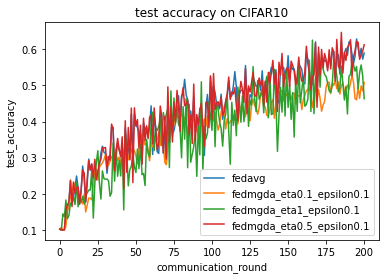

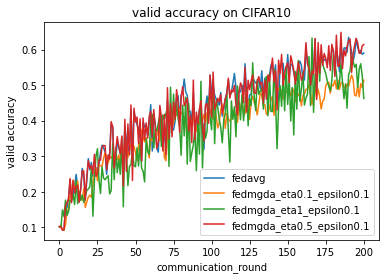

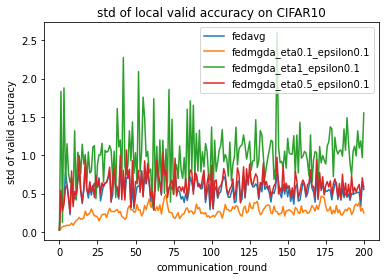

In [9]:
import flgo.experiment.analyzer
analysis_plan = {
    'Selector':{
        'task': task,
        'header':['fedavg', 'fedmgda']
    },
    'Painter':{
        'Curve':[
            {'args':{'x': 'communication_round', 'y':'test_accuracy'}, 'fig_option':{'xlabel':'communication_round', 'ylabel':'test_accuracy','title':'test accuracy on CIFAR10'}},
            {'args':{'x': 'communication_round', 'y':'valid_accuracy'},  'fig_option':{'xlabel':'communication_round', 'ylabel':'valid accuracy','title':'valid accuracy on CIFAR10'}},
            {'args':{'x': 'communication_round', 'y':'std_valid_loss'},  'fig_option':{'xlabel':'communication_round', 'ylabel':'std of valid accuracy','title':'std of local valid accuracy on CIFAR10'}},
        ],
    }
}
flgo.experiment.analyzer.show(analysis_plan)

从结果可以看到，fedmgda+的性能受到全局步长eta影响较大。在该场景下